<a href="https://colab.research.google.com/github/paulandrea0/tesis/blob/main/NewCrossValidation_Copia_de_LPC_Clasificador_MLPerseptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# **Cargando Datos LPC de los sismos**

3.3247 -2.7296


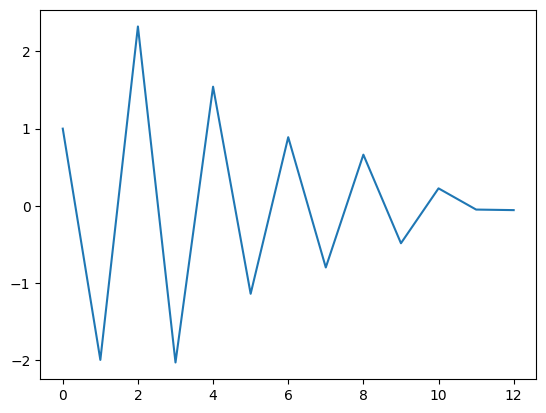

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.signal as signal
import math
from math import floor
from scipy import signal
from scipy.signal import lfilter, resample
from scipy.signal.windows import hann
from numpy.random import randn

VT =  np.array(pd.read_csv('/gdrive/MyDrive/Sismos/LPC Sismos/Matlab para calculo LPC/VT_lpc.csv'))
LP =  np.array(pd.read_csv('/gdrive/MyDrive/Sismos/LPC Sismos/Matlab para calculo LPC/LP_lpc.csv'))
Tor = np.array(pd.read_csv('/gdrive/MyDrive/Sismos/LPC Sismos/Matlab para calculo LPC/TOR_lpc.csv'))

# VT = VT.dropna()
# print(VT.shape)
# VT = np.array(VT)
# print(np.max(VT), np.min(VT))

print(np.max(LP), np.min(LP))
plt.plot(VT[67])


Verificando existencia de valores NaN

In [3]:
import numpy as np

# Identificar valores NaN en VT, LP, Tor
nan_indices_X = np.isnan(VT)
nan_indices_y = np.isnan(LP)
nan_indices_z = np.isnan(Tor)

# Encontrar las filas que contienen NaN
rows_with_nan_X = np.any(nan_indices_X, axis=1)
rows_with_nan_y = np.any(nan_indices_y, axis=1)
rows_with_nan_z = np.any(nan_indices_z, axis=1)

# Imprimir las filas que contienen NaN
print("Filas con NaN en VT:")
print(np.where(rows_with_nan_X)[0])

print("Filas con NaN en LP:")
print(np.where(rows_with_nan_y)[0])

print("Filas con NaN en Tor:")
print(np.where(rows_with_nan_z)[0])

Filas con NaN en VT:
[1630 1631 1632 1633 1634]
Filas con NaN en LP:
[]
Filas con NaN en Tor:
[]


Borrando señales VT con valores NaN

In [4]:
print(VT.shape)
nan_indices = np.isnan(VT).any(axis=1)
VT = VT[~nan_indices]
print(VT.shape)

(1736, 13)
(1731, 13)


In [5]:
import random

# Genera 5 números aleatorios en el rango de 0 a 1730
rand_indices = [random.randint(0, 1730) for _ in range(5)]

# Obtén las filas correspondientes de VT utilizando los índices aleatorios
rand_sign = VT[rand_indices, :]

# Concatena las filas aleatorias a VT a lo largo del eje 0 (filas)
VT = np.concatenate((VT, rand_sign), axis=0)

In [6]:
rand_indices

[207, 1435, 1362, 585, 945]

In [7]:
import numpy as np

# Identificar valores NaN en VT, LP, Tor
nan_indices_X = np.isnan(VT)
nan_indices_y = np.isnan(LP)
nan_indices_z = np.isnan(Tor)

# Encontrar las filas que contienen NaN
rows_with_nan_X = np.any(nan_indices_X, axis=1)
rows_with_nan_y = np.any(nan_indices_y, axis=1)
rows_with_nan_z = np.any(nan_indices_z, axis=1)

# Imprimir las filas que contienen NaN
print("Filas con NaN en VT:")
print(np.where(rows_with_nan_X)[0])

print("Filas con NaN en LP:")
print(np.where(rows_with_nan_y)[0])

print("Filas con NaN en Tor:")
print(np.where(rows_with_nan_z)[0])

Filas con NaN en VT:
[]
Filas con NaN en LP:
[]
Filas con NaN en Tor:
[]


Volvemos a separar el set de datos en set de entrenamiento, prueba y validación para su
respectiva normalización.

In [8]:
np.random.shuffle(VT)
total_filas = VT.shape[0]
filas_entrenamiento = int(0.6 * total_filas)
filas_prueba = int(0.2 * total_filas)
train_1 = VT[:filas_entrenamiento]
test_1 = VT[filas_entrenamiento:filas_entrenamiento + filas_prueba]
val_1 = VT[filas_entrenamiento + filas_prueba:]

np.random.shuffle(LP)
total_filas = LP.shape[0]
filas_entrenamiento = int(0.6 * total_filas)
filas_prueba = int(0.2 * total_filas)
train_2 = LP[:filas_entrenamiento]
test_2 = LP[filas_entrenamiento:filas_entrenamiento + filas_prueba]
val_2 = LP[filas_entrenamiento + filas_prueba:]

np.random.shuffle(Tor)
total_filas = Tor.shape[0]
filas_entrenamiento = int(0.6 * total_filas)
filas_prueba = int(0.2 * total_filas)
train_3 = Tor[:filas_entrenamiento]
test_3 = Tor[filas_entrenamiento:filas_entrenamiento + filas_prueba]
val_3 = Tor[filas_entrenamiento + filas_prueba:]

# Normalización

Mínimo y máximo originales: -8.8, 9.3
Mínimo y máximo normalizado: 0.0, 1.0
Mínimo y máximo originales: -2.7, 3.3
Mínimo y máximo normalizado: 0.0, 1.0
Mínimo y máximo originales: -2.9, 3.9
Mínimo y máximo normalizado: 0.0, 1.0


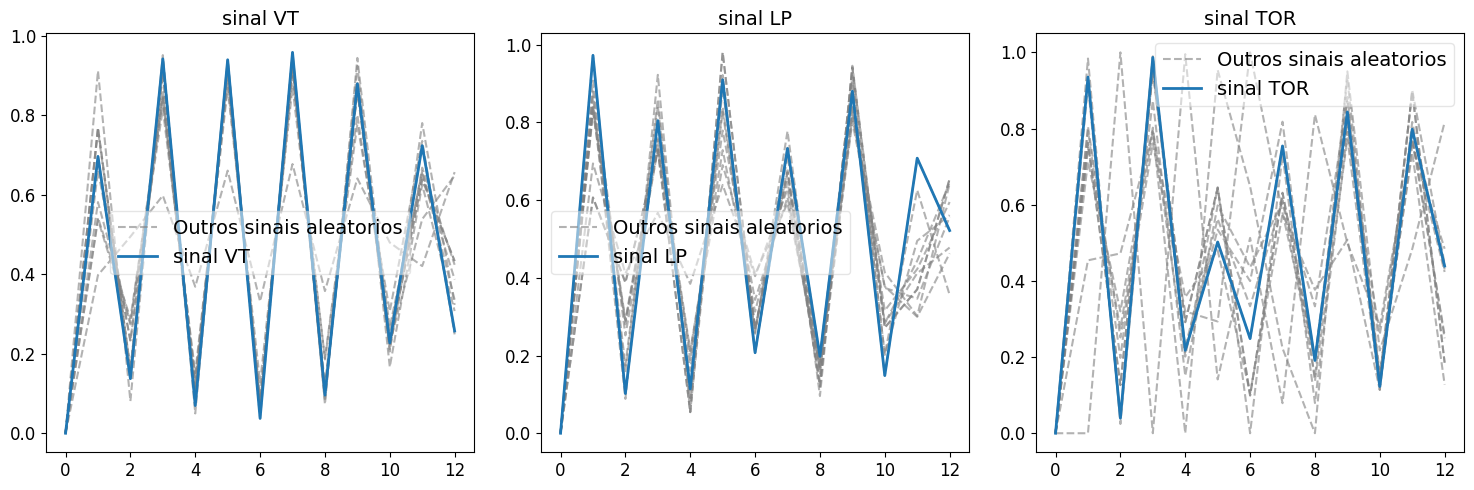

In [9]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

# Señales VT
D_train_s1 = min_max_scaler.fit_transform(train_1)
print('Mínimo y máximo originales: {:.1f}, {:.1f}' .format(np.min(train_1), np.max(train_1)))
print('Mínimo y máximo normalizado: {:.1f}, {:.1f}' .format(np.min(D_train_s1), np.max(D_train_s1)))
D_test_s1 = min_max_scaler.transform(test_1)
val_s1 = min_max_scaler.transform(val_1)

# Señales LP
D_train_s2 = min_max_scaler.fit_transform(train_2)
print('Mínimo y máximo originales: {:.1f}, {:.1f}' .format(np.min(train_2), np.max(train_2)))
print('Mínimo y máximo normalizado: {:.1f}, {:.1f}' .format(np.min(D_train_s2), np.max(D_train_s2)))
D_test_s2 = min_max_scaler.transform(test_2)
val_s2 = min_max_scaler.transform(val_2)

# Señales Tor
D_train_s3 = min_max_scaler.fit_transform(train_3)
print('Mínimo y máximo originales: {:.1f}, {:.1f}' .format(np.min(train_3), np.max(train_3)))
print('Mínimo y máximo normalizado: {:.1f}, {:.1f}' .format(np.min(D_train_s3), np.max(D_train_s3)))
D_test_s3 = min_max_scaler.transform(test_3)
val_s3 = min_max_scaler.transform(val_3)

# Graficando
# Definiendo las clases:
signals_class = [D_train_s1, D_train_s2, D_train_s3]
# Crear una figura de 3x4 subplots
max_signals_per_class = 10
class_names = ['sinal VT', 'sinal LP', 'sinal TOR']

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Iterar sobre las clases y los subplots
for class_idx, signal_class in enumerate(signals_class):
  ax = axs[class_idx]   # Obtener el subplot actual

  # Limitar el número de señales a dibujar por clase
  signal_class = signal_class[:max_signals_per_class]

  # Iterar sobre las señales de la clase y ajustar las propiedades de línea
  for i , signal in enumerate(signal_class):
    # Las señales aleatorias
    ax.plot(signal, linestyle='--', alpha=0.6, label=None, color="grey")

  # primera señal con línea sólida y grosor 2
  ax.plot(signal, linestyle='--', alpha=0.6, label="Outros sinais aleatorios", color="grey")
  ax.plot(signal_class[0], lw=2, label=(class_names[class_idx]), color="tab:blue")

  # Añadir leyenda y etiquetas
  ax.legend(fontsize='14', fancybox=True, framealpha=0.5)
  ax.tick_params(axis='both', labelsize=12)
  ax.set_title(class_names[class_idx], fontsize=14)

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Guardar el gráfico en formato PDF con resolución de 300 DPI
plt.savefig("grafico.pdf", dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()

# **Classificação com MLPerceptron**

Preparando los datos para ser presentados en el clasificador

In [10]:
# a continuación son adicionadas tres columnas que me permitirán ser usadas como etiquetas
D_train_s1 = np.insert(D_train_s1, [0], (0), axis=1)
D_test_s1 = np.insert(D_test_s1, [0], (0), axis=1)
D_train_s2 = np.insert(D_train_s2, [0], (1), axis=1)
D_test_s2 = np.insert(D_test_s2, [0], (1), axis=1)
D_train_s3 = np.insert(D_train_s3, [0], (2), axis=1)
D_test_s3 = np.insert(D_test_s3, [0], (2), axis=1)

print(D_train_s1[1,0:5], D_test_s1[1,0:5])
print(D_train_s2[1,0:5], D_test_s2[1,0:5])
print(D_train_s3[1,0:5], D_test_s3[1,0:5])
print(D_train_s1[1,0:5], D_test_s1[1,0:5])
print(D_train_s2[1,0:5], D_test_s2[1,0:5])
print(D_train_s3[1,0:5], D_test_s3[1,0:5])

# Creo mi set de entrenamiento con sismos y sus etiquetas correspondientes y
set_train = np.concatenate([D_train_s1,D_train_s2, D_train_s3], axis=0)   # hasta aquí las clases están en orden
set_test = np.concatenate([D_test_s1,D_test_s2, D_test_s3], axis=0)    # hasta aquí las clases están en orden
dataset = np.concatenate([set_train, set_test])     # hasta aquí las clases están en orden

# le doy una mezcla a los datos para que entren en desorden en la red neuron
np.random.shuffle(dataset)

print(set_train.shape, set_test.shape)
print(dataset.shape)

[0.         0.         0.91214827 0.08094601 0.95179844] [0.         0.         0.7558123  0.2116041  0.88003847]
[1.         0.         0.83411803 0.28009588 0.75901118] [1.         0.         0.54380889 0.46595181 0.63097015]
[2.         0.         0.80534253 0.25147169 0.76122955] [2.         0.         0.79334647 0.12153119 0.98757286]
[0.         0.         0.91214827 0.08094601 0.95179844] [0.         0.         0.7558123  0.2116041  0.88003847]
[1.         0.         0.83411803 0.28009588 0.75901118] [1.         0.         0.54380889 0.46595181 0.63097015]
[2.         0.         0.80534253 0.25147169 0.76122955] [2.         0.         0.79334647 0.12153119 0.98757286]
(1322, 14) (440, 14)
(1762, 14)


Preparando los datos para ser presentados en el clasificador

In [12]:
print(dataset.shape)
X = np.delete(dataset, 0, axis=1)
y = dataset[: , 0]
print(X.shape, y.shape)

(1762, 14)
(1762, 13) (1762,)


In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras import Sequential
from keras.regularizers import l2 # cuando hay sobreajuste la regularización
# a decartar valores altos en la función de costo. Se puede colocar en cualq
from keras.layers import Dropout #apagar aleatoriamente algunas neuronas,
# ayudando a eliminar el sobreajuste
from keras.callbacks import EarlyStopping
from keras.activations import relu, sigmoid, tanh
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Código CrossVal Stratifyed by Reginaldo

Epoch 1/25
92/92 [==============================] - 6s 4ms/step - loss: 0.6408 - auc: 0.8931
Epoch 2/25
92/92 [==============================] - 1s 6ms/step - loss: 0.5387 - auc: 0.9457
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4720 - auc: 0.9537
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4108 - auc: 0.9633
Epoch 5/25
92/92 [==============================] - 1s 12ms/step - loss: 0.3589 - auc: 0.9718
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3076 - auc: 0.9789
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2694 - auc: 0.9834
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2399 - auc: 0.9870
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.2130 - auc: 0.9897
Epoch 10/25
92/92 [==============================] - 0s 3ms/step - loss: 0.1929 - auc: 0.9911
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - l

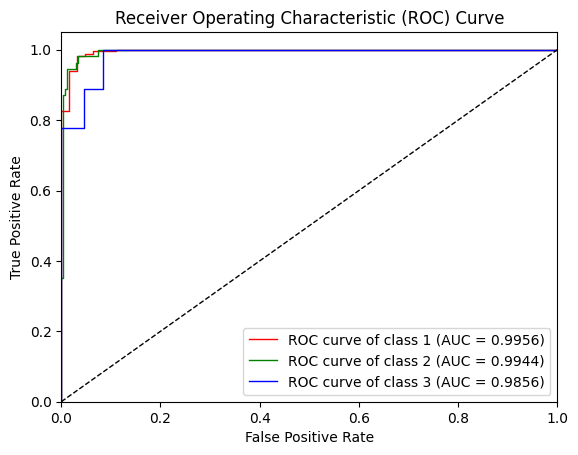

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.9350 - auc: 0.8144
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6354 - auc: 0.8883
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5172 - auc: 0.9452
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 0.4738 - auc: 0.9560
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4297 - auc: 0.9593
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3888 - auc: 0.9643
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3368 - auc: 0.9712
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2921 - auc: 0.9776
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2588 - auc: 0.9808
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2299 - auc: 0.9844
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

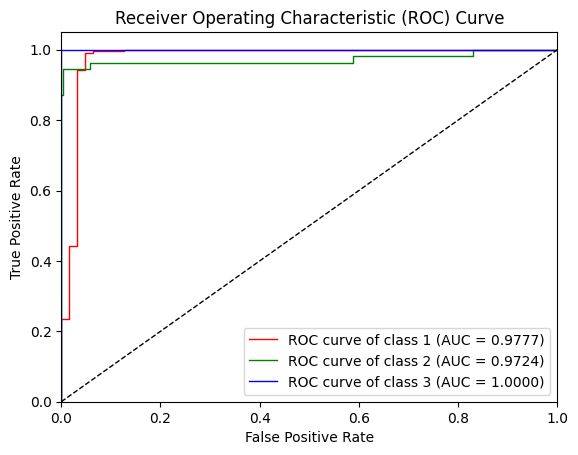

Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 0.7829 - auc: 0.8457
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5786 - auc: 0.9283
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5270 - auc: 0.9398
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4739 - auc: 0.9521
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4331 - auc: 0.9561
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3962 - auc: 0.9611
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3658 - auc: 0.9646
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3380 - auc: 0.9681
Epoch 9/25
92/92 [==============================] - 0s 3ms/step - loss: 0.3106 - auc: 0.9723
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2912 - auc: 0.9746
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

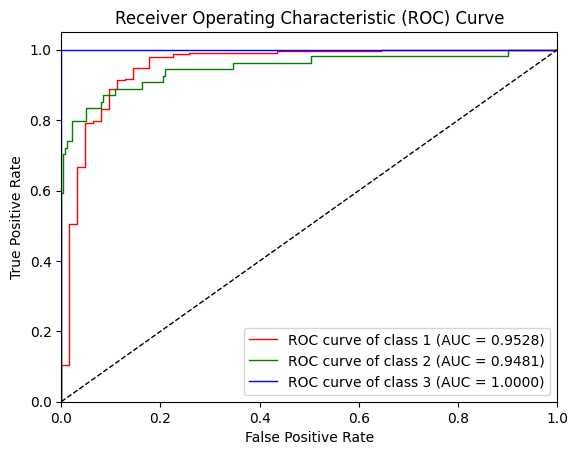

Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 0.7476 - auc: 0.8797
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5609 - auc: 0.9301
Epoch 3/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5287 - auc: 0.9446
Epoch 4/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4976 - auc: 0.9450
Epoch 5/25
92/92 [==============================] - 1s 5ms/step - loss: 0.4574 - auc: 0.9512
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4165 - auc: 0.9592
Epoch 7/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3712 - auc: 0.9667
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3391 - auc: 0.9707
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3007 - auc: 0.9762
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2730 - auc: 0.9797
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

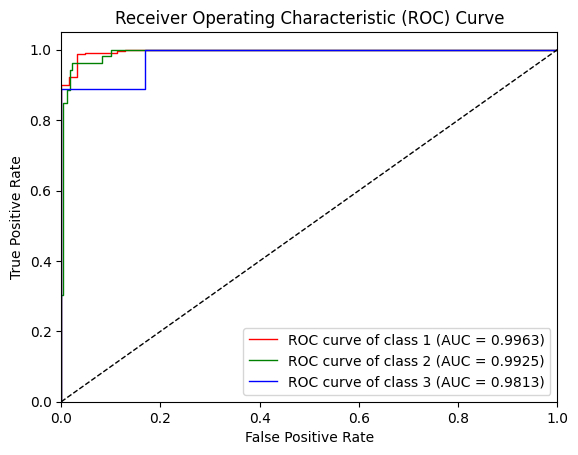

Epoch 1/25
92/92 [==============================] - 1s 4ms/step - loss: 0.6646 - auc: 0.8766
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5748 - auc: 0.9354
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5113 - auc: 0.9389
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4537 - auc: 0.9550
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4111 - auc: 0.9605
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3750 - auc: 0.9646
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3470 - auc: 0.9687
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3219 - auc: 0.9717
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3004 - auc: 0.9757
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2778 - auc: 0.9791
Epoch 11/25
92/92 [==============================] - 0s 3ms/step - lo

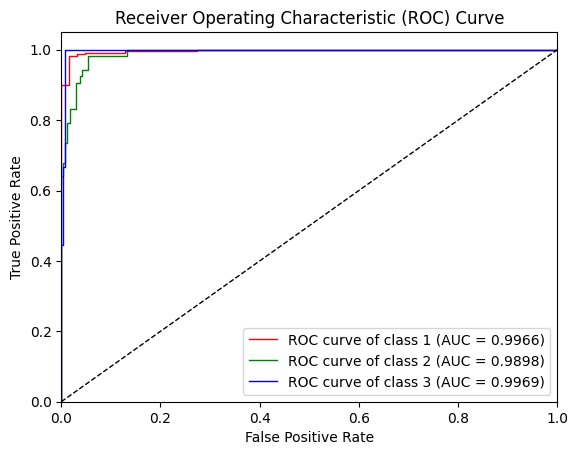

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 1.0147 - auc: 0.7087
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6629 - auc: 0.8948
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5318 - auc: 0.9406
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4900 - auc: 0.9449
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4561 - auc: 0.9496
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4198 - auc: 0.9565
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3813 - auc: 0.9649
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3465 - auc: 0.9715
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3106 - auc: 0.9778
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2789 - auc: 0.9824
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

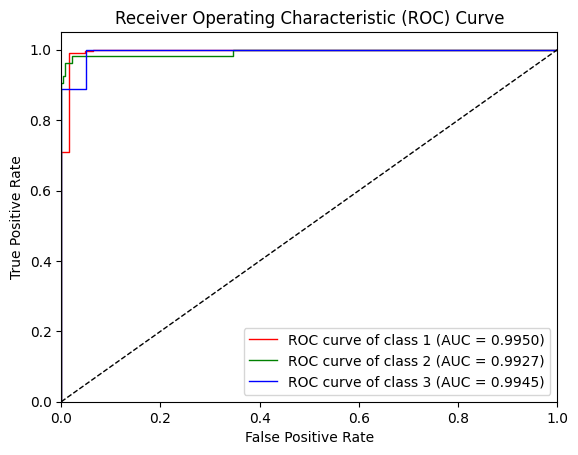

#########################################
Units: 20 Activation Function: relu AUC Média: 0.9867794873602822
#########################################
Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 0.6385 - auc: 0.8724
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6074 - auc: 0.8807
Epoch 3/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6016 - auc: 0.8901
Epoch 4/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5992 - auc: 0.8923
Epoch 5/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5969 - auc: 0.8988
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5929 - auc: 0.9057
Epoch 7/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5879 - auc: 0.9224
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5814 - auc: 0.9317
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5732 - auc: 0.9325
Epoch 10/25
9

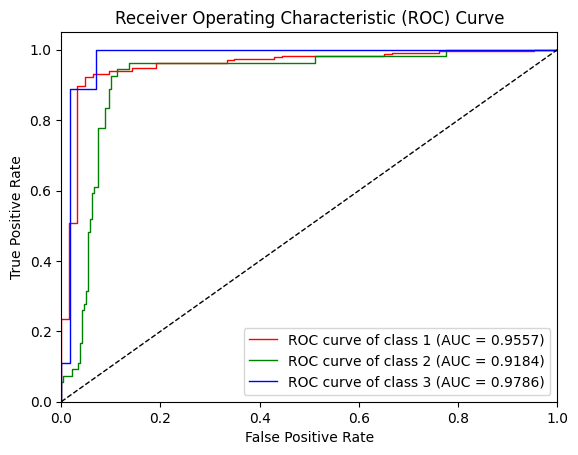

Epoch 1/25
92/92 [==============================] - 1s 4ms/step - loss: 0.7663 - auc: 0.8612
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6221 - auc: 0.8847
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6064 - auc: 0.8884
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6005 - auc: 0.8971
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5981 - auc: 0.9035
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5964 - auc: 0.9084
Epoch 7/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5935 - auc: 0.9080
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5904 - auc: 0.9188
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5866 - auc: 0.9265
Epoch 10/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5832 - auc: 0.9244
Epoch 11/25
92/92 [==============================] - 0s 5ms/step - lo

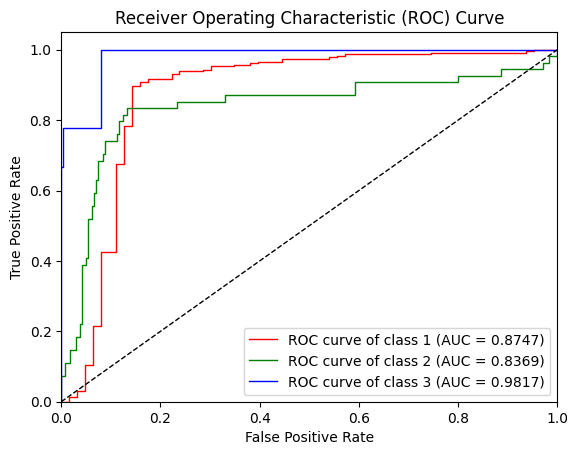

Epoch 1/25
92/92 [==============================] - 1s 4ms/step - loss: 1.3959 - auc: 0.2955
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.7483 - auc: 0.8329
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6512 - auc: 0.8710
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6274 - auc: 0.8718
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6163 - auc: 0.8760
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6104 - auc: 0.8834
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6065 - auc: 0.8952
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6044 - auc: 0.8883
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6024 - auc: 0.8958
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6007 - auc: 0.8994
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

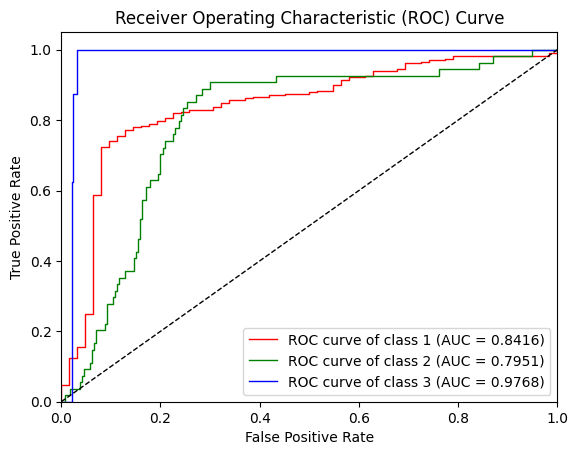

Epoch 1/25
92/92 [==============================] - 1s 4ms/step - loss: 0.9646 - auc: 0.7350
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.7036 - auc: 0.8530
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6395 - auc: 0.8855
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6187 - auc: 0.8859
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6092 - auc: 0.8924
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6038 - auc: 0.9048
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6006 - auc: 0.8977
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5991 - auc: 0.9009
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5963 - auc: 0.9066
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5938 - auc: 0.9131
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

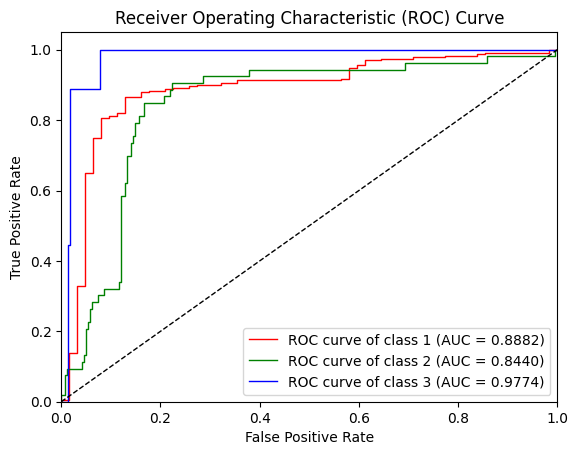

Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 0.7855 - auc: 0.8158
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6358 - auc: 0.8834
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6121 - auc: 0.8845
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6050 - auc: 0.8936
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6029 - auc: 0.8880
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6009 - auc: 0.8969
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5989 - auc: 0.9151
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5980 - auc: 0.9028
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5955 - auc: 0.9044
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5933 - auc: 0.9153
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

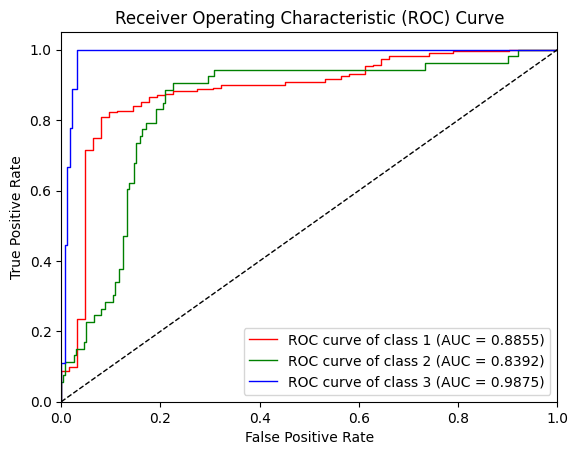

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 1.1191 - auc: 0.6095
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6577 - auc: 0.8795
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6114 - auc: 0.8804
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6049 - auc: 0.8827
Epoch 5/25
92/92 [==============================] - 1s 6ms/step - loss: 0.6030 - auc: 0.8883
Epoch 6/25
92/92 [==============================] - 1s 5ms/step - loss: 0.6017 - auc: 0.8950
Epoch 7/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6009 - auc: 0.8914
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5997 - auc: 0.8989
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5982 - auc: 0.9044
Epoch 10/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5968 - auc: 0.9100
Epoch 11/25
92/92 [==============================] - 0s 5ms/step - lo

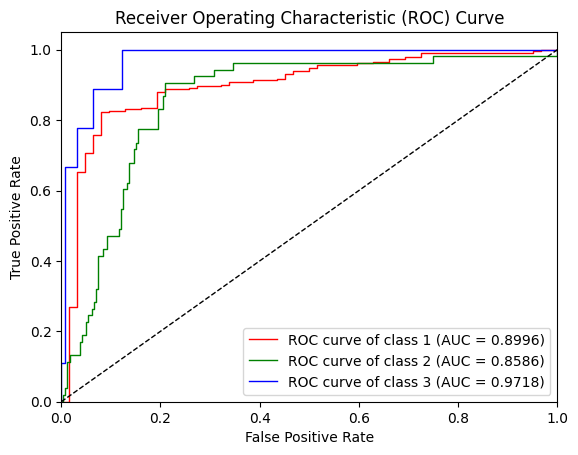

#########################################
Units: 20 Activation Function: sigmoid AUC Média: 0.9061815750255237
#########################################
Epoch 1/25
92/92 [==============================] - 1s 4ms/step - loss: 0.7732 - auc: 0.8341
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6091 - auc: 0.8832
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5784 - auc: 0.9142
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5444 - auc: 0.9347
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5103 - auc: 0.9394
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4666 - auc: 0.9479
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4231 - auc: 0.9560
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3801 - auc: 0.9625
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3385 - auc: 0.9673
Epoch 10/2

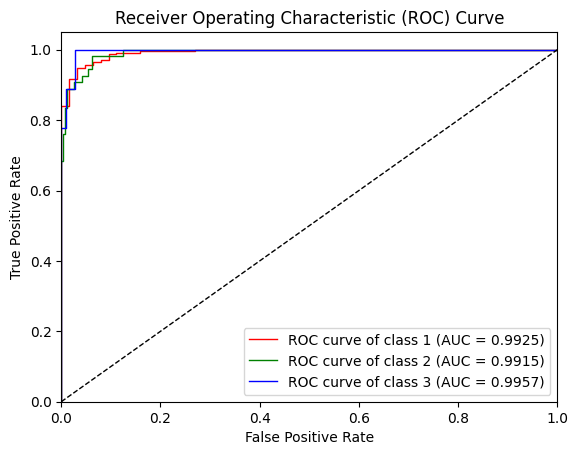

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.6379 - auc: 0.8634
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5735 - auc: 0.9076
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5273 - auc: 0.9388
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4665 - auc: 0.9567
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4037 - auc: 0.9633
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3476 - auc: 0.9694
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3034 - auc: 0.9752
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2644 - auc: 0.9800
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2406 - auc: 0.9826
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2147 - auc: 0.9852
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

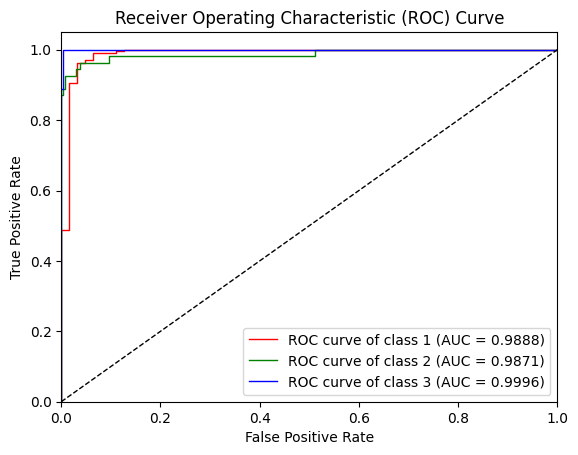

Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 0.7207 - auc: 0.8580
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5473 - auc: 0.9408
Epoch 3/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4959 - auc: 0.9488
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4455 - auc: 0.9577
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4001 - auc: 0.9619
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3576 - auc: 0.9672
Epoch 7/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3244 - auc: 0.9703
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2933 - auc: 0.9750
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2704 - auc: 0.9771
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2500 - auc: 0.9794
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

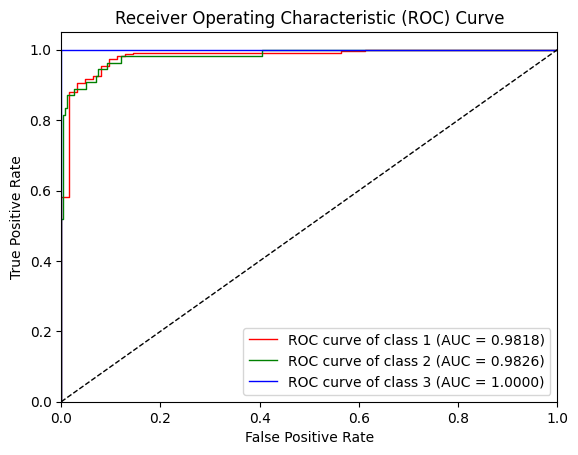

Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 0.6156 - auc: 0.8947
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5669 - auc: 0.9317
Epoch 3/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5307 - auc: 0.9374
Epoch 4/25
92/92 [==============================] - 1s 6ms/step - loss: 0.4792 - auc: 0.9455
Epoch 5/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4232 - auc: 0.9578
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3666 - auc: 0.9666
Epoch 7/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3148 - auc: 0.9742
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.2744 - auc: 0.9787
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.2430 - auc: 0.9816
Epoch 10/25
92/92 [==============================] - 0s 5ms/step - loss: 0.2157 - auc: 0.9845
Epoch 11/25
92/92 [==============================] - 0s 5ms/step - lo

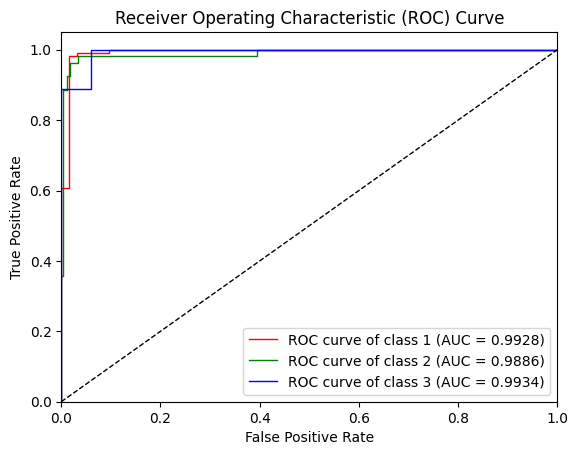

Epoch 1/25
92/92 [==============================] - 1s 4ms/step - loss: 0.8121 - auc: 0.8256
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5692 - auc: 0.9368
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5302 - auc: 0.9351
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4942 - auc: 0.9410
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4513 - auc: 0.9514
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4070 - auc: 0.9587
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3663 - auc: 0.9638
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3366 - auc: 0.9686
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3010 - auc: 0.9750
Epoch 10/25
92/92 [==============================] - 0s 5ms/step - loss: 0.2724 - auc: 0.9781
Epoch 11/25
92/92 [==============================] - 0s 5ms/step - lo

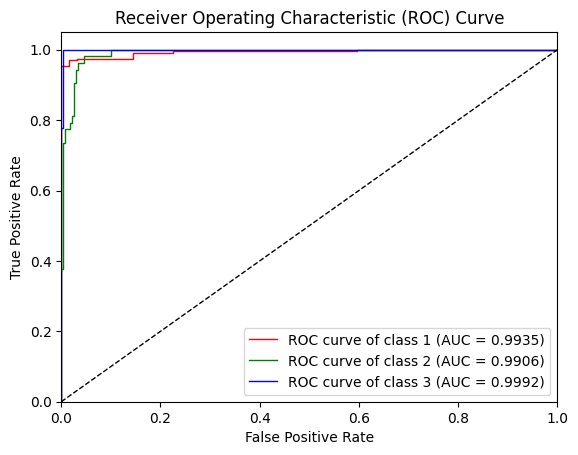

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.6913 - auc: 0.8692
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5444 - auc: 0.9428
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4811 - auc: 0.9504
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4264 - auc: 0.9601
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3762 - auc: 0.9652
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3412 - auc: 0.9681
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3068 - auc: 0.9732
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2854 - auc: 0.9754
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.2630 - auc: 0.9778
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2422 - auc: 0.9806
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

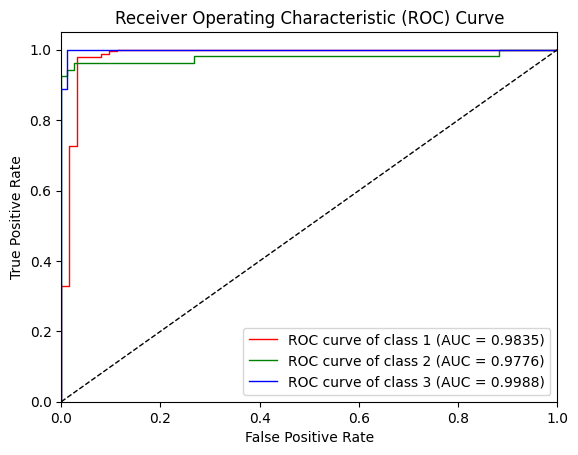

#########################################
Units: 20 Activation Function: tanh AUC Média: 0.9909879408015231
#########################################
Epoch 1/25
92/92 [==============================] - 3s 5ms/step - loss: 0.7695 - auc: 0.8707
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5741 - auc: 0.9152
Epoch 3/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5366 - auc: 0.9353
Epoch 4/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4979 - auc: 0.9401
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4542 - auc: 0.9535
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4124 - auc: 0.9595
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3713 - auc: 0.9656
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3364 - auc: 0.9696
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2992 - auc: 0.9774
Epoch 10/25
9

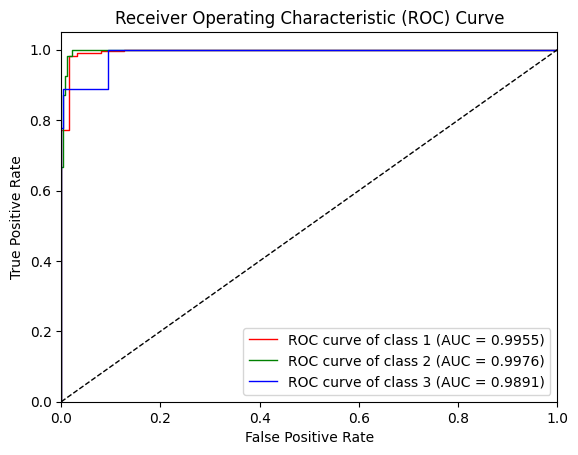

Epoch 1/25
92/92 [==============================] - 1s 4ms/step - loss: 0.7214 - auc: 0.8720
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5686 - auc: 0.9281
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5362 - auc: 0.9429
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5047 - auc: 0.9434
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4736 - auc: 0.9514
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4389 - auc: 0.9562
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4071 - auc: 0.9596
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3771 - auc: 0.9632
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3496 - auc: 0.9666
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3231 - auc: 0.9716
Epoch 11/25
92/92 [==============================] - 0s 5ms/step - lo

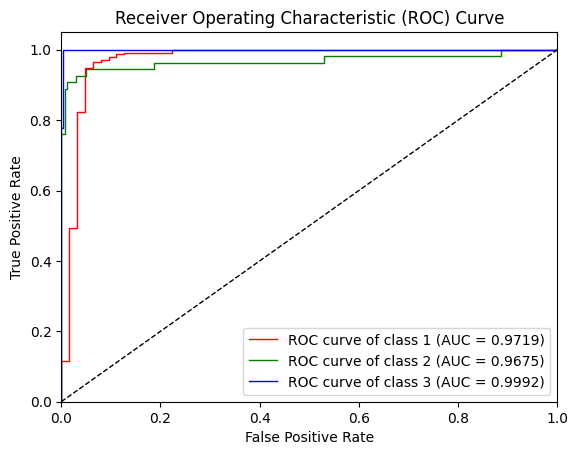

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.6822 - auc: 0.8666
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5818 - auc: 0.9221
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5333 - auc: 0.9382
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4946 - auc: 0.9434
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4517 - auc: 0.9507
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4086 - auc: 0.9584
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3660 - auc: 0.9661
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3320 - auc: 0.9716
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2975 - auc: 0.9780
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2723 - auc: 0.9813
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

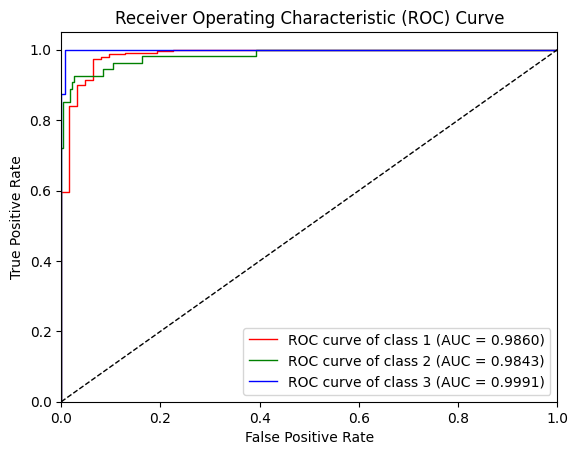

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 1.0808 - auc: 0.5944
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.7151 - auc: 0.8685
Epoch 3/25
92/92 [==============================] - 1s 6ms/step - loss: 0.5588 - auc: 0.9459
Epoch 4/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4930 - auc: 0.9506
Epoch 5/25
92/92 [==============================] - 1s 6ms/step - loss: 0.4454 - auc: 0.9538
Epoch 6/25
92/92 [==============================] - 1s 6ms/step - loss: 0.4071 - auc: 0.9589
Epoch 7/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3767 - auc: 0.9626
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3481 - auc: 0.9673
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3222 - auc: 0.9710
Epoch 10/25
92/92 [==============================] - 0s 5ms/step - loss: 0.2959 - auc: 0.9756
Epoch 11/25
92/92 [==============================] - 0s 5ms/step - lo

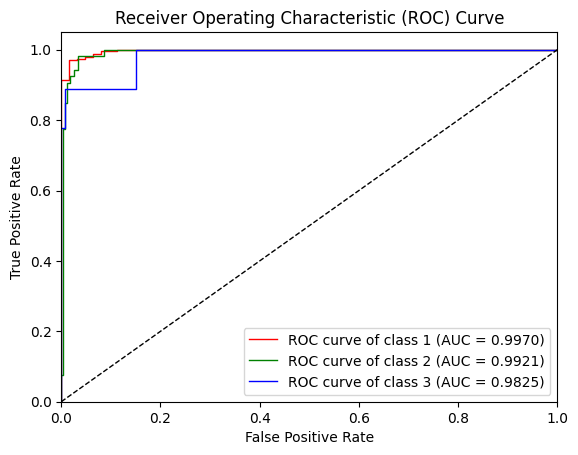

Epoch 1/25
92/92 [==============================] - 1s 4ms/step - loss: 0.8622 - auc: 0.8028
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5713 - auc: 0.9202
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5209 - auc: 0.9497
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4768 - auc: 0.9535
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4345 - auc: 0.9597
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3973 - auc: 0.9654
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3636 - auc: 0.9696
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3309 - auc: 0.9736
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2993 - auc: 0.9783
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2718 - auc: 0.9821
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

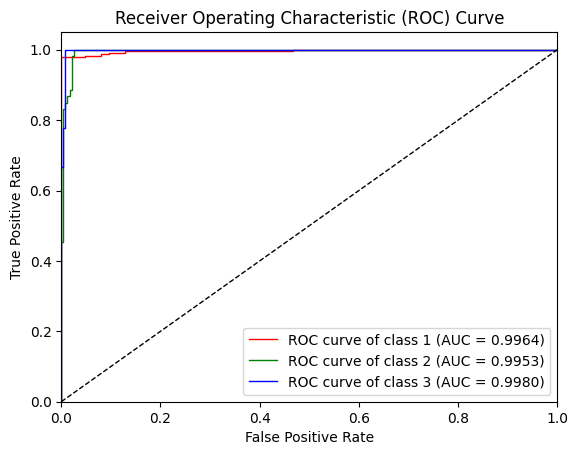

Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 0.8460 - auc: 0.8463
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6035 - auc: 0.8981
Epoch 3/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5639 - auc: 0.9192
Epoch 4/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5328 - auc: 0.9367
Epoch 5/25
92/92 [==============================] - 1s 6ms/step - loss: 0.4984 - auc: 0.9476
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4606 - auc: 0.9565
Epoch 7/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4274 - auc: 0.9607
Epoch 8/25
92/92 [==============================] - 1s 6ms/step - loss: 0.3918 - auc: 0.9654
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3616 - auc: 0.9681
Epoch 10/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3315 - auc: 0.9731
Epoch 11/25
92/92 [==============================] - 0s 5ms/step - lo

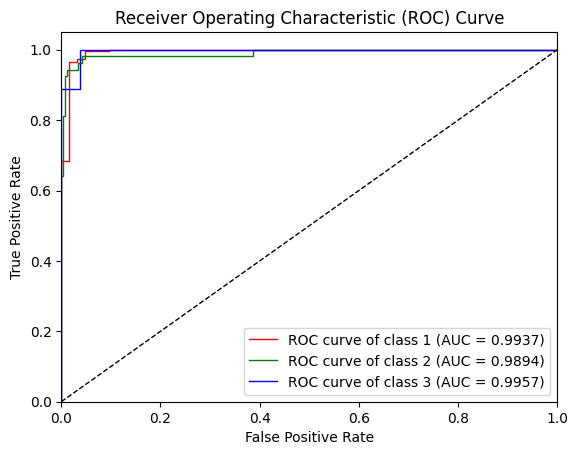

#########################################
Units: 18 Activation Function: relu AUC Média: 0.9905735525232924
#########################################
Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.7888 - auc: 0.8433
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6202 - auc: 0.8816
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6014 - auc: 0.8881
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5993 - auc: 0.8957
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5981 - auc: 0.8957
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5964 - auc: 0.9039
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5950 - auc: 0.9028
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5926 - auc: 0.9128
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5893 - auc: 0.9240
Epoch 10/25
9

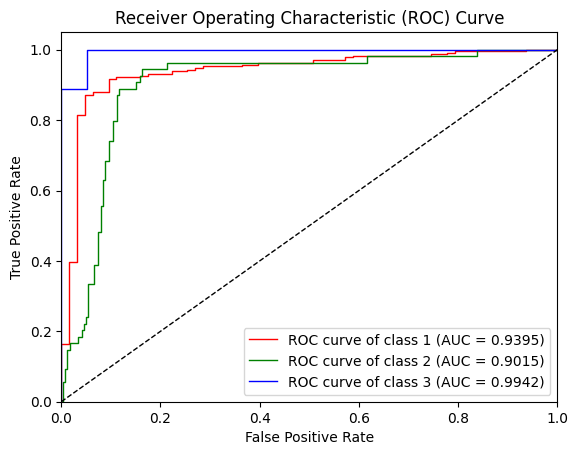

Epoch 1/25
92/92 [==============================] - 2s 6ms/step - loss: 0.8955 - auc: 0.8463
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6754 - auc: 0.8826
Epoch 3/25
92/92 [==============================] - 1s 11ms/step - loss: 0.6261 - auc: 0.8827
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6109 - auc: 0.8890
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6055 - auc: 0.8872
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6026 - auc: 0.8935
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6010 - auc: 0.8971
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5995 - auc: 0.9109
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5987 - auc: 0.9013
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5963 - auc: 0.9138
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - l

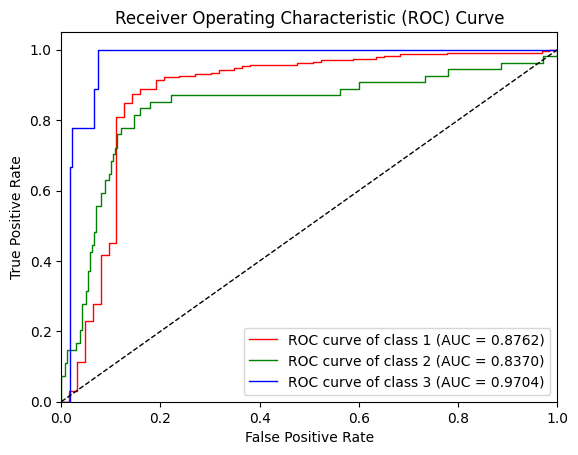

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.6731 - auc: 0.8810
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6056 - auc: 0.8861
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6018 - auc: 0.8992
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5992 - auc: 0.9041
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5972 - auc: 0.9078
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5945 - auc: 0.9106
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5909 - auc: 0.9213
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5873 - auc: 0.9175
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5824 - auc: 0.9230
Epoch 10/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5772 - auc: 0.9314
Epoch 11/25
92/92 [==============================] - 1s 6ms/step - lo

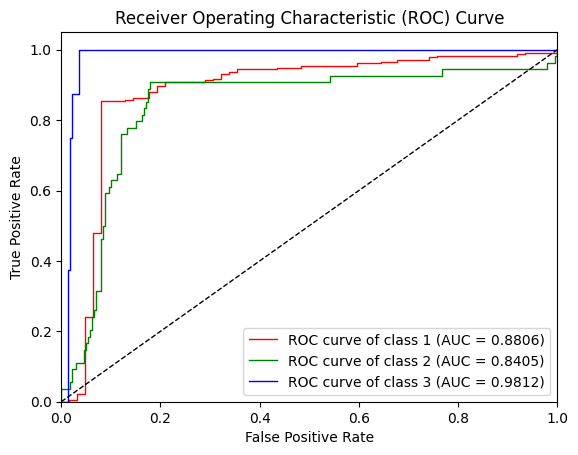

Epoch 1/25
92/92 [==============================] - 1s 4ms/step - loss: 0.8423 - auc: 0.7998
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6708 - auc: 0.8289
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6258 - auc: 0.8811
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6114 - auc: 0.8857
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6051 - auc: 0.8934
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6023 - auc: 0.8916
Epoch 7/25
92/92 [==============================] - 1s 5ms/step - loss: 0.5987 - auc: 0.9076
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5959 - auc: 0.9167
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5922 - auc: 0.9189
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5871 - auc: 0.9292
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

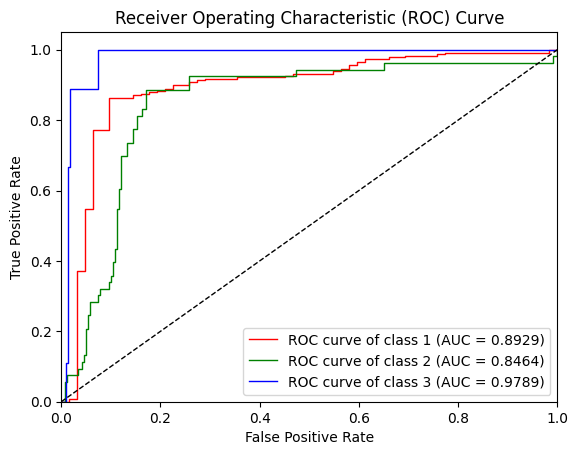

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.7583 - auc: 0.8658
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6154 - auc: 0.8776
Epoch 3/25
92/92 [==============================] - 1s 5ms/step - loss: 0.6044 - auc: 0.8911
Epoch 4/25
92/92 [==============================] - 1s 5ms/step - loss: 0.6011 - auc: 0.8988
Epoch 5/25
92/92 [==============================] - 1s 5ms/step - loss: 0.5984 - auc: 0.9121
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5958 - auc: 0.9145
Epoch 7/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5929 - auc: 0.9190
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5894 - auc: 0.9305
Epoch 9/25
92/92 [==============================] - 1s 6ms/step - loss: 0.5848 - auc: 0.9257
Epoch 10/25
92/92 [==============================] - 1s 6ms/step - loss: 0.5805 - auc: 0.9283
Epoch 11/25
92/92 [==============================] - 0s 5ms/step - lo

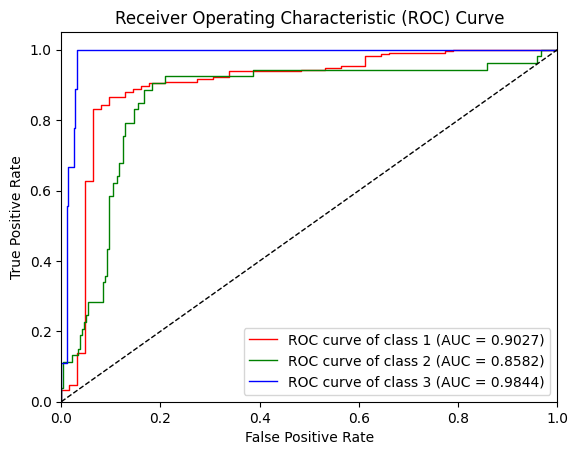

Epoch 1/25
92/92 [==============================] - 1s 4ms/step - loss: 1.1868 - auc: 0.4367
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.7589 - auc: 0.8418
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6510 - auc: 0.8814
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6206 - auc: 0.8848
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6096 - auc: 0.8930
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6049 - auc: 0.8914
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6028 - auc: 0.9003
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6012 - auc: 0.8978
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6002 - auc: 0.9062
Epoch 10/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5989 - auc: 0.9039
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

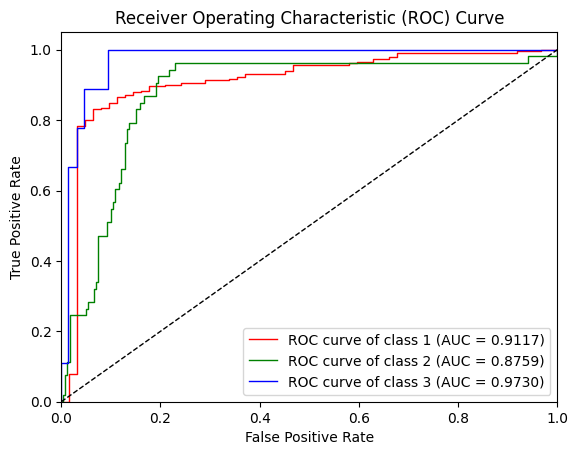

#########################################
Units: 18 Activation Function: sigmoid AUC Média: 0.9136246272610391
#########################################
Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 0.6163 - auc: 0.8986
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5283 - auc: 0.9398
Epoch 3/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4801 - auc: 0.9501
Epoch 4/25
92/92 [==============================] - 1s 6ms/step - loss: 0.4362 - auc: 0.9564
Epoch 5/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3940 - auc: 0.9599
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3572 - auc: 0.9642
Epoch 7/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3291 - auc: 0.9685
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3033 - auc: 0.9719
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.2795 - auc: 0.9752
Epoch 10/2

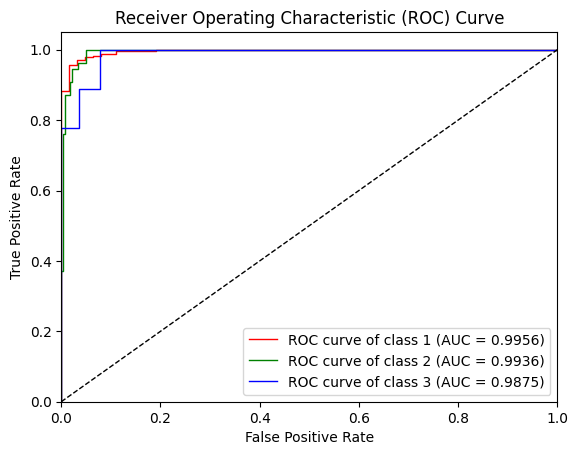

Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 0.6589 - auc: 0.8857
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5779 - auc: 0.9215
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5487 - auc: 0.9238
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5105 - auc: 0.9403
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4593 - auc: 0.9552
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4038 - auc: 0.9638
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3500 - auc: 0.9698
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3094 - auc: 0.9740
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.2795 - auc: 0.9771
Epoch 10/25
92/92 [==============================] - 1s 6ms/step - loss: 0.2590 - auc: 0.9791
Epoch 11/25
92/92 [==============================] - 1s 6ms/step - lo

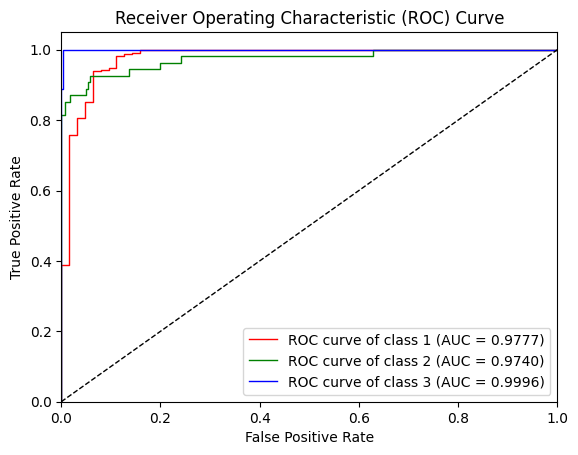

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.8405 - auc: 0.8055
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5955 - auc: 0.9208
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5603 - auc: 0.9425
Epoch 4/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5193 - auc: 0.9485
Epoch 5/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4720 - auc: 0.9518
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4153 - auc: 0.9598
Epoch 7/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3620 - auc: 0.9684
Epoch 8/25
92/92 [==============================] - 1s 5ms/step - loss: 0.3194 - auc: 0.9735
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.2819 - auc: 0.9781
Epoch 10/25
92/92 [==============================] - 0s 5ms/step - loss: 0.2579 - auc: 0.9801
Epoch 11/25
92/92 [==============================] - 1s 5ms/step - lo

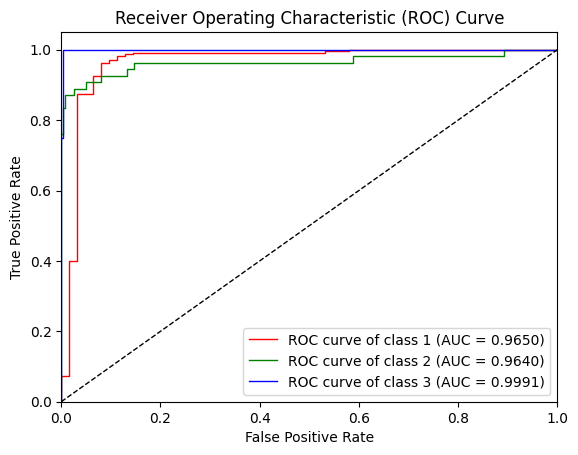

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.6946 - auc: 0.8622
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5955 - auc: 0.9054
Epoch 3/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5616 - auc: 0.9324
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5145 - auc: 0.9399
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4614 - auc: 0.9545
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4079 - auc: 0.9625
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3662 - auc: 0.9666
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3299 - auc: 0.9705
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3001 - auc: 0.9745
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2740 - auc: 0.9774
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

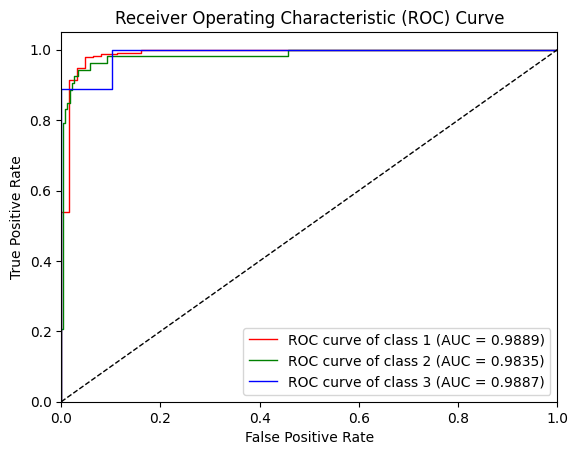

Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 0.6790 - auc: 0.8814
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5602 - auc: 0.9343
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5186 - auc: 0.9416
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4671 - auc: 0.9510
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4118 - auc: 0.9606
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3571 - auc: 0.9687
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3193 - auc: 0.9728
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2800 - auc: 0.9769
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.2533 - auc: 0.9793
Epoch 10/25
92/92 [==============================] - 0s 5ms/step - loss: 0.2345 - auc: 0.9811
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

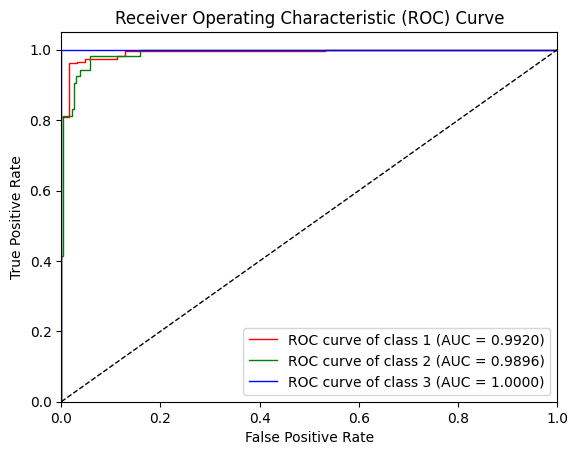

Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 0.7894 - auc: 0.8299
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5817 - auc: 0.9021
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5463 - auc: 0.9303
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5030 - auc: 0.9477
Epoch 5/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4487 - auc: 0.9595
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3868 - auc: 0.9677
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3282 - auc: 0.9745
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2808 - auc: 0.9798
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2465 - auc: 0.9821
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2218 - auc: 0.9839
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

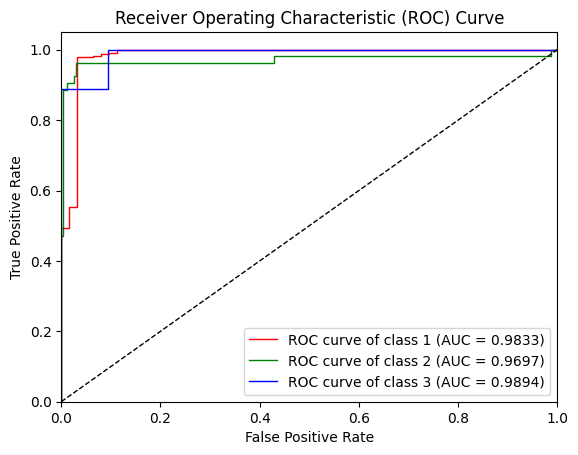

#########################################
Units: 18 Activation Function: tanh AUC Média: 0.9856324597459967
#########################################
Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 0.7651 - auc: 0.8601
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5668 - auc: 0.9450
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4987 - auc: 0.9556
Epoch 4/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4464 - auc: 0.9642
Epoch 5/25
92/92 [==============================] - 1s 6ms/step - loss: 0.4041 - auc: 0.9676
Epoch 6/25
92/92 [==============================] - 1s 6ms/step - loss: 0.3691 - auc: 0.9704
Epoch 7/25
92/92 [==============================] - 1s 6ms/step - loss: 0.3378 - auc: 0.9728
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3062 - auc: 0.9765
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.2817 - auc: 0.9799
Epoch 10/25
9

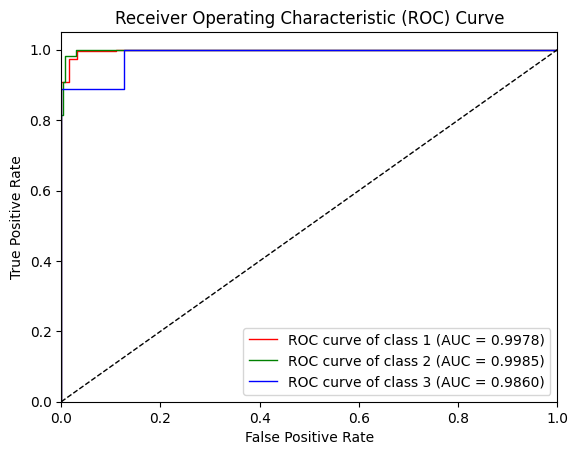

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.7902 - auc: 0.8689
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6097 - auc: 0.8892
Epoch 3/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5952 - auc: 0.9077
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5878 - auc: 0.9244
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5798 - auc: 0.9304
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5701 - auc: 0.9320
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5591 - auc: 0.9339
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5447 - auc: 0.9394
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5274 - auc: 0.9410
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5010 - auc: 0.9418
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

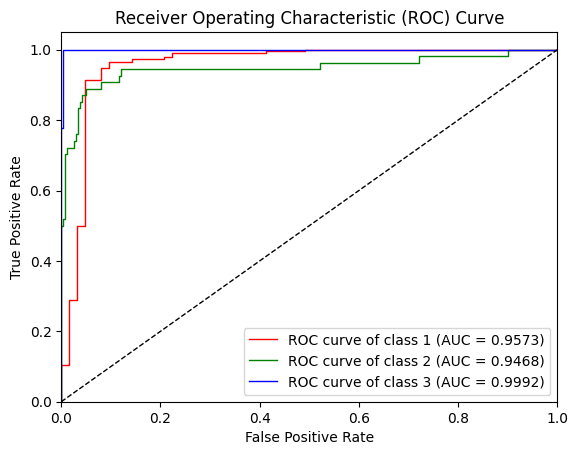

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 1.1195 - auc: 0.5663
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6513 - auc: 0.8898
Epoch 3/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5717 - auc: 0.9292
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5356 - auc: 0.9358
Epoch 5/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4971 - auc: 0.9472
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4568 - auc: 0.9574
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4199 - auc: 0.9644
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3835 - auc: 0.9688
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3430 - auc: 0.9740
Epoch 10/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3074 - auc: 0.9782
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

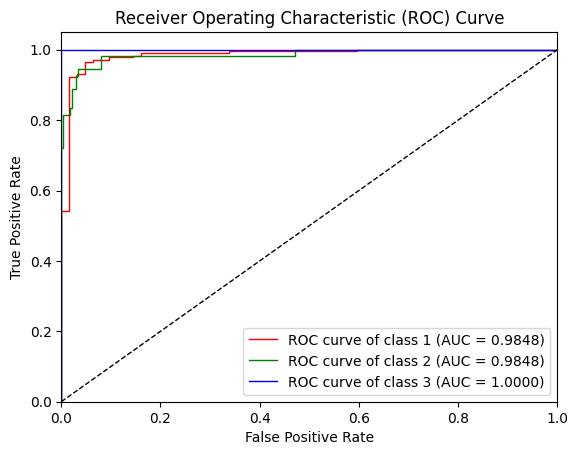

Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 0.7944 - auc: 0.8509
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6086 - auc: 0.9248
Epoch 3/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5601 - auc: 0.9409
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5340 - auc: 0.9415
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5124 - auc: 0.9441
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4895 - auc: 0.9470
Epoch 7/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4666 - auc: 0.9484
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4434 - auc: 0.9521
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4137 - auc: 0.9591
Epoch 10/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3627 - auc: 0.9682
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

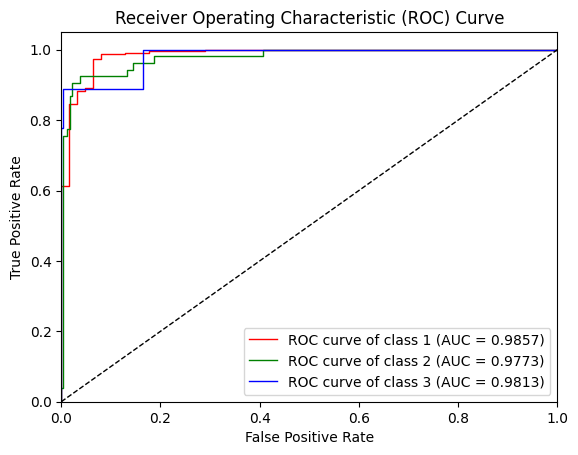

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.6717 - auc: 0.8752
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5698 - auc: 0.9140
Epoch 3/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5537 - auc: 0.9207
Epoch 4/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5406 - auc: 0.9293
Epoch 5/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5284 - auc: 0.9335
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5119 - auc: 0.9384
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4942 - auc: 0.9459
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4703 - auc: 0.9529
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4430 - auc: 0.9583
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4167 - auc: 0.9613
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

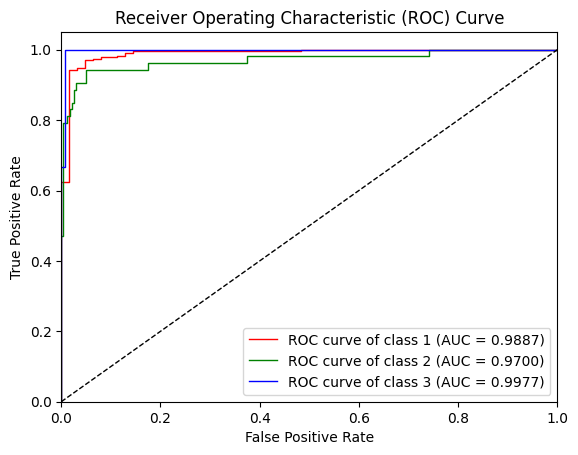

Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 1.1195 - auc: 0.4968
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6436 - auc: 0.8851
Epoch 3/25
92/92 [==============================] - 1s 5ms/step - loss: 0.5657 - auc: 0.9374
Epoch 4/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5369 - auc: 0.9381
Epoch 5/25
92/92 [==============================] - 1s 6ms/step - loss: 0.5069 - auc: 0.9467
Epoch 6/25
92/92 [==============================] - 1s 6ms/step - loss: 0.4803 - auc: 0.9490
Epoch 7/25
92/92 [==============================] - 1s 5ms/step - loss: 0.4538 - auc: 0.9535
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4255 - auc: 0.9559
Epoch 9/25
92/92 [==============================] - 1s 6ms/step - loss: 0.3985 - auc: 0.9594
Epoch 10/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3714 - auc: 0.9620
Epoch 11/25
92/92 [==============================] - 0s 5ms/step - lo

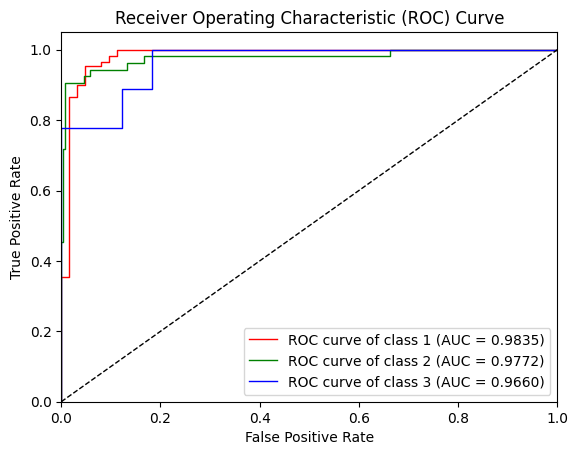

#########################################
Units: 16 Activation Function: relu AUC Média: 0.9823495239268417
#########################################
Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 0.6436 - auc: 0.8808
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6082 - auc: 0.8911
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5994 - auc: 0.9126
Epoch 4/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5959 - auc: 0.9138
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5928 - auc: 0.9099
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5889 - auc: 0.9204
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5845 - auc: 0.9225
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5806 - auc: 0.9275
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5738 - auc: 0.9345
Epoch 10/25
9

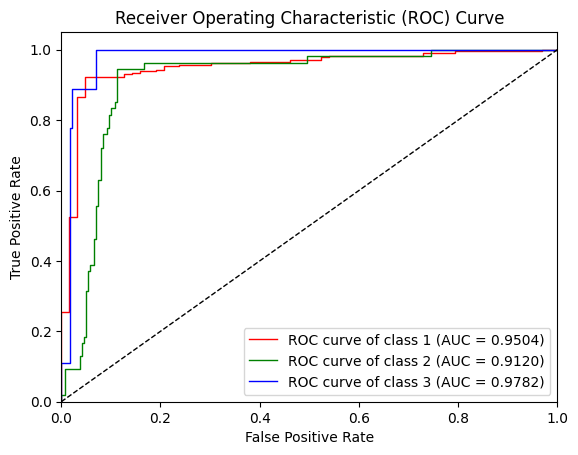

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.7834 - auc: 0.8344
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6155 - auc: 0.8777
Epoch 3/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6031 - auc: 0.8871
Epoch 4/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6005 - auc: 0.9008
Epoch 5/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5983 - auc: 0.9062
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5961 - auc: 0.9063
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5941 - auc: 0.9206
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5915 - auc: 0.9275
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5889 - auc: 0.9225
Epoch 10/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5861 - auc: 0.9267
Epoch 11/25
92/92 [==============================] - 0s 5ms/step - lo

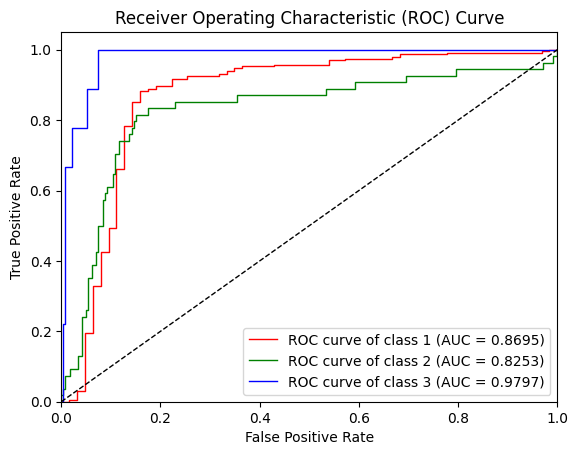

Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 0.7490 - auc: 0.8064
Epoch 2/25
92/92 [==============================] - 1s 5ms/step - loss: 0.6335 - auc: 0.8812
Epoch 3/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6106 - auc: 0.8854
Epoch 4/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6049 - auc: 0.8880
Epoch 5/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6018 - auc: 0.9008
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6004 - auc: 0.9040
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5991 - auc: 0.9069
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5964 - auc: 0.9148
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5941 - auc: 0.9185
Epoch 10/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5910 - auc: 0.9298
Epoch 11/25
92/92 [==============================] - 0s 5ms/step - lo

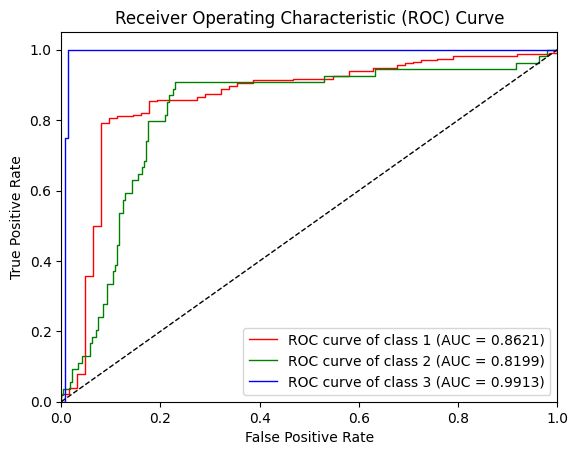

Epoch 1/25
92/92 [==============================] - 3s 5ms/step - loss: 1.6282 - auc: 0.1162
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 1.1478 - auc: 0.3761
Epoch 3/25
92/92 [==============================] - 0s 5ms/step - loss: 0.9296 - auc: 0.8436
Epoch 4/25
92/92 [==============================] - 0s 5ms/step - loss: 0.7796 - auc: 0.8772
Epoch 5/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6933 - auc: 0.8765
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6523 - auc: 0.8802
Epoch 7/25
92/92 [==============================] - 1s 6ms/step - loss: 0.6329 - auc: 0.8796
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6221 - auc: 0.8881
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6156 - auc: 0.8847
Epoch 10/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6117 - auc: 0.8843
Epoch 11/25
92/92 [==============================] - 0s 5ms/step - lo

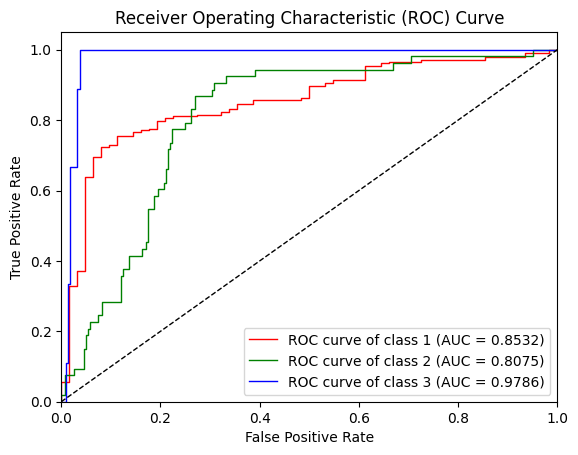

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.8422 - auc: 0.8156
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6799 - auc: 0.8640
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6296 - auc: 0.8891
Epoch 4/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6127 - auc: 0.8913
Epoch 5/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6054 - auc: 0.8982
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6021 - auc: 0.8975
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5997 - auc: 0.8992
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5972 - auc: 0.9125
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5946 - auc: 0.9241
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5920 - auc: 0.9231
Epoch 11/25
92/92 [==============================] - 0s 5ms/step - lo

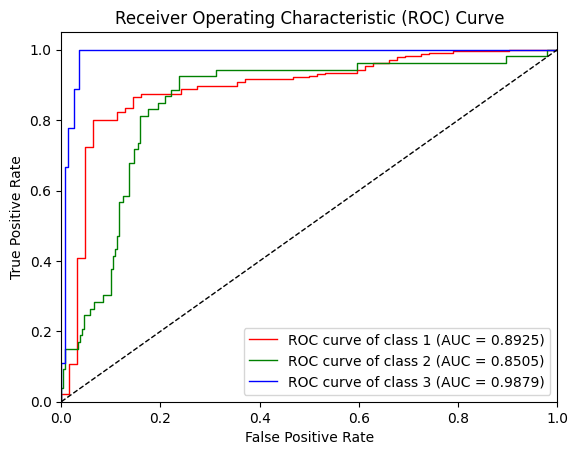

Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 1.3677 - auc: 0.3935
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 0.8737 - auc: 0.7951
Epoch 3/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6883 - auc: 0.8760
Epoch 4/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6288 - auc: 0.8862
Epoch 5/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6113 - auc: 0.8833
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6064 - auc: 0.8852
Epoch 7/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6042 - auc: 0.8919
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6030 - auc: 0.8963
Epoch 9/25
92/92 [==============================] - 1s 6ms/step - loss: 0.6022 - auc: 0.8995
Epoch 10/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6019 - auc: 0.8935
Epoch 11/25
92/92 [==============================] - 1s 6ms/step - lo

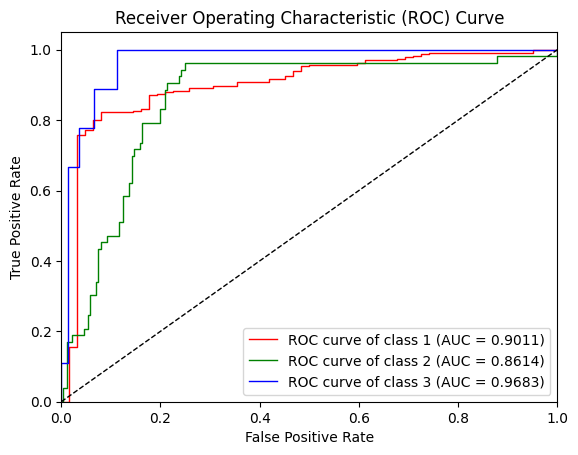

#########################################
Units: 16 Activation Function: sigmoid AUC Média: 0.9049575748351374
#########################################
Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.9128 - auc: 0.7585
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6049 - auc: 0.9009
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5674 - auc: 0.9290
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5301 - auc: 0.9441
Epoch 5/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4859 - auc: 0.9500
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4428 - auc: 0.9532
Epoch 7/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3977 - auc: 0.9598
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3540 - auc: 0.9670
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3189 - auc: 0.9720
Epoch 10/2

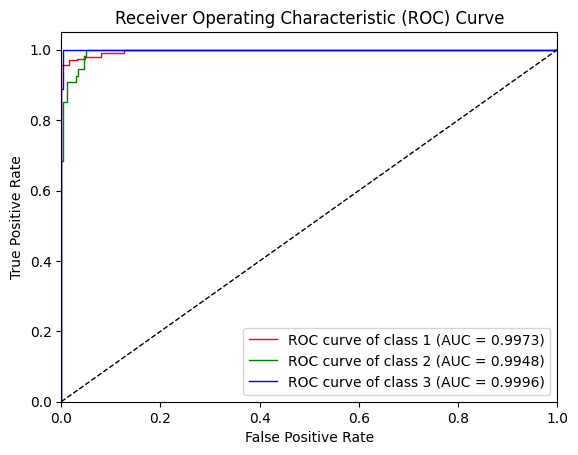

Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 0.7341 - auc: 0.8701
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5810 - auc: 0.9207
Epoch 3/25
92/92 [==============================] - 1s 6ms/step - loss: 0.5452 - auc: 0.9327
Epoch 4/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5111 - auc: 0.9413
Epoch 5/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4636 - auc: 0.9489
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4128 - auc: 0.9597
Epoch 7/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3585 - auc: 0.9679
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3159 - auc: 0.9731
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.2830 - auc: 0.9770
Epoch 10/25
92/92 [==============================] - 0s 5ms/step - loss: 0.2582 - auc: 0.9797
Epoch 11/25
92/92 [==============================] - 0s 5ms/step - lo

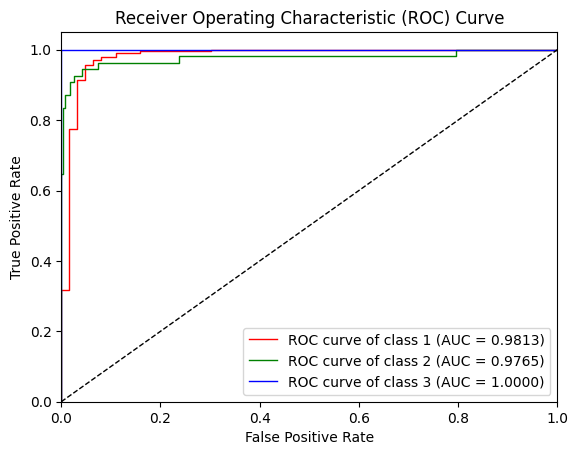

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.7166 - auc: 0.8590
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5939 - auc: 0.8996
Epoch 3/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5681 - auc: 0.9242
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5330 - auc: 0.9412
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4896 - auc: 0.9512
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4435 - auc: 0.9600
Epoch 7/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3974 - auc: 0.9647
Epoch 8/25
92/92 [==============================] - 1s 6ms/step - loss: 0.3576 - auc: 0.9688
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3236 - auc: 0.9728
Epoch 10/25
92/92 [==============================] - 1s 5ms/step - loss: 0.3019 - auc: 0.9747
Epoch 11/25
92/92 [==============================] - 0s 5ms/step - lo

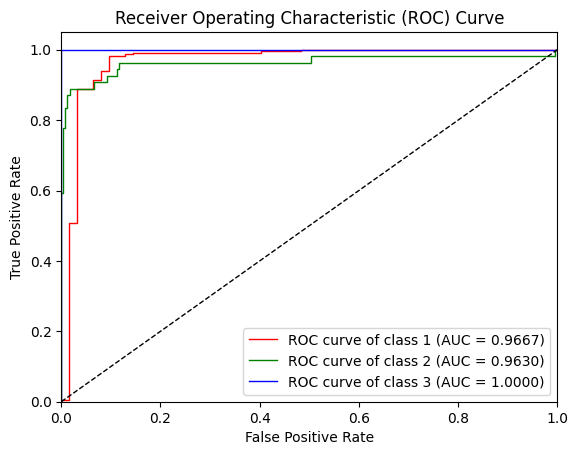

Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 0.8255 - auc: 0.8125
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5941 - auc: 0.9338
Epoch 3/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5591 - auc: 0.9493
Epoch 4/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5200 - auc: 0.9489
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4729 - auc: 0.9539
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4226 - auc: 0.9620
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3780 - auc: 0.9668
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3331 - auc: 0.9719
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2971 - auc: 0.9769
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2702 - auc: 0.9786
Epoch 11/25
92/92 [==============================] - 0s 5ms/step - lo

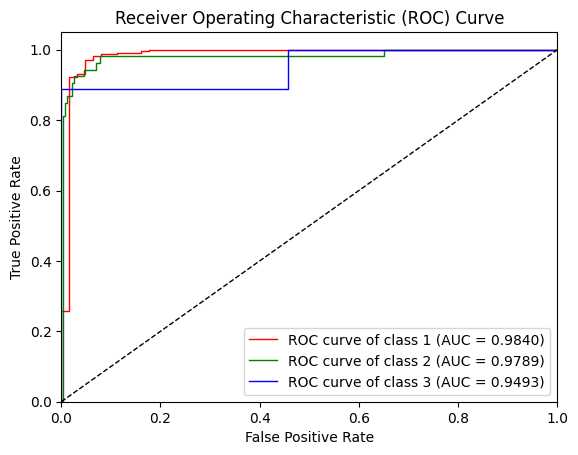

Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 0.6478 - auc: 0.9045
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5666 - auc: 0.9380
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5205 - auc: 0.9489
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4673 - auc: 0.9521
Epoch 5/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4120 - auc: 0.9599
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3618 - auc: 0.9688
Epoch 7/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3173 - auc: 0.9745
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.2819 - auc: 0.9781
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.2511 - auc: 0.9817
Epoch 10/25
92/92 [==============================] - 0s 5ms/step - loss: 0.2283 - auc: 0.9838
Epoch 11/25
92/92 [==============================] - 1s 5ms/step - lo

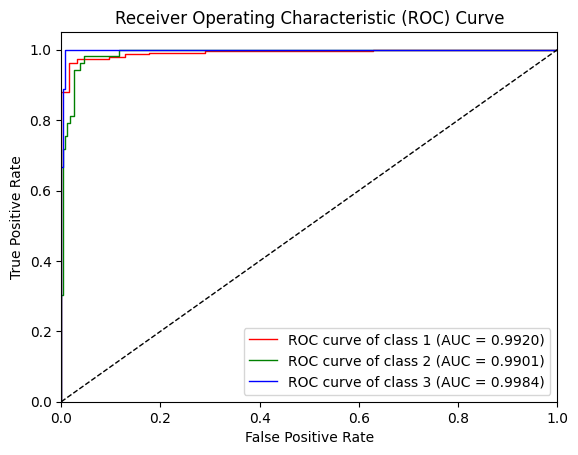

Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 0.8188 - auc: 0.8116
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5988 - auc: 0.8950
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5702 - auc: 0.9153
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5367 - auc: 0.9398
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4971 - auc: 0.9463
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4477 - auc: 0.9573
Epoch 7/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3951 - auc: 0.9660
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3495 - auc: 0.9708
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3067 - auc: 0.9757
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2749 - auc: 0.9787
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

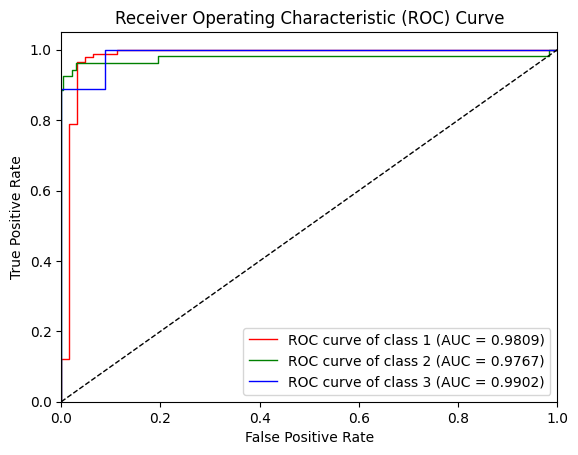

#########################################
Units: 16 Activation Function: tanh AUC Média: 0.9844322496065377
#########################################
Epoch 1/25
92/92 [==============================] - 3s 5ms/step - loss: 0.7873 - auc: 0.8647
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5524 - auc: 0.9311
Epoch 3/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5227 - auc: 0.9401
Epoch 4/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4984 - auc: 0.9457
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4692 - auc: 0.9482
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4396 - auc: 0.9524
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4117 - auc: 0.9575
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3814 - auc: 0.9625
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3536 - auc: 0.9673
Epoch 10/25
9

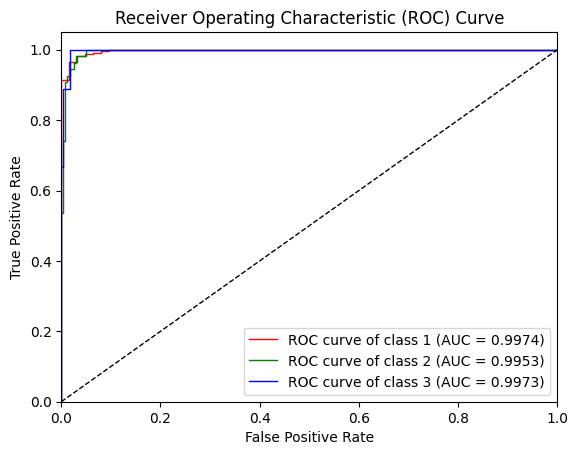

Epoch 1/25
92/92 [==============================] - 2s 6ms/step - loss: 0.6955 - auc: 0.8849
Epoch 2/25
92/92 [==============================] - 1s 5ms/step - loss: 0.5761 - auc: 0.9173
Epoch 3/25
92/92 [==============================] - 1s 6ms/step - loss: 0.5587 - auc: 0.9271
Epoch 4/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5384 - auc: 0.9342
Epoch 5/25
92/92 [==============================] - 1s 6ms/step - loss: 0.5128 - auc: 0.9414
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4809 - auc: 0.9487
Epoch 7/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4484 - auc: 0.9550
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4160 - auc: 0.9599
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3861 - auc: 0.9631
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3586 - auc: 0.9666
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

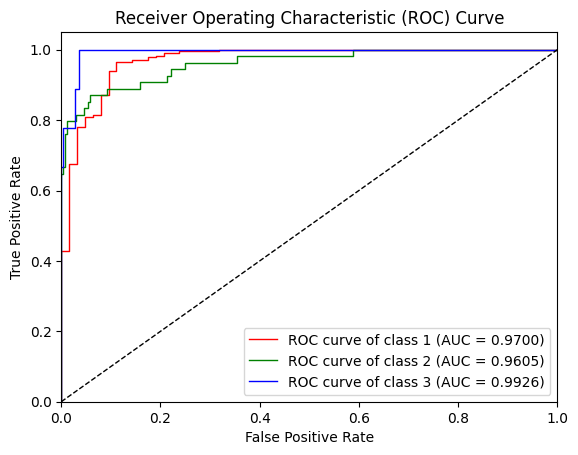

Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 1.0177 - auc: 0.6900
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6887 - auc: 0.8817
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5754 - auc: 0.9179
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5462 - auc: 0.9301
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5084 - auc: 0.9411
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4727 - auc: 0.9528
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4358 - auc: 0.9586
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4083 - auc: 0.9616
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3773 - auc: 0.9658
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3507 - auc: 0.9687
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

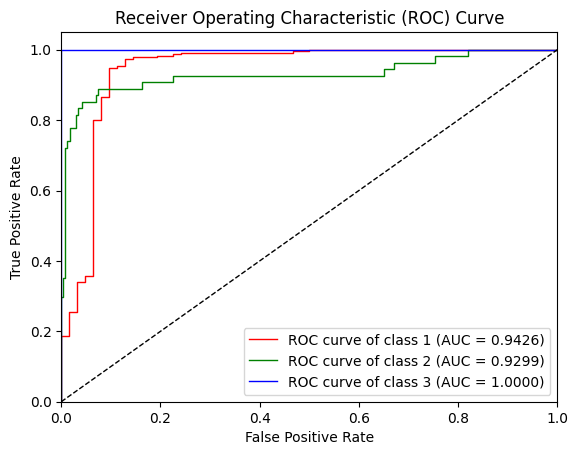

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.8271 - auc: 0.8141
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6464 - auc: 0.8673
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5980 - auc: 0.8953
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5721 - auc: 0.9087
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5507 - auc: 0.9205
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5336 - auc: 0.9276
Epoch 7/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5136 - auc: 0.9438
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4873 - auc: 0.9519
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4509 - auc: 0.9570
Epoch 10/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4160 - auc: 0.9616
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

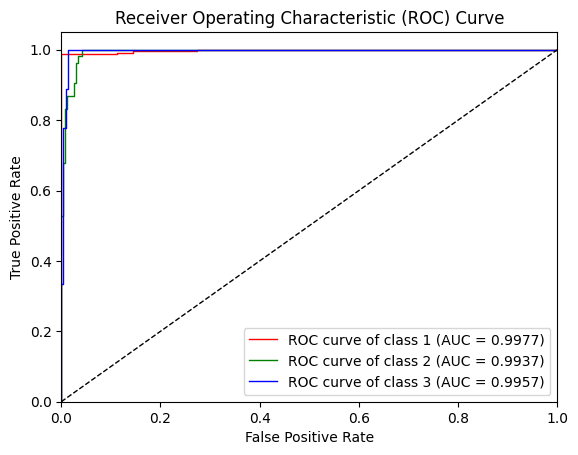

Epoch 1/25
92/92 [==============================] - 2s 6ms/step - loss: 0.7385 - auc: 0.8469
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5712 - auc: 0.9349
Epoch 3/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5238 - auc: 0.9499
Epoch 4/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4898 - auc: 0.9517
Epoch 5/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4554 - auc: 0.9567
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4222 - auc: 0.9632
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3922 - auc: 0.9659
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3636 - auc: 0.9692
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3362 - auc: 0.9729
Epoch 10/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3137 - auc: 0.9751
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

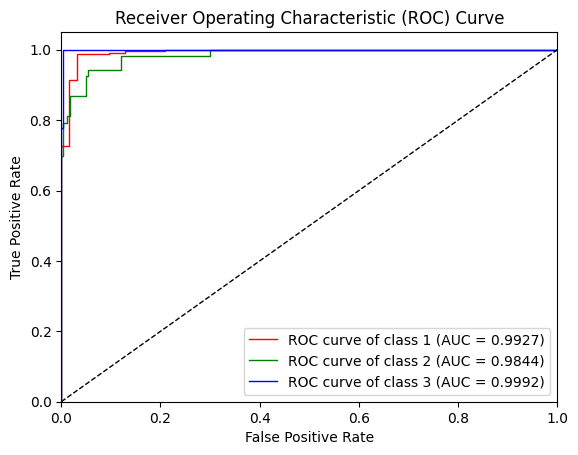

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.9961 - auc: 0.8414
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.7232 - auc: 0.8831
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6032 - auc: 0.9037
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5875 - auc: 0.9290
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5645 - auc: 0.9307
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5201 - auc: 0.9374
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4825 - auc: 0.9476
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4521 - auc: 0.9533
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4230 - auc: 0.9571
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3953 - auc: 0.9610
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

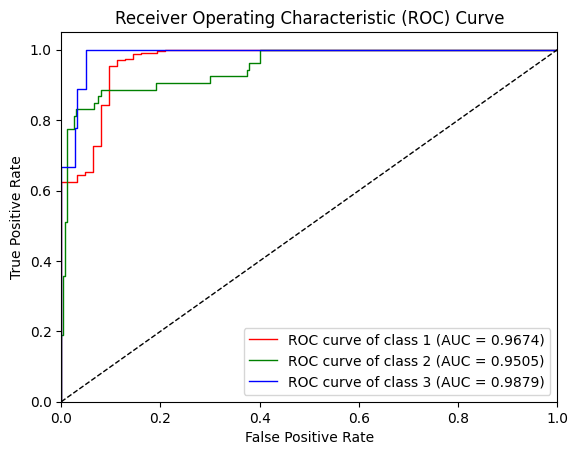

#########################################
Units: 14 Activation Function: relu AUC Média: 0.9808094865021784
#########################################
Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 1.3226 - auc: 0.1907
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 0.9116 - auc: 0.8379
Epoch 3/25
92/92 [==============================] - 0s 5ms/step - loss: 0.7460 - auc: 0.8608
Epoch 4/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6699 - auc: 0.8867
Epoch 5/25
92/92 [==============================] - 1s 6ms/step - loss: 0.6350 - auc: 0.8828
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6190 - auc: 0.8888
Epoch 7/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6114 - auc: 0.8894
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6073 - auc: 0.8873
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6040 - auc: 0.8989
Epoch 10/25
9

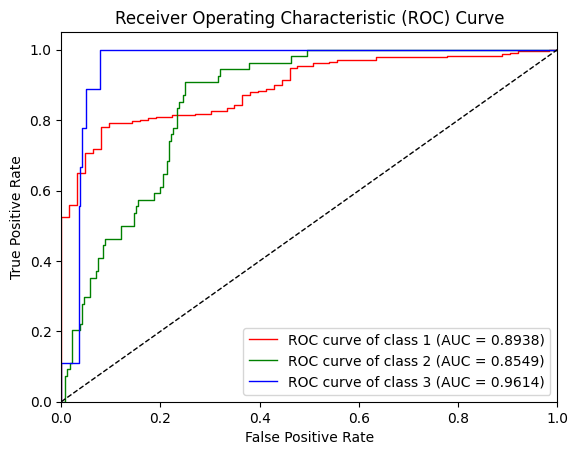

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 1.0994 - auc: 0.5756
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 0.7416 - auc: 0.8260
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6548 - auc: 0.8898
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6276 - auc: 0.8893
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6148 - auc: 0.9023
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6079 - auc: 0.9107
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6036 - auc: 0.9131
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6008 - auc: 0.9089
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5982 - auc: 0.9161
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5961 - auc: 0.9266
Epoch 11/25
92/92 [==============================] - 0s 5ms/step - lo

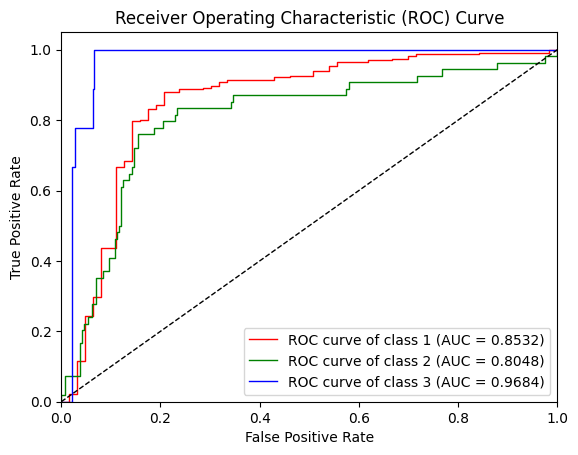

Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 0.9362 - auc: 0.8161
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6828 - auc: 0.8782
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6262 - auc: 0.8861
Epoch 4/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6122 - auc: 0.8901
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6065 - auc: 0.8992
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6038 - auc: 0.8957
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6019 - auc: 0.9118
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6006 - auc: 0.9041
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5998 - auc: 0.9081
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5978 - auc: 0.9198
Epoch 11/25
92/92 [==============================] - 0s 5ms/step - lo

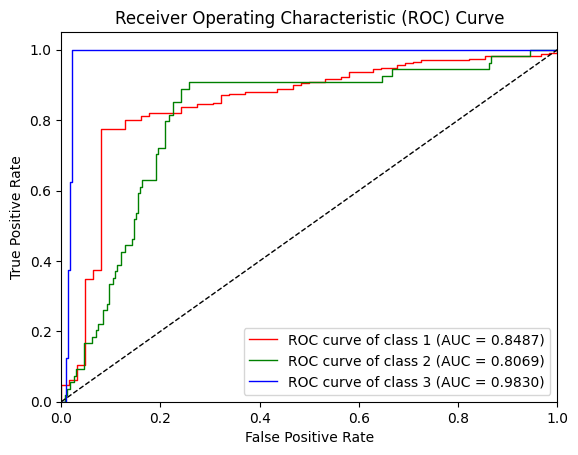

Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 1.0107 - auc: 0.6780
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 0.7013 - auc: 0.8377
Epoch 3/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6411 - auc: 0.8867
Epoch 4/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6202 - auc: 0.8939
Epoch 5/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6100 - auc: 0.9045
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6043 - auc: 0.9069
Epoch 7/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6003 - auc: 0.9127
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5972 - auc: 0.9150
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5944 - auc: 0.9203
Epoch 10/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5914 - auc: 0.9248
Epoch 11/25
92/92 [==============================] - 0s 5ms/step - lo

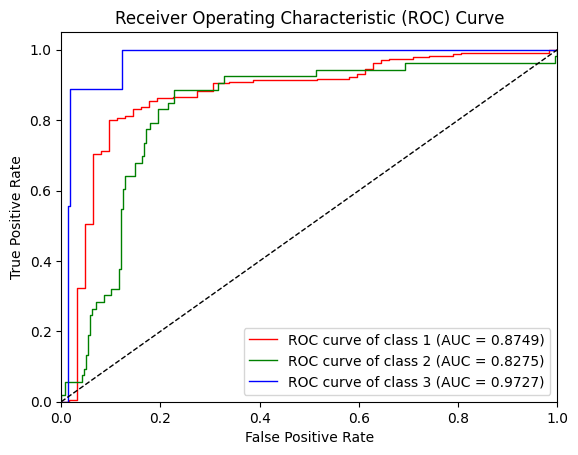

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 1.6420 - auc: 0.1836
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.9401 - auc: 0.8252
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.7110 - auc: 0.8755
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6509 - auc: 0.8796
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6290 - auc: 0.8859
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6182 - auc: 0.8894
Epoch 7/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6118 - auc: 0.8925
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6081 - auc: 0.8970
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6055 - auc: 0.8983
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6040 - auc: 0.8971
Epoch 11/25
92/92 [==============================] - 0s 5ms/step - lo

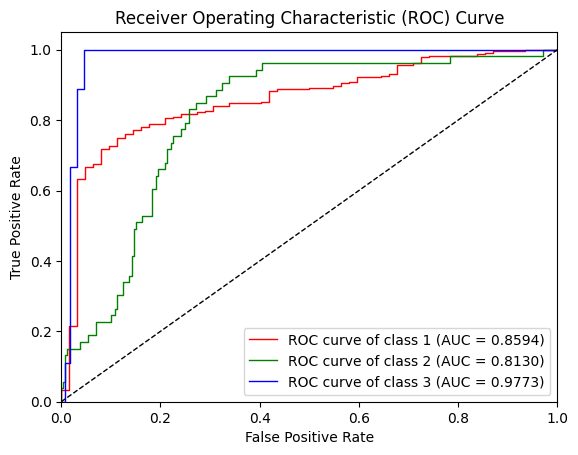

Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 1.2498 - auc: 0.3100
Epoch 2/25
92/92 [==============================] - 1s 6ms/step - loss: 0.8230 - auc: 0.8811
Epoch 3/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6904 - auc: 0.8772
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6438 - auc: 0.8734
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6244 - auc: 0.8810
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6154 - auc: 0.8796
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6103 - auc: 0.8813
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6073 - auc: 0.8849
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6057 - auc: 0.8815
Epoch 10/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6045 - auc: 0.8812
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

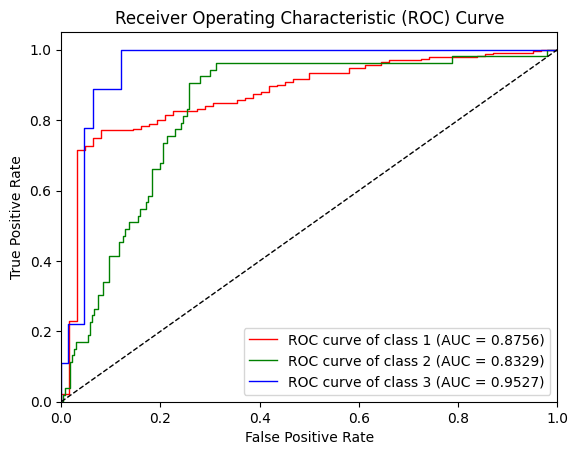

#########################################
Units: 14 Activation Function: sigmoid AUC Média: 0.8867221234235592
#########################################
Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 1.0590 - auc: 0.6379
Epoch 2/25
92/92 [==============================] - 1s 5ms/step - loss: 0.6217 - auc: 0.8883
Epoch 3/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5931 - auc: 0.9187
Epoch 4/25
92/92 [==============================] - 1s 6ms/step - loss: 0.5754 - auc: 0.9262
Epoch 5/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5522 - auc: 0.9399
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5262 - auc: 0.9396
Epoch 7/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4944 - auc: 0.9438
Epoch 8/25
92/92 [==============================] - 1s 6ms/step - loss: 0.4633 - auc: 0.9477
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4270 - auc: 0.9571
Epoch 10/2

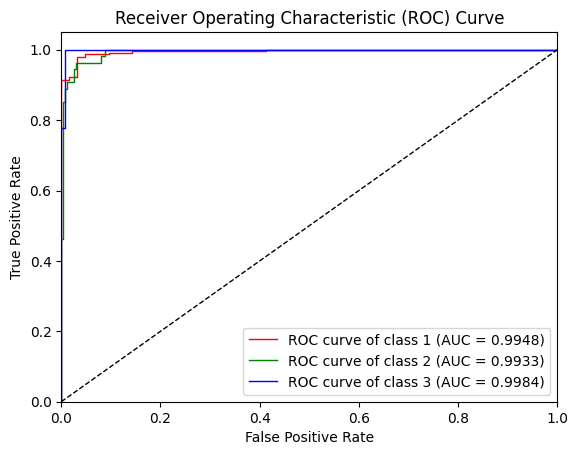

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.6620 - auc: 0.8831
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5567 - auc: 0.9349
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5133 - auc: 0.9446
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4738 - auc: 0.9494
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4349 - auc: 0.9575
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3975 - auc: 0.9632
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3619 - auc: 0.9676
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3305 - auc: 0.9711
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3028 - auc: 0.9748
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2791 - auc: 0.9772
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

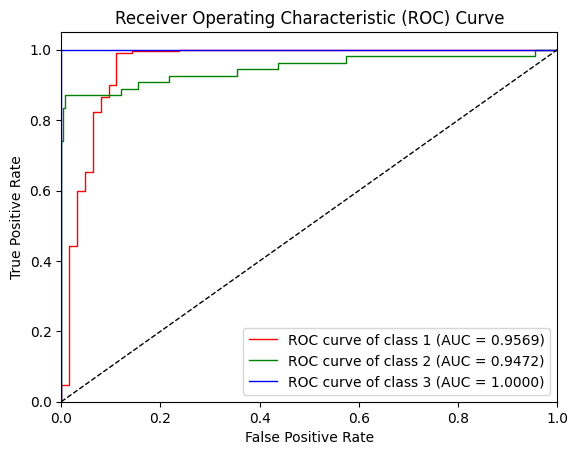

Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 0.8321 - auc: 0.8290
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6250 - auc: 0.9050
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5824 - auc: 0.9200
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5544 - auc: 0.9326
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5218 - auc: 0.9422
Epoch 6/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4843 - auc: 0.9503
Epoch 7/25
92/92 [==============================] - 0s 4ms/step - loss: 0.4422 - auc: 0.9551
Epoch 8/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3992 - auc: 0.9613
Epoch 9/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3543 - auc: 0.9691
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3134 - auc: 0.9757
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

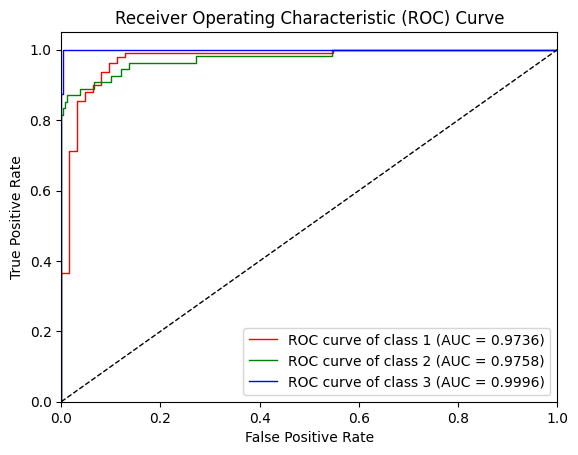

Epoch 1/25
92/92 [==============================] - 2s 5ms/step - loss: 0.7616 - auc: 0.8511
Epoch 2/25
92/92 [==============================] - 0s 5ms/step - loss: 0.6235 - auc: 0.8814
Epoch 3/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5923 - auc: 0.9189
Epoch 4/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5566 - auc: 0.9381
Epoch 5/25
92/92 [==============================] - 0s 5ms/step - loss: 0.5195 - auc: 0.9453
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4765 - auc: 0.9501
Epoch 7/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4282 - auc: 0.9620
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3780 - auc: 0.9688
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3368 - auc: 0.9728
Epoch 10/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3007 - auc: 0.9761
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

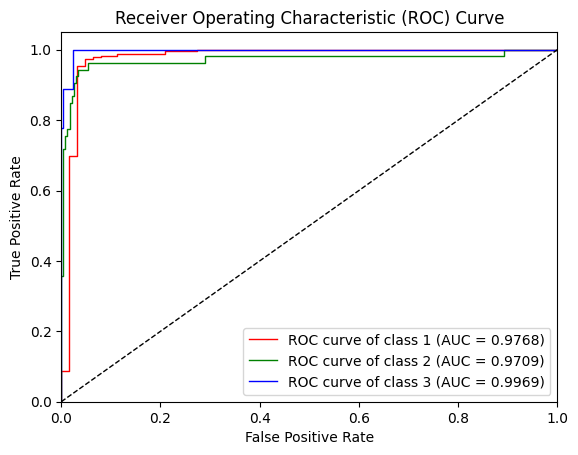

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.6426 - auc: 0.8918
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5645 - auc: 0.9376
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5279 - auc: 0.9419
Epoch 4/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4860 - auc: 0.9467
Epoch 5/25
92/92 [==============================] - 1s 5ms/step - loss: 0.4389 - auc: 0.9578
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3967 - auc: 0.9622
Epoch 7/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3547 - auc: 0.9681
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3215 - auc: 0.9720
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.2943 - auc: 0.9753
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.2761 - auc: 0.9774
Epoch 11/25
92/92 [==============================] - 0s 5ms/step - lo

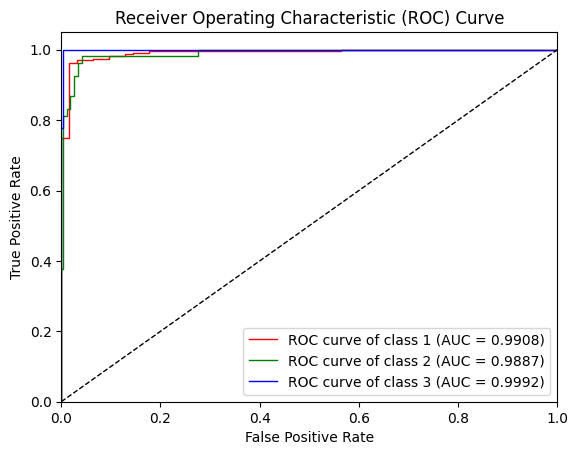

Epoch 1/25
92/92 [==============================] - 2s 4ms/step - loss: 0.9033 - auc: 0.7578
Epoch 2/25
92/92 [==============================] - 0s 4ms/step - loss: 0.6357 - auc: 0.8730
Epoch 3/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5909 - auc: 0.9140
Epoch 4/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5586 - auc: 0.9357
Epoch 5/25
92/92 [==============================] - 0s 4ms/step - loss: 0.5306 - auc: 0.9363
Epoch 6/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4950 - auc: 0.9484
Epoch 7/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4608 - auc: 0.9554
Epoch 8/25
92/92 [==============================] - 0s 5ms/step - loss: 0.4256 - auc: 0.9594
Epoch 9/25
92/92 [==============================] - 0s 5ms/step - loss: 0.3947 - auc: 0.9624
Epoch 10/25
92/92 [==============================] - 0s 4ms/step - loss: 0.3621 - auc: 0.9664
Epoch 11/25
92/92 [==============================] - 0s 4ms/step - lo

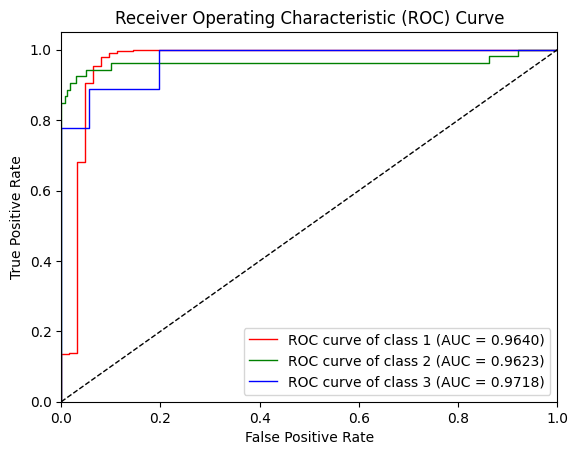

#########################################
Units: 14 Activation Function: tanh AUC Média: 0.9811699642524032
#########################################


In [ ]:
dados = X
rotulos = y
# Definir o número de folds para a validação cruzada
k = 6

lw = 1

# inicializar a lista para armazenar os tempos de treinamento
training_times = []

Probabilidades = []
Agrega_Resultado = []

# Criar o objeto para realizar a validação cruzada k-fold estratificado
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

#Parametros de Busca
activation_funcs = [relu, sigmoid, tanh]
units_list = [20, 18, 16, 14]

# Loop para treinar e avaliar o modelo em cada fold
for units in units_list:
    for activation_func in activation_funcs:
        for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):

            # Separar os dados em treino e teste para o fold atual
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # converte rótulos para formato one-hot encoding
            y_train = to_categorical(y_train, num_classes=3)
            y_test = to_categorical(y_test, num_classes=3)

            model = []
            del model

            #Construção do modelo
            model = Sequential()
            model.add(Dense(units=units, input_dim=13, activation=activation_func))
            model.add(Dense(units=units/2, activation=activation_func))
            model.add(Dense(units=3, activation='softmax'))

            # Compilar o modelo
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['AUC'])

            # armazenar o tempo de início do treinamento
            start_time = time.time()

            # Treinar o modelo com os dados de treino do fold atual
            model.fit(X_train, y_train, batch_size=16, epochs=25)

            # armazenar o tempo de fim do treinamento
            end_time = time.time()

            # calcular o tempo de treinamento em segundos
            training_time = end_time - start_time

            # armazenar o tempo de treinamento na lista
            training_times.append(training_time)

            y_proba = model.predict(X_test)

            Probabilidades.append(y_proba)

            # Converter previsões em classes
            y_pred_classes = np.argmax(y_proba, axis=1)

            # Converter rótulos de teste em classes
            y_true = np.argmax(y_test, axis=1)
            y_true_treino = np.argmax(y_train, axis=1)
            cm = confusion_matrix(y_true, y_pred_classes)

            print(f"Fold {fold_idx + 1}: {len(X_train)} Amostras de Treino ({len(np.where(y_true_treino == 0)[0])} Arritimia (1), {len(np.where(y_true_treino == 1)[0])} Arritimia (2), {len(np.where(y_true_treino == 2)[0])} Arritimia (3) e {len(np.where(y_true_treino == 3)[0])} Arritimia (4))")
            print(f"Fold {fold_idx + 1}: {len(X_test)} Amostras de Teste ({len(np.where(y_true == 0)[0])} Arritimia (1), {len(np.where(y_true == 1)[0])} Arritimia (2), {len(np.where(y_true == 2)[0])} Arritimia (3) e {len(np.where(y_true == 3)[0])} Arritimia (4))")

            # Exibir informações sobre os dados de treino e teste do fold atual
            print(f"Fold {fold_idx + 1}: Tempo Treinamento = {training_time:.4f}")
            print("______________")
            print(f"Fold {fold_idx + 1} - Matriz de Confusão")
            print(cm)
            print("______________")

            n_classes = y_test.shape[1]
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            AUC_M = []
            for i in range(n_classes):
              fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_proba[:, i])

              roc_auc[i] = auc(fpr[i], tpr[i])
              print(f"Fold {fold_idx + 1}: AUC classe {i+1} = {roc_auc[i]:.4f}")
              AUC_M.append(roc_auc[i])

            mean_auc = np.mean(AUC_M)
            print(f"Fold {fold_idx + 1}: AUC Média = {mean_auc:.4f}")
            print("______________")

            Agrega_Resultado.append(mean_auc)

            # plotar as curvas ROC
            plt.figure()
            colors = ['red', 'green', 'blue', 'orange']
            for i, color in zip(range(n_classes), colors):
              plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                      label='ROC curve of class {0} (AUC = {1:0.4f})'
                    ''.format(i+1, roc_auc[i]))
            plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc="lower right")
            plt.show()

        Res_Fold_Médio = np.mean(Agrega_Resultado)
        Agrega_Resultado = []
        # Resultado
        print('#########################################')
        print('Units:', units, 'Activation Function:', activation_func.__name__, 'AUC Média:', Res_Fold_Médio)
        print('#########################################')


        # Redireciona a saída de impressão para a saída padrão novamente

# E N T R E N A M I E N T O

In [14]:
#np.random.seed(23)

dim_entrada = X.shape[1]
entrada = Input(shape=(dim_entrada,))

print(X.shape[1])
x = Dense(18, activation='relu')(entrada)
saida = Dense(3, activation='softmax')(x)
clasificador = Model(inputs=entrada, outputs=saida)
clasificador.summary()

13
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense (Dense)               (None, 18)                252       
                                                                 
 dense_1 (Dense)             (None, 3)                 57        
                                                                 
Total params: 309 (1.21 KB)
Trainable params: 309 (1.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Implementando Validación Cruzada Estratificada y Clasificación

In [15]:
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

Definimos la configuracipon de Validacipon Cruzada estratificada y luego el modelo de clasificación:

# Retomando Alternativa inicial de LPC

StratifiedShuffleSplit(n_splits=6, random_state=True, test_size=None,
            train_size=None)
TRAIN: [ 803  836  974 ... 1658 1122  902] TEST: [1125 1207 1539  801   93 1677  329 1252 1616  187  181  749  440  233
  583  626  170  207  586 1048  385  705  617  717  643 1699  821  880
  786 1254 1073 1700  873  587 1588  342 1257  957 1163  921  894 1565
 1298  395  922  220  173 1756  380 1685  360  635 1004 1295 1498  648
 1530 1110  679  926  904  267  678 1329  392  602  612  156  784  650
  814  326 1581   21  842 1634 1117 1723 1533  302 1603 1089  877  794
  955   26  169 1277 1729  332  737   71 1664  790 1394  463 1656 1201
 1317  405 1145  938  496 1697  256  506  343  779  184  953  537 1337
  198  766 1375  115  311  213 1651  235 1374  772 1393  738  716 1131
  575 1716 1561  122 1509  522 1617  709 1657  442  667 1366  565 1526
  155 1071 1457 1316  638  393 1465 1654 1379 1633  291 1256 1703 1325
 1406  762 1628 1444 1097  389  255 1137  730  989 1620 1168 1480 1303


TRAIN: [1074 1175 1104 ... 1400  448 1443] TEST: [1426 1436 1313   32  328  871  778 1048  287  810  285 1206 1489 1347
  323 1605 1450  165 1324  300  819  151 1051 1327   13  243 1289 1316
 1576  738  736 1143 1002  627  700  139 1093 1193  317  826 1661   44
 1158  159 1417 1715  531  683 1631  526  449  500  759 1176 1721  599
  941  467  511 1325 1615 1451 1365 1174  420  434  913 1028 1102  792
  210  167  223  920 1299   63  373   88 1146 1415  516  614  606 1449
 1271  400  579 1246  881  114 1757  582 1625   70  353 1464  779 1334
  761  491  628  313  498  769  465  520 1623  834  368  969  917  932
  541  316  921 1534  869 1733 1389  282  694 1690 1497  575  715 1598
  847  122 1000 1593 1683  718  950 1393  176  490  934  568 1381 1132
 1696  192  615 1031 1720 1759   42 1750  462   28 1481  910  106 1188
  897 1553  618 1647  898  911 1332 1027  980 1052 1101  641  156 1015
 1380  336 1502  417   67 1382 1419  943 1379]
Epoch 1/25
106/106 [==============================] 

TRAIN: [1387 1438  108 ...  907  191  382] TEST: [  71  503  886  532   49  591 1249  695 1320 1761  410  580  640 1209
 1468  893  962  576 1311 1443  517  892 1226 1228 1654 1368 1166 1308
  766 1432  866  627 1526 1036  809 1211  789  451 1116 1576 1403 1690
  384  208 1515 1710 1328   68  634  197  448  840  104 1404  284  357
 1529  865  565 1528 1692 1002  867  278 1549  703  222 1457  736  204
 1516  617 1487  248  838 1273 1502  511  466 1484  229  742  285    7
  242 1474  112  146 1329  254 1014 1711  994 1271  158 1061  699 1246
 1577  531 1500  189 1064 1635 1538 1445  172 1518  791 1345 1562 1665
    9   52 1350 1415  342  160  438 1181  904 1408  895  564  163  928
 1575  148  477  916  763  754 1656 1353 1605 1546  834 1709  803  821
 1086 1680 1239 1214  601  343 1683  481  845 1091 1388 1299 1213 1745
   28  398 1364 1024 1133 1057 1029 1090  128   78  328  554 1661    3
  153  537  162  777 1423   84  213 1541 1553]
Epoch 1/25
106/106 [==============================] 

TRAIN: [1068  345  828 ...  578  658 1475] TEST: [ 433   83  290  902 1115  394    2  284  726  813 1019 1545   72  593
  274 1013  381 1608 1725 1607 1563  695  676  675  240 1578 1273 1414
 1387 1350 1610  638 1057  191  552   80  250  822  965 1492  468 1114
  306  611   84 1051 1131 1457  890 1435  609   24  259 1137 1160  523
  688  496   76 1667  512 1083  579  137  170 1517  639  415  717 1761
  697 1124 1327  731  272 1024 1358  938 1437 1756 1464  227 1573 1748
  961  834  198  374 1357 1386 1306 1236   90 1337  767  615 1410  701
  380  857  653  517 1565  190   30 1394  196  304 1552  709  462 1274
  712  724  795 1606 1403  410 1433  851 1164  256  665  669 1714  714
  400  564 1753  168 1650  539  831 1558 1101 1389  543  486 1527 1333
  845 1442 1172  514 1265 1310 1035 1559 1363  493 1291 1217 1305  859
  438 1280 1461  700  153 1079  254 1171 1328 1645  371  893 1084 1685
  772 1117  211  898   34 1102 1540  594    5]
Epoch 1/25
106/106 [==============================] 

TRAIN: [ 893  263 1104 ...  215 1041   96] TEST: [1605  852 1156 1581  779 1709  256  403  435 1534  778 1526  886 1199
 1669 1378  154 1718  707 1600  592 1690  991 1649  519  489   37  380
 1754 1346  313 1571  221  506  526 1270  815  810 1632 1550 1032 1012
  214  270 1195 1184  685 1675 1260 1348 1538  224  337  298  366  261
  705  734  990  631  675 1087  851  114 1548   73 1408  102 1713 1131
 1693 1400   26 1683 1406 1436  497   24 1109  673  981 1329  319  424
 1285   52 1364  662 1116  138 1505  109  183  986  832  229 1359  798
  610 1351 1046  307  542   17  374  343 1523  454 1622  458 1140 1463
  786  481  483  218  614 1010 1437  471 1004 1157  211  362 1241  176
  696  864 1452 1350  400  217 1477   46  620  828 1533 1660  604 1069
  914  718  806   75  664 1042 1661  540  474  956  647  627 1324  531
 1307   64 1594 1369 1248  293  373  928  563 1575  299  623  557  824
 1071  234  712  689  522 1092  513  407  242]
Epoch 1/25
106/106 [==============================] 

TRAIN: [1106 1320  966 ... 1745  602 1674] TEST: [ 327  501 1369 1423 1487 1092  703  849 1036  946  724 1445 1080  129
 1169 1031 1160 1307  426  554  881  764  355  612 1439 1137  515  540
  978  830  558 1358 1499 1574 1282  670  450  342  485  118  971   31
 1248  621  765 1708 1620  179 1216 1607 1647  151  530 1718 1686  484
  553  434 1725  294 1513  528 1147  328  985 1081  449  796 1000  716
  307  378 1317  938  963 1151 1628 1481 1518 1208 1039  572 1429  421
 1279 1198 1530 1571  295 1272 1324  292  406  240  991 1598  301 1062
  103 1293  503  250  773 1228  681  235  942  278 1665 1068 1185  932
  413  524 1554  389  699  838 1452  899  210  845   62 1589  925  609
  988  576  746  428  487  368  563  996  396 1130  791  473  443  804
  265  934 1543  425   34 1003  709 1267 1240 1558  341  542 1585 1371
 1432  556 1699 1117  661 1477 1503  231  756  370 1017  430  139  518
 1065  834 1619 1052  241 1310  589  207 1179]
Epoch 1/25
106/106 [==============================] 

train -  [1248  289   48]   |   test -  [140  32   5]
train -  [1248  289   48]   |   test -  [140  32   5]
train -  [1248  289   48]   |   test -  [140  32   5]
train -  [1248  289   48]   |   test -  [140  32   5]
train -  [1248  289   48]   |   test -  [140  32   5]
train -  [1248  289   48]   |   test -  [140  32   5]


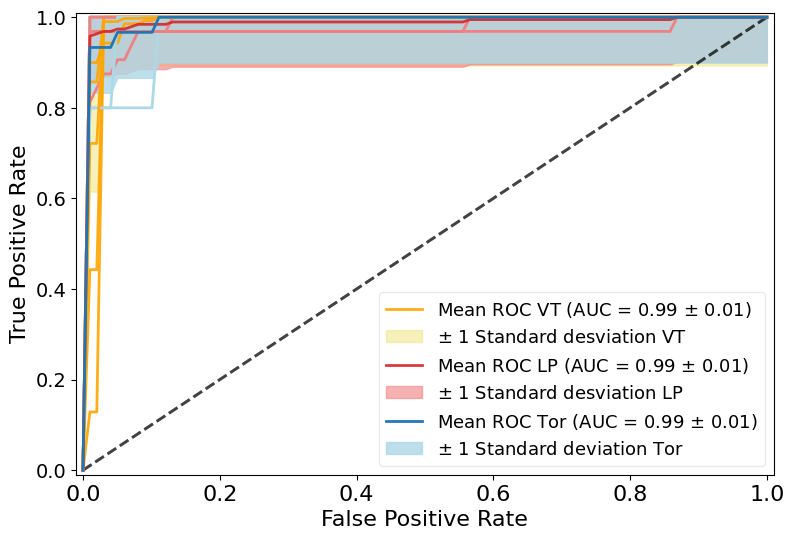

<Figure size 600x600 with 0 Axes>

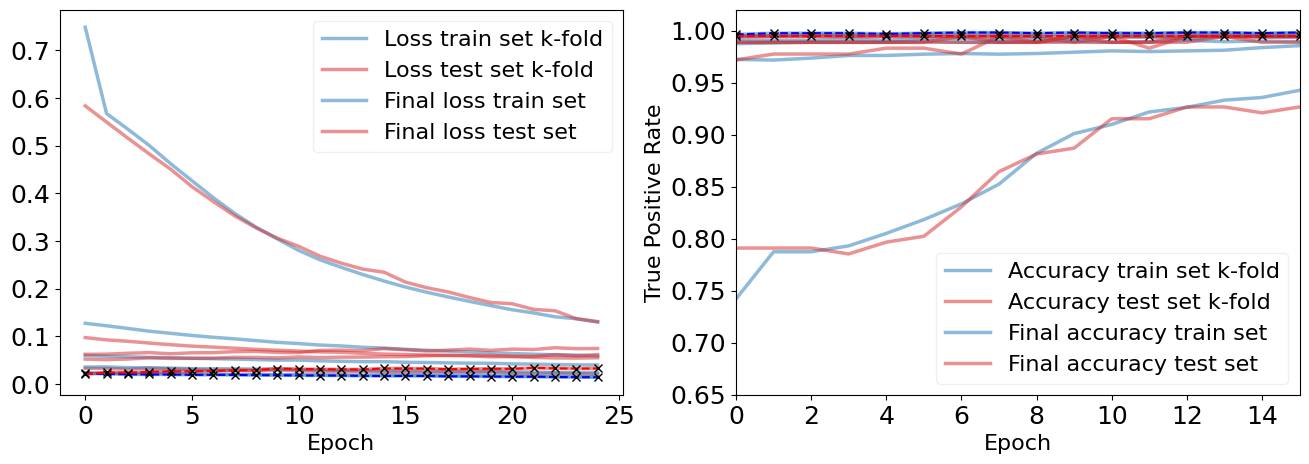

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

cv = StratifiedShuffleSplit(n_splits=6, random_state=True)
th_0 = []
th_1 = []
th_2 = []

y = np.round(y).astype(int)

print(cv)
StratifiedShuffleSplit(n_splits=6, random_state=True)

fig, ax = plt.subplots(1, figsize = (9, 6))
tprs_mean_0 = []
tprs_mean_1 = []
tprs_mean_2 = []
aucs_0 = []
aucs_1 = []
aucs_2 = []

corte0 = []
corte1 = []
corte2 = []
fold = 1

for train_index, test_index in cv.split(X, y):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  # converte rótulos para formato one-hot encoding
  y_train = to_categorical(y_train, num_classes=3)
  y_test = to_categorical(y_test, num_classes=3)

  clasificador = Model(inputs=entrada, outputs=saida)
  clasificador.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy', 'AUC'])
  # armazenar o tempo de início do treinamento
  time
  start_time = time.time()
  historia = clasificador.fit(X_train, y_train,
                           epochs=25,
                           batch_size=15,
                           validation_data=(X_test, y_test),
                           shuffle=True)
  # armazenar o tempo de fim do treinamento
  end_time = time.time()

  print("ENTRENAMIENTO EN EL FOLD %0.2f" %(fold))
  y_pred = clasificador.predict(X_test)

  tprs = []
  Corte = []
  thresholds = []

  base_fpr = np.linspace(0, 1, 101)
  mean_fpr = np.linspace(0, 1, 100)


  #Curva ROC para la clase VT

  for i in range(len(y_pred)):
    fpr, tpr, th = roc_curve(y_test[:, 0],  y_pred[:,0])
    auc1 = roc_auc_score(y_test[:, 0], y_pred[:, 0])

    # Elegir el umbral óptimo basado en una métrica (por ejemplo, F1-score)
    f1_scores = 2 * (tpr * (1 - fpr)) / (tpr + (1 - fpr))
    best_threshold = th[np.argmax(f1_scores)]

  interp_tpr = np.interp(mean_fpr, fpr, tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)
  aucs_0.append(auc1)
  th_0.append(best_threshold)  ##################################################################################

  Corte.append(th[np.argmax(tpr - fpr)])
  corte0.append(Corte)  #########################################################################################
  ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="k",
          alpha=0.2)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  ax.plot(
      mean_fpr,
      mean_tpr,
      color="orange",
      lw=2,
      alpha=0.9,
  )
  tprs_mean_0.append(mean_tpr)

  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.ylabel('True Positive Rate', fontsize=16)
  plt.xlabel('False Positive Rate', fontsize=16)


  #Curva ROC para la clase LP

  tprs = []
  for i in range(len(y_pred)):
    fpr, tpr, th = roc_curve(y_test[:, 1],  y_pred[:, 1])
    auc1 = roc_auc_score(y_test[:, 1], y_pred[:, 1])

    # Elegir el umbral óptimo basado en una métrica (por ejemplo, F1-score)
    f1_scores = 2 * (tpr * (1 - fpr)) / (tpr + (1 - fpr))
    best_threshold = th[np.argmax(f1_scores)]

  interp_tpr = np.interp(mean_fpr, fpr, tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)
  aucs_1.append(auc1)
  th_1.append(best_threshold) ##################################################################################

  Corte.append(th[np.argmax(tpr - fpr)])
  corte1.append(Corte)  ########################################################################################

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  ax.plot(
      mean_fpr,
      mean_tpr,
      color="lightcoral",
      lw=2,
      alpha=0.99, # alpha es transparencia
  )
  tprs_mean_1.append(mean_tpr)

  #Curva ROC para la clase Tor

  tprs = []
  for i in range(len(y_pred)):
    fpr, tpr, th = roc_curve(y_test[:, 2],  y_pred[:, 2])
    auc1 = roc_auc_score(y_test[:, 2], y_pred[:, 2])

    # Elegir el umbral óptimo basado en una métrica (por ejemplo, F1-score)
    f1_scores = 2 * (tpr * (1 - fpr)) / (tpr + (1 - fpr))
    best_threshold = th[np.argmax(f1_scores)]

  interp_tpr = np.interp(mean_fpr, fpr, tpr)
  interp_tpr[0] = 0.0
  tprs.append(interp_tpr)
  aucs_2.append(auc1)
  th_2.append(best_threshold) ##################################################################################

  Corte.append(th[np.argmax(tpr - fpr)])
  corte2.append(Corte)  ########################################################################################

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  ax.plot(
      mean_fpr,
      mean_tpr,
      color="lightblue",
      lw=2,
  )

  tprs_mean_2.append(mean_tpr)
  ax.legend(loc="lower right",fontsize = 8)
  plt.xticks(fontsize=16), plt.yticks(fontsize=14)


  import matplotlib.pyplot as plt
  plt.figure(5, figsize=(16,5))
  plt.subplot(1,2,1)
  plt.plot(historia.history["loss"], color = 'tab:blue', alpha = 0.5, lw = 2.5)   #label="Pérdida train (Fold %0.2f)" %(fold)
  plt.plot(historia.history["val_loss"], color = 'tab:red', alpha = 0.5, lw = 2.5)
  plt.subplot(1,2,2)
  plt.plot(historia.history["categorical_accuracy"], color = 'tab:blue', alpha = 0.5, lw = 2.5)
  plt.plot(historia.history["val_categorical_accuracy"], color = 'tab:red', alpha = 0.5, lw = 2.5)

  fold = fold + 1

for train, test in cv.split(X, y):
  print('train -  {}   |   test -  {}'.format(
      np.bincount(y[train]), np.bincount(y[test])))

plt.figure(3, figsize=(6,6))
tpr_0_final = np.mean(tprs_mean_0, axis=0)
std_tpr_0 = np.std(tpr_0_final, axis=0)
tprs_upper_0 = np.minimum(tpr_0_final + std_tpr_0, 1)
tprs_lower_0 = np.maximum(tpr_0_final - std_tpr_0, 0)

tpr_0_final[-1] = 1.0
mean_auc_0 = auc(mean_fpr, tpr_0_final)
std_auc_0 = np.std(aucs_0)
ax.plot(
    mean_fpr,
    tpr_0_final,
    color="orange",
    label=r"Mean ROC VT (AUC = %0.2f $\pm$ %0.2f)" %(mean_auc_0, std_auc_0),
    lw=2,
    alpha=0.9,
)
ax.fill_between(
    mean_fpr,
    tprs_lower_0,
    tprs_upper_0,
    color="khaki",
    alpha=0.6,
    label="$\pm$ 1 Standard desviation VT",
)

tpr_1_final = np.mean(tprs_mean_1, axis=0)
std_tpr_1 = np.std(tpr_1_final, axis=0)
tprs_upper_1 = np.minimum(tpr_1_final + std_tpr_1, 1)
tprs_lower_1 = np.maximum(tpr_1_final - std_tpr_1, 0)

tpr_1_final[-1] = 1.0
mean_auc_1 = auc(mean_fpr, tpr_0_final)
std_auc_1 = np.std(aucs_1)
ax.plot(
    mean_fpr,
    tpr_1_final,
    color="tab:red",
    label=r"Mean ROC LP (AUC = %0.2f $\pm$ %0.2f)" %(mean_auc_1, std_auc_1),
    lw=2,
    alpha=0.9,
)
ax.fill_between(
    mean_fpr,
    tprs_lower_1,
    tprs_upper_1,
    color="lightcoral",
    alpha=0.6,
    label="$\pm$ 1 Standard desviation LP",
)

tpr_2_final = np.mean(tprs_mean_2, axis=0)
std_tpr_2 = np.std(tpr_2_final, axis=0)
tprs_upper_2 = np.minimum(tpr_2_final + std_tpr_2, 1)
tprs_lower_2 = np.maximum(tpr_2_final - std_tpr_2, 0)

tpr_2_final[-1] = 1.0
mean_auc_2 = auc(mean_fpr, tpr_2_final)
std_auc_2 = np.std(aucs_2)
ax.plot(
    mean_fpr,
    tpr_2_final,
    color="tab:blue",
    label=r"Mean ROC Tor (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc_2, std_auc_2),
    lw=2,
    alpha=0.99,
)
ax.fill_between(
    mean_fpr,
    tprs_lower_2,
    tprs_upper_2,
    color="lightblue",
    alpha=0.8,
    label=r"$\pm$ 1 Standard deviation Tor",
)

ax.legend(loc="lower right",fontsize = 13, fancybox=True, framealpha=0.4)

ax.figure.savefig('ROC_PCA3.pdf', dpi=400, format='pdf')


plt.figure(5, figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(historia.history["loss"], 'xb--',mec='k', lw=1.5)
plt.plot(historia.history["val_loss"], 'xr--',mec='k', lw=1.5)
plt.xlabel('Epoch', fontsize=16)
plt.xticks(fontsize=18), plt.yticks(fontsize=18)
plt.legend(labels=["Loss train set k-fold",
                   "Loss test set k-fold",
                   "Final loss train set",
                   "Final loss test set"],
           fontsize='16', fancybox=True, framealpha=0.3)
plt.subplot(1,2,2)
plt.plot(historia.history["categorical_accuracy"], 'xb--',mec='k', lw=1.5)
plt.plot(historia.history["val_categorical_accuracy"], 'xr--',mec='k', lw=1.5)
plt.xlim(0, 15)
plt.ylim(0.65, 1.02)
plt.xlabel('Epoch', fontsize=16)
plt.legend(labels=["Accuracy train set k-fold",
                   "Accuracy test set k-fold",
                   "Final accuracy train set",
                   "Final accuracy test set"],
           fontsize='16', fancybox=True, loc='lower right', framealpha=0.3)
plt.xticks(fontsize=18), plt.yticks(fontsize=18)

plt.savefig('CrossVall_PCA.pdf', dpi=400, format='pdf')

Gráfico de umbrales que se generaron durante el cálculo de la curva ROC

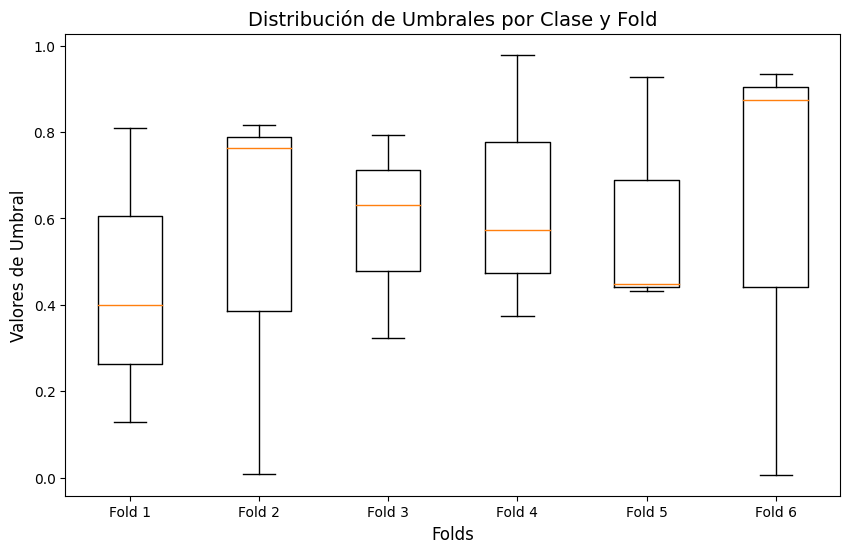

In [17]:
import seaborn as sns
# Clases y etiquetas para los boxplots
clases = ['Clase VT', 'Clase LP', 'Clase TOR']
etiquetas = [f'Fold {i+1}' for i in range(len(corte0))]
data = np.array(corte0)
# Crear el boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data.T, labels=etiquetas)
plt.xlabel('Folds', fontsize=12)
plt.ylabel('Valores de Umbral', fontsize=12)
plt.title('Distribución de Umbrales por Clase y Fold', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Gráfica con la tendencia de los umbrales

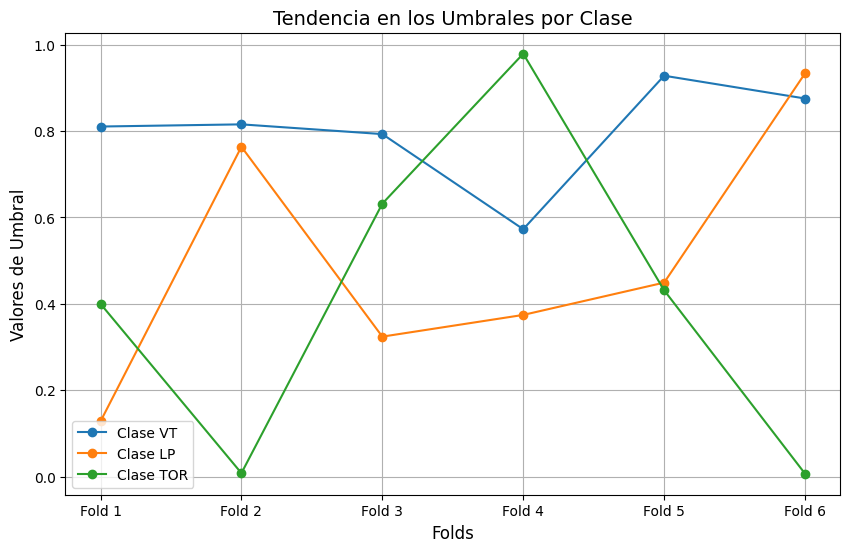

In [18]:
# Umbrales por clase y fold (como listas de listas)
umbrales_clase_VT = [fila[0] for fila in corte0]
umbrales_clase_LP = [fila[1] for fila in corte0]
umbrales_clase_Tor = [fila[2] for fila in corte0]

# Valores de los folds (etiquetas)
folds = [f'Fold {i+1}' for i in range(len(umbrales_clase_VT))]

# Crear gráfico de líneas para mostrar tendencia
plt.figure(figsize=(10, 6))
plt.plot(folds, umbrales_clase_VT, marker='o', label='Clase VT')
plt.plot(folds, umbrales_clase_LP, marker='o', label='Clase LP')
plt.plot(folds, umbrales_clase_Tor, marker='o', label='Clase TOR')
plt.xlabel('Folds', fontsize=12)
plt.ylabel('Valores de Umbral', fontsize=12)
plt.title('Tendencia en los Umbrales por Clase', fontsize=14)
plt.legend(loc='lower left', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()

Gráfico umbrales para *f1-score* por clase, para ver la distribución de los umbrales en los diferentes folds.

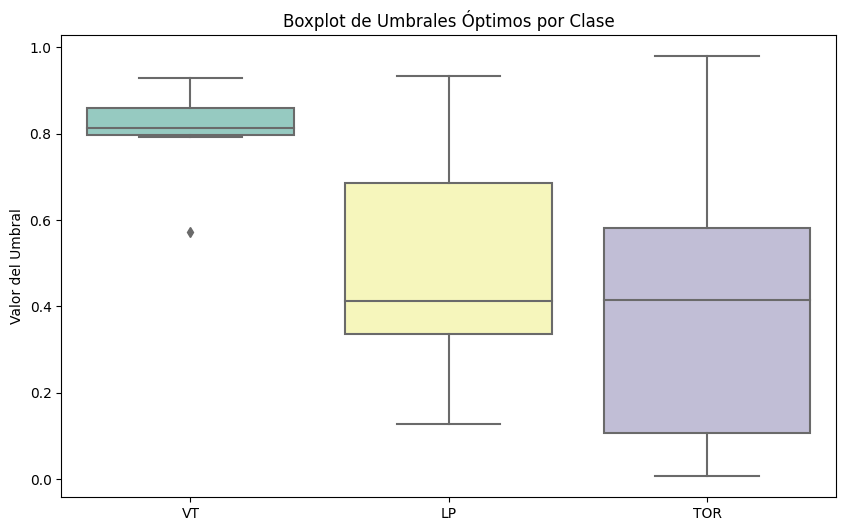

In [19]:
# Crear un DataFrame de pandas para facilitar la visualización

data = pd.DataFrame({'VT': th_0, 'LP': th_1, 'TOR': th_2})

# Crear el gráfico de boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, palette='Set3')
plt.title('Boxplot de Umbrales Óptimos por Clase')
plt.ylabel('Valor del Umbral')
plt.show()

Resumen gráfico para obtener uma vista global del valor de los umbrales durante los 6 folds.

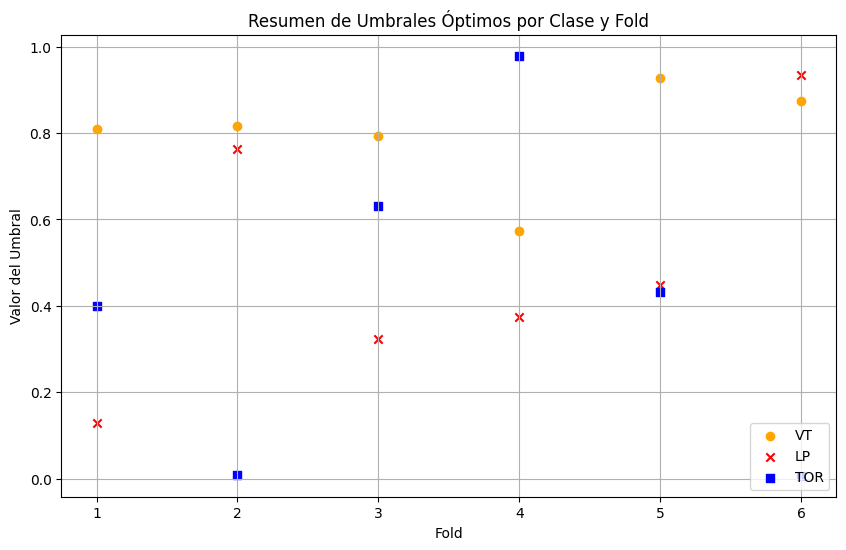

In [20]:
# Crear una figura para el resumen gráfico
plt.figure(figsize=(10, 6))

# Crear un gráfico de dispersión para cada clase
plt.scatter(range(1, 7), th_0, marker='o', label='VT', color='orange')
plt.scatter(range(1, 7), th_1, marker='x', label='LP', color='red')
plt.scatter(range(1, 7), th_2, marker='s', label='TOR', color='blue')

# Configuración del gráfico
plt.title('Resumen de Umbrales Óptimos por Clase y Fold')
plt.xlabel('Fold')
plt.ylabel('Valor del Umbral')
plt.xticks(range(1, 7))
plt.legend(loc='lower right')
plt.grid(True)

# Mostrar el gráfico
plt.show()

**Matriz de Confusión**

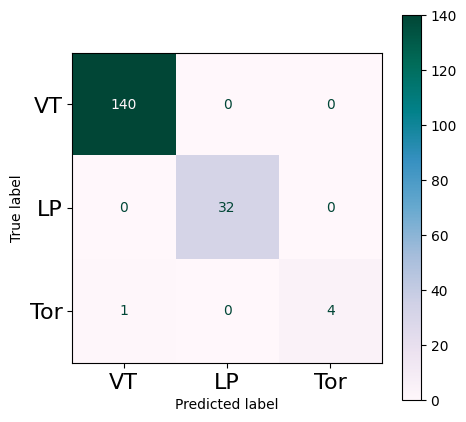

[[[ 36   1]
  [  0 140]]

 [[145   0]
  [  0  32]]

 [[172   0]
  [  1   4]]]
matriz VT  [[ 36   1]
 [  0 140]]
matriz LP  [[145   0]
 [  0  32]]
matriz Tor  [[172   0]
 [  1   4]]


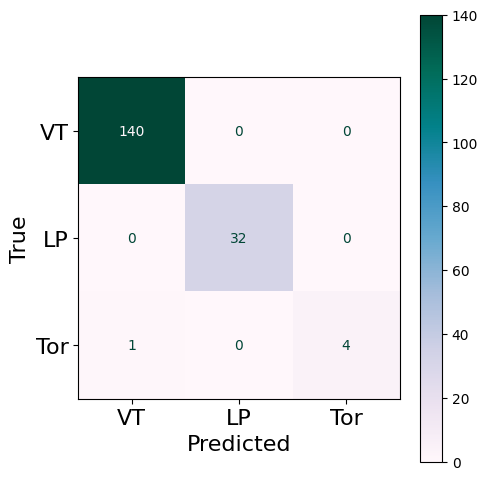

In [21]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix

y_pred_ = np.rint(y_pred)
y_salida = []
for i in range(len(y_pred)):
  if y_pred_[i,0] > 0:
    y_salida.append('VT')
  if y_pred_[i,1] > 0:
    y_salida.append('LP')
  if y_pred_[i,2] > 0:
    y_salida.append('Tor')


y_true = []
for i in range(len(y_test)):
  if y_test[i,0] > 0:
    y_true.append('VT')
  if y_test[i,1] > 0:
    y_true.append('LP')
  if y_test[i,2] > 0:
    y_true.append('Tor')

c = confusion_matrix (y_true , y_salida , labels = ["VT", "LP", "Tor"] , sample_weight = None)
disp = ConfusionMatrixDisplay(confusion_matrix=c, display_labels=["VT", "LP", "Tor"])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap = 'PuBuGn', colorbar = True)
plt.xticks(fontsize=16), plt.yticks(fontsize=16)
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap = 'PuBuGn', colorbar = True)
ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel('Predicted', fontsize=16)
ax.set_ylabel('True', fontsize=16)
# ax.set_title('Confusion Matrix', fontsize=18)
plt.tight_layout()
plt.savefig('confusion_matrix.pdf', dpi=400, format='pdf')

plt.rcParams.update({'font.size': 16})

cm = multilabel_confusion_matrix(y_true, y_salida, labels=["VT", "LP", "Tor"])
print(cm)
cmVT = cm[0]
cmLP = cm[1]
cmTor = cm[2]
print('matriz VT ', cmVT)
print('matriz LP ', cmLP)
print('matriz Tor ', cmTor)

**Evaluación con Métricas de Desempeño**

In [22]:
def calcular_sensitividad(clase_sismo):
  if clase_sismo =='VT':
    CM = cmVT
  if clase_sismo =='LP':
    CM = cmLP
  if clase_sismo =='Tor':
    CM = cmTor
  TP = CM[1,1]
  FN = CM[1,0]
  sen = 100*(TP/(TP+FN))
  print('Sensitividad ' + clase_sismo + ': {:.1f}%'.format(sen))
  return sen


def calcular_especificidad(clase_sismo):
  if clase_sismo =='VT':
    CM = cmVT
  if clase_sismo =='LP':
    CM = cmLP
  if clase_sismo =='Tor':
    CM = cmTor
  TN = CM[0,0]
  FP = CM[0,1]
  esp = 100*(TN/(TN+FP))
  print('Especificidad ' + clase_sismo + ': {:.1f}%'.format(esp))
  return esp


def calcular_precision(clase_sismo):
  if clase_sismo =='VT':
    CM = cmVT
  if clase_sismo =='LP':
    CM = cmLP
  if clase_sismo =='Tor':
    CM = cmTor
  TP = CM[1,1]
  FP = CM[0,1]
  pres = 100*(TP/(TP+FP))
  print('Precisión ' + clase_sismo + ': {:.1f}%'.format(pres))
  return pres


def calcular_f1(sencitividad, precision, clase_sismo):
  f1 = 2*(precision*sencitividad)/(precision+sencitividad)
  print('f1 score ' + clase_sismo + ': {:.1f}%'.format(f1))
  return f1

In [23]:
# Calculo de Especificidad
esp_1 = calcular_especificidad('VT')
esp_2 = calcular_especificidad('LP')
esp_3 = calcular_especificidad('Tor')
# Cálculo de Sensitividad
sen_1 = calcular_sensitividad('VT')
sen_2 = calcular_sensitividad('LP')
sen_3 = calcular_sensitividad('Tor')
# Cálculo de Precisión
pres_1 = calcular_precision('VT')
pres_2 = calcular_precision('LP')
pres_3 = calcular_precision('Tor')
# Cálculo de f1 score
f1_1 = calcular_f1(sen_1,pres_1,'VT')
f1_2 = calcular_f1(sen_2,pres_2,'LP')
f1_3 = calcular_f1(sen_3,pres_3,'Tor')

Especificidad VT: 97.3%
Especificidad LP: 100.0%
Especificidad Tor: 100.0%
Sensitividad VT: 100.0%
Sensitividad LP: 100.0%
Sensitividad Tor: 80.0%
Precisión VT: 99.3%
Precisión LP: 100.0%
Precisión Tor: 100.0%
f1 score VT: 99.6%
f1 score LP: 100.0%
f1 score Tor: 88.9%


In [24]:
from sklearn.metrics import classification_report
# y_pred_label, y_test_label
target_names = ['VT', 'LP', 'Tor']
print(classification_report(y_test, y_pred_, target_names=target_names))

              precision    recall  f1-score   support

          VT       0.99      1.00      1.00       140
          LP       1.00      1.00      1.00        32
         Tor       1.00      0.80      0.89         5

   micro avg       0.99      0.99      0.99       177
   macro avg       1.00      0.93      0.96       177
weighted avg       0.99      0.99      0.99       177
 samples avg       0.99      0.99      0.99       177



# **VALIDACIÓN      DEL     MODELO**

Concatenamos val_1, val_2 y val_3 que forman el 20% del total de los datos que se reservó para la validación y se aplica *shufle*. Luego se obtiene el vector etiquetas.

In [25]:
X_val = np.concatenate([val_s1,val_s2, val_s3], axis=0)

Al graficar las señales para comparar con algunas señales de entrenamiento, puede verse un retraso en las señales de validación, esto se debe a que las señales de entrenamiento que estoy usando tienen una columna adicional donde se indica la clase

Text(0.5, 0, 'Components number')

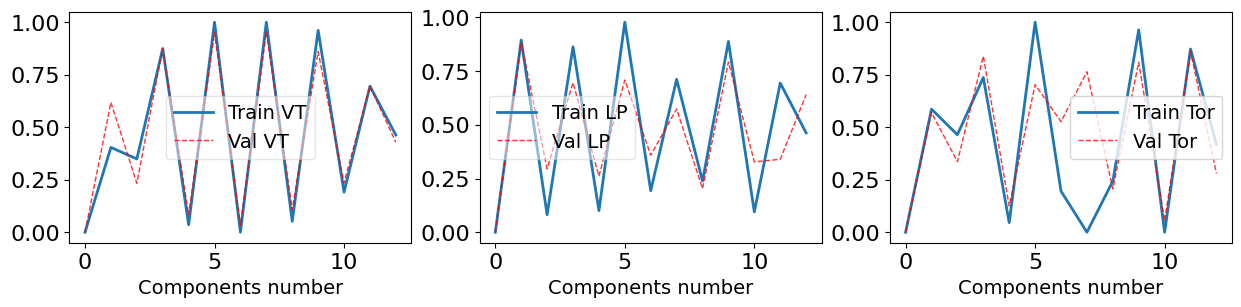

In [26]:
# Graficando
plt.figure(figsize=(15, 3))

plt.subplot(131)
plt.plot(D_train_s1[236, 1:], lw=2, label="Train VT")
plt.legend(fontsize='14', fancybox=True, framealpha=0.5)
plt.xticks(fontsize=16), plt.yticks(fontsize=16)
plt.subplot(132)
plt.plot(D_train_s2[46, 1:], lw=2, label="Train LP")
plt.legend(fontsize='14', fancybox=True, framealpha=0.5)
plt.xticks(fontsize=16), plt.yticks(fontsize=16)
plt.subplot(133)
plt.plot(D_train_s3[23, 1:], lw=2, label="Train Tor")
plt.legend(fontsize='14')
plt.xticks(fontsize=16), plt.yticks(fontsize=16)



plt.subplot(131)
plt.plot(val_s1[44], 'r--', alpha=0.8, lw=1, label="Val VT")
plt.legend(fontsize='14', fancybox=True, framealpha=0.5)
plt.xlabel('Components number', fontsize='14')
plt.subplot(132)
plt.plot(val_s2[34], 'r--', alpha=0.8, lw=1, label="Val LP")
plt.legend(fontsize='14', fancybox=True, framealpha=0.5)
plt.xlabel('Components number', fontsize='14')
plt.subplot(133)
plt.plot(val_s3[4], 'r--', alpha=0.8, lw=1, label="Val Tor")
plt.legend(fontsize='14')
plt.xlabel('Components number', fontsize='14')




Generando vector de etiquetas

Aplicamos *shuffle* y extraemos el vector de rotulos

In [27]:
# Crear el vector de etiquetas
class_VT = np.zeros(val_s1.shape[0])
class_LP = np.ones(val_s2.shape[0])
class_TOR = 2 * np.ones(val_s3.shape[0])

# Concatenar los vectores de etiquetas
labels = np.concatenate((class_VT, class_LP, class_TOR))

labels = labels[:, np.newaxis]
X_val = np.concatenate((labels, X_val), axis=1)
print(X_val.shape)

np.random.shuffle(X_val)

# Vector con etiquetas para validación
y_val = X_val[:, 0]

# Eliminando la primera columna de las señales, donde estaba el vector etiquetas
X_val = X_val[:, 1:]
print(X_val.shape, y_val.shape)
# print(y_val)  # para verificar

(443, 14)
(443, 13) (443,)


Evaluación del modelo con datos de validación

In [28]:
class_final = clasificador.predict(X_val)

14/14 [==============================] - 0s 2ms/step


Evaluación del modelo

**Sensibilidad (Recall):**
La sensibilidad mide la proporción de casos positivos reales que se clasificaron correctamente como positivos.

Otorgando pesos a la clase minoritaria

In [29]:
from sklearn.utils.class_weight import compute_class_weight

# Calcula los pesos de clase basados en la distribución de clases
class_weights = compute_class_weight('balanced', classes=np.unique(y_val), y=y_val)

# Convierte los pesos en un diccionario para su uso en Scikit-learn
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Imprime los pesos de clase
print("Pesos de clase:", class_weight_dict)

Pesos de clase: {0: 0.42432950191570884, 1: 1.823045267489712, 2: 10.547619047619047}


In [30]:
# Calcula la clase predicha para cada muestra
clase_predicha = np.argmax(class_final, axis=1)
# Reemplaza los 1 por 0 y los 2 por 1
clase_predicha = np.where(clase_predicha == 1, 0, np.where(clase_predicha == 2, 1, clase_predicha))
# clase_predicha ahora contendrá la clase predicha para cada muestra
#print(clase_predicha)

In [31]:
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

num_class = 3
y_final = clase_predicha

# Convertir y_val & y_final a una lista de enteros
y_val = [int(label) for label in y_val]
y_final = [int(label) for label in y_final]

# Cálculo de las Matrices de Confusión para cada clase
matrices = [confusion_matrix([y_true], [y_pred]) for y_true, y_pred in zip(y_val, y_final)]
total_TN = sum(cm.diagonal()[:-1].sum() for cm in matrices)  # Suma de todos los verdaderos negativos
total_FP = sum(cm[-1, :-1].sum() for cm in matrices)        # Suma de todos los falsos positivos
# Cálculo especificidad por cada clase
specif_per_class = []
for cm in matrices:
  TN = cm.diagonal()[:-1].sum()   # Suma de los TN de todas clases, menos la última
  FP = cm[-1, :-1].sum()    # Suma de FP de la última clase
  specif = 0 if (TN + FP) == 0 else TN / (TN + FP)
  specif_per_class.append(specif)

# Cálculo de métricas 'PONDERADAS' a la clase mayoritaria
recall_pond = recall_score(y_val, y_final, average='weighted')
f1_pond = f1_score(y_val, y_final, average='weighted')
esp_pond = sum(specif_per_class[i] * class_weights[i] for i in range(num_class)) / sum(class_weights)
g_mean_pond = (recall_pond * esp_pond) ** 0.5
auc_pond = roc_auc_score(y_val, class_final, average='weighted', multi_class='ovr')

# Cálculo de métricas 'MACRO' donde cada clase tiene igual importancia
recall_macro = recall_score(y_val, y_final, average='macro')
f1_macro = f1_score(y_val, y_final, average='macro')
esp_macro = sum(specif_per_class) / num_class
g_mean_macro = (recall_macro * esp_macro) ** 0.5
auc_macro = roc_auc_score(y_val, class_final, average='macro', multi_class='ovr')

# Cálculo de métricas 'MICRO' para una visión global del rendimiento del modelo
recall_micro = recall_score(y_val, y_final, average='micro')
f1_micro = f1_score(y_val, y_final, average='micro')
esp_micro = total_TN / (total_TN + total_FP)
g_mean_micro = (recall_micro * esp_micro) ** 0.5
auc_micro = roc_auc_score(y_val, class_final, average='micro', multi_class='ovr')

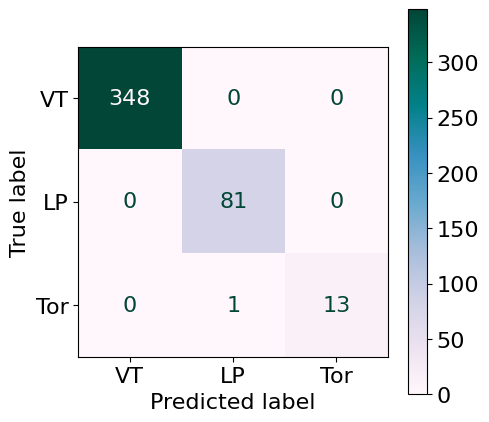

In [32]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define tus etiquetas legibles
etiquetas = ["VT", "LP", "Tor"]

# Convierte y_val a etiquetas legibles
y_true = np.array(etiquetas)[y_val]

# Convierte las predicciones en etiquetas legibles
y_salida = np.array(etiquetas)[np.argmax(class_final, axis=1)]

# Calcula la matriz de confusión
c = confusion_matrix(y_true, y_salida, labels=etiquetas)

# Muestra la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=c, display_labels=etiquetas)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap='PuBuGn', colorbar=True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

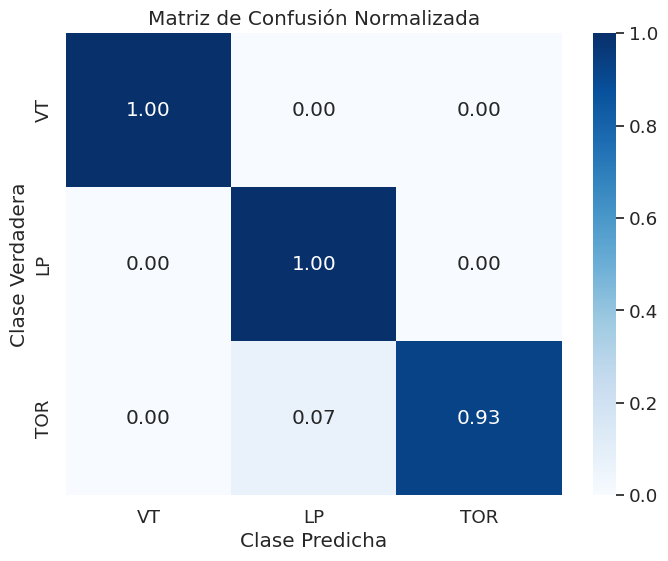

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Supongamos que tienes tu matriz de confusión en 'confusion_matrix'
# Debes reemplazar esto con tus propios valores

# Calcula la matriz de confusión normalizada
row_sums = c.sum(axis=1, keepdims=True)
normalized_c = c / row_sums

# Define las etiquetas de las clases
labels = ["VT", "LP", "TOR"]

# Crea un mapa de calor (heatmap) con seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ajusta el tamaño de la fuente
sns.heatmap(normalized_c, annot=True, fmt=".2f",
            cmap="Blues", xticklabels=labels, yticklabels=labels)

plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión Normalizada')
plt.show()

In [34]:
metrics_dict = {
    'Metrica': ['Recall Ponderado', 'F1 Ponderado', 'Especificidad Ponderada', 'G-Mean Ponderado', 'AUC Ponderado',
                'Recall Macro', 'F1 Macro', 'Especificidad Macro', 'G-Mean Macro', 'AUC Macro',
                'Recall Micro', 'F1 Micro', 'Especificidad Micro', 'G-Mean Micro', 'AUC Micro'],
    'Valor': [recall_pond, f1_pond, esp_pond, g_mean_pond, auc_pond,
              recall_macro, f1_macro, esp_macro, g_mean_macro, auc_macro,
              recall_micro, f1_micro, esp_micro, g_mean_micro, auc_micro]
}
metrics_df = pd.DataFrame(metrics_dict)
print(metrics_df)

                    Metrica     Valor
0          Recall Ponderado  0.785553
1              F1 Ponderado  0.702757
2   Especificidad Ponderada  0.000000
3          G-Mean Ponderado  0.000000
4             AUC Ponderado  0.999994
5              Recall Macro  0.333333
6                  F1 Macro  0.298201
7       Especificidad Macro  0.000000
8              G-Mean Macro  0.000000
9                 AUC Macro  0.999989
10             Recall Micro  0.785553
11                 F1 Micro  0.785553
12      Especificidad Micro  0.000000
13             G-Mean Micro  0.000000
14                AUC Micro  0.999992


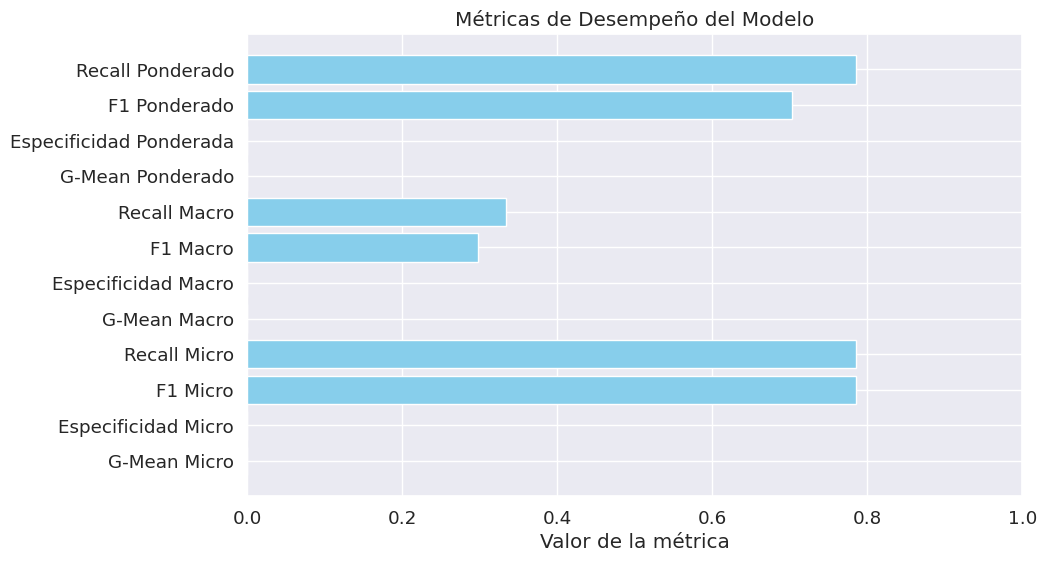

In [35]:
import matplotlib.pyplot as plt

# Define las métricas y sus valores
metricas = ['Recall Ponderado', 'F1 Ponderado', 'Especificidad Ponderada', 'G-Mean Ponderado',
            'Recall Macro', 'F1 Macro', 'Especificidad Macro', 'G-Mean Macro',
            'Recall Micro', 'F1 Micro', 'Especificidad Micro', 'G-Mean Micro']

valores = [recall_pond, f1_pond, esp_pond, g_mean_pond,
           recall_macro, f1_macro, esp_macro, g_mean_macro,
           recall_micro, f1_micro, esp_micro, g_mean_micro]

# Crea un gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(metricas, valores, color='skyblue')
plt.xlabel('Valor de la métrica')
plt.title('Métricas de Desempeño del Modelo')
plt.xlim(0, 1)  # Ajusta el rango del eje x si es necesario
plt.gca().invert_yaxis()  # Invierte el eje y para que las métricas más altas estén arriba
plt.show()

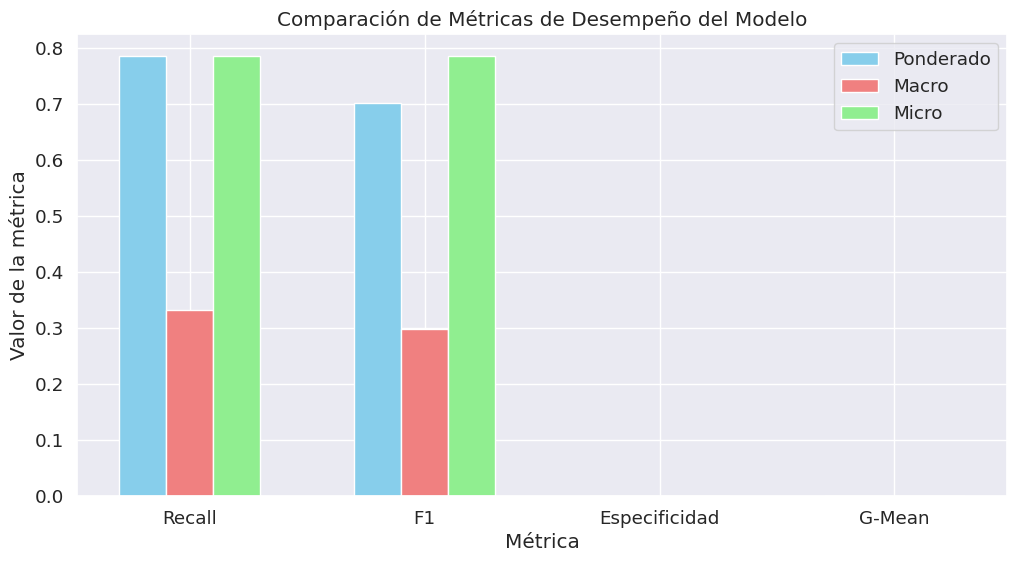

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Define las métricas y sus valores
metricas = ['Recall', 'F1', 'Especificidad', 'G-Mean']
etiquetas = ['Ponderado', 'Macro', 'Micro']

# Valores de las métricas para las tres etiquetas
valores = np.array([[recall_pond, f1_pond, esp_pond, g_mean_pond],
                   [recall_macro, f1_macro, esp_macro, g_mean_macro],
                   [recall_micro, f1_micro, esp_micro, g_mean_micro]])

colores = ['skyblue', 'lightcoral', 'lightgreen']

# Crea un gráfico de barras superpuestas
plt.figure(figsize=(12, 6))

# Ancho de cada barra
bar_width = 0.2
index = np.arange(len(metricas))

for i in range(len(etiquetas)):
    plt.bar(index + i * bar_width, valores[i], bar_width, label=etiquetas[i], color=colores[i])

plt.xlabel('Métrica')
plt.ylabel('Valor de la métrica')
plt.title('Comparación de Métricas de Desempeño del Modelo')
plt.xticks(index + bar_width, metricas)
plt.legend()
plt.show()

Cálculo de Métricas ponderadas por clase

In [38]:
from sklearn.preprocessing import LabelBinarizer

# Crea un objeto LabelBinarizer
lb = LabelBinarizer()

# Convierte las etiquetas de clases en una matriz binaria
y_salida_bin = lb.fit_transform(y_salida)

Convertimos el vector con las etiquetas verdaderas para un código one-hot.

In [39]:
from sklearn.preprocessing import label_binarize

# Codificar las etiquetas verdaderas en un formato binario (one-hot encoding)
y_val_bin = label_binarize(y_val, classes=[0, 1, 2])  # Ajusta las clases según tu etiquetado

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Número de clases
num_classes = y_val_bin.shape[1]

# Crea un diccionario para almacenar las métricas por clase
class_metrics = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'ROC AUC': [],
}

for class_idx in range(num_classes):
    y_true_class = y_val_bin[:, class_idx]
    y_pred_class = y_salida_bin[:, class_idx]

    # Calcula las métricas para la clase actual
    accuracy = accuracy_score(y_true_class, y_pred_class)
    precision = precision_score(y_true_class, y_pred_class)
    recall = recall_score(y_true_class, y_pred_class)
    f1 = f1_score(y_true_class, y_pred_class)
    roc_auc = roc_auc_score(y_true_class, y_pred_class)

    # Almacena las métricas en el diccionario
    class_metrics['Accuracy'].append(accuracy)
    class_metrics['Precision'].append(precision)
    class_metrics['Recall'].append(recall)
    class_metrics['F1-Score'].append(f1)
    class_metrics['ROC AUC'].append(roc_auc)

In [41]:
df = pd.DataFrame(class_metrics, index=[f'Clase {i}' for i in range(1, num_classes + 1)])  # Personaliza los índices según tus clases

# Muestra el DataFrame como una tabla
print(df)

         Accuracy  Precision  Recall  F1-Score   ROC AUC
Clase 1  0.029345        0.0     0.0       0.0  0.068421
Clase 2  0.787810        0.0     0.0       0.0  0.482044
Clase 3  0.182844        0.0     0.0       0.0  0.094406


CURVAS ROC

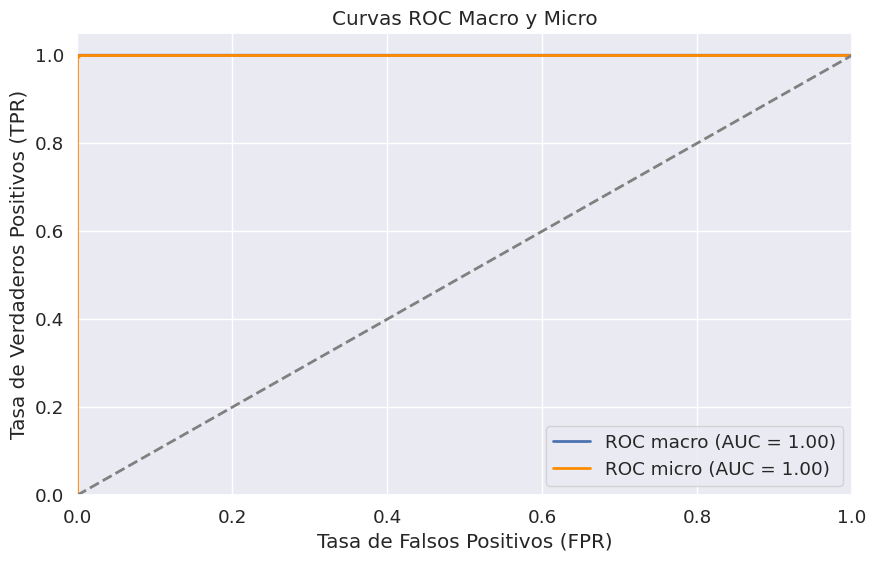

In [42]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcula las curvas ROC y los valores AUC para cada clase
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(etiquetas)):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], class_final[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcula la curva ROC macro promediando los valores de todas las clases
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(etiquetas))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(etiquetas)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(etiquetas)
roc_auc_macro = auc(all_fpr, mean_tpr)

# Calcula la curva ROC micro agregando todas las predicciones y etiquetas verdaderas
all_y_true = y_val_bin.ravel()
all_y_scores = class_final.ravel()
fpr_micro, tpr_micro, _ = roc_curve(all_y_true, all_y_scores)
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Crea la gráfica de las curvas ROC
plt.figure(figsize=(10, 6))

# Curva ROC macro
plt.plot(all_fpr, mean_tpr, color='b', linestyle='-', lw=2, label='ROC macro (AUC = {:.2f})'.format(roc_auc_macro))

# Curva ROC micro
plt.plot(fpr_micro, tpr_micro, color='darkorange', linestyle='-', lw=2, label='ROC micro (AUC = {:.2f})'.format(roc_auc_micro))

# Línea de referencia (clasificación aleatoria)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Configuración de la gráfica
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC Macro y Micro')
plt.legend(loc='lower right')
plt.grid(True)

# Muestra la gráfica
plt.show()

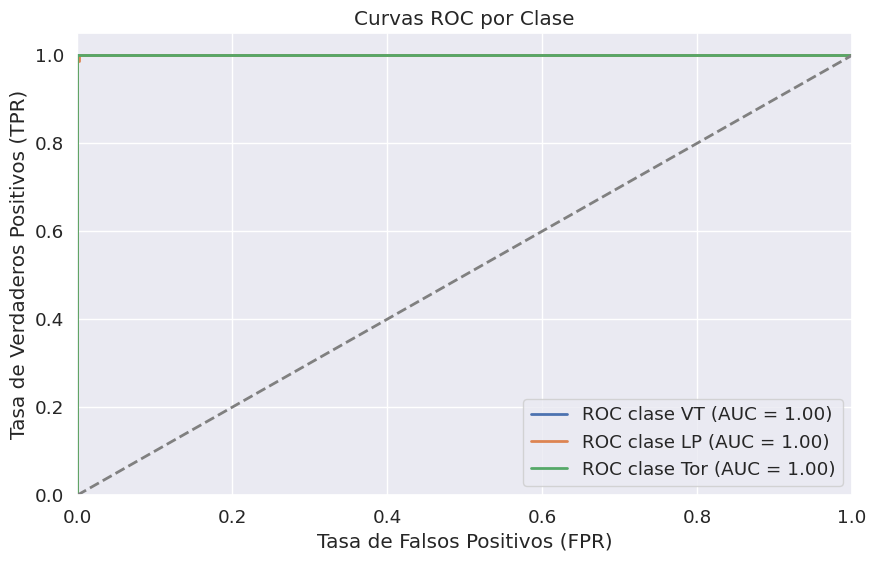

In [43]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Define las etiquetas de las clases
etiquetas = ["VT", "LP", "Tor"]

# Calcula las curvas ROC y los valores AUC para cada clase
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(etiquetas)):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], class_final[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Crea la gráfica de las curvas ROC en un solo gráfico
plt.figure(figsize=(10, 6))

# Trazar las curvas ROC para cada clase
for i in range(len(etiquetas)):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC clase {} (AUC = {:.2f})'.format(etiquetas[i], roc_auc[i]))

# Línea de referencia (clasificación aleatoria)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Configuración de la gráfica
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.grid(True)

# Muestra la gráfica
plt.show()

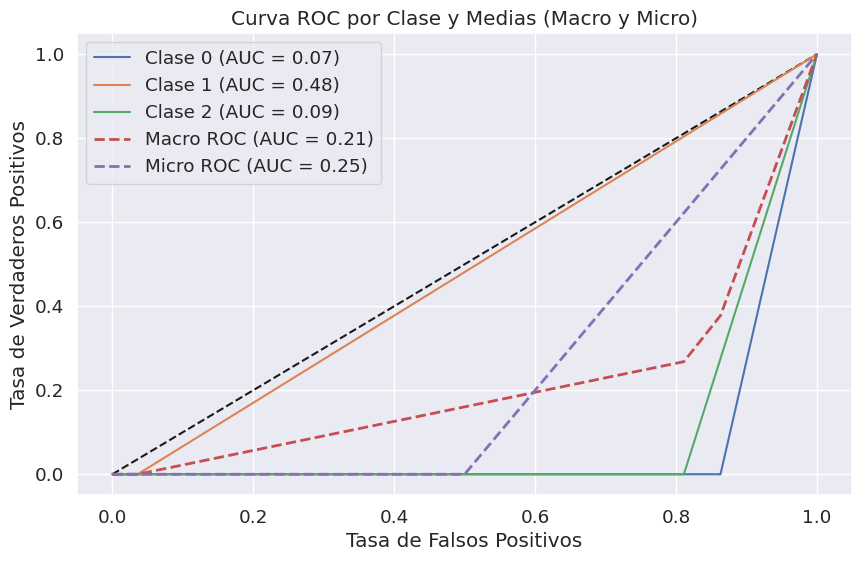

In [44]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import numpy as np
import matplotlib.pyplot as plt

# Calcula las curvas ROC y los valores AUC por clase
fpr_class = {}
tpr_class = {}
roc_auc_class = {}
n_classes = num_classes  # Número de clases

for class_idx in range(n_classes):
    fpr_class[class_idx], tpr_class[class_idx], _ = roc_curve(y_val_bin[:, class_idx], y_salida_bin[:, class_idx])
    roc_auc_class[class_idx] = auc(fpr_class[class_idx], tpr_class[class_idx])

# Calcula la curva ROC macro
all_fpr = np.unique(np.concatenate([fpr_class[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr_class[i], tpr_class[i])
mean_tpr /= n_classes
fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Calcula la curva ROC micro
fpr_micro, tpr_micro, _ = roc_curve(y_val_bin.ravel(), y_salida_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Gráfico de las curvas ROC por clase
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--')
for i in range(n_classes):
    plt.plot(fpr_class[i], tpr_class[i], label=f'Clase {i} (AUC = {roc_auc_class[i]:.2f})')

# Curva ROC macro
plt.plot(fpr_macro, tpr_macro, label=f'Macro ROC (AUC = {roc_auc_macro:.2f})', linestyle='--', linewidth=2)

# Curva ROC micro
plt.plot(fpr_micro, tpr_micro, label=f'Micro ROC (AUC = {roc_auc_micro:.2f})', linestyle='--', linewidth=2)

plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC por Clase y Medias (Macro y Micro)')
plt.legend(loc='best')
plt.show()

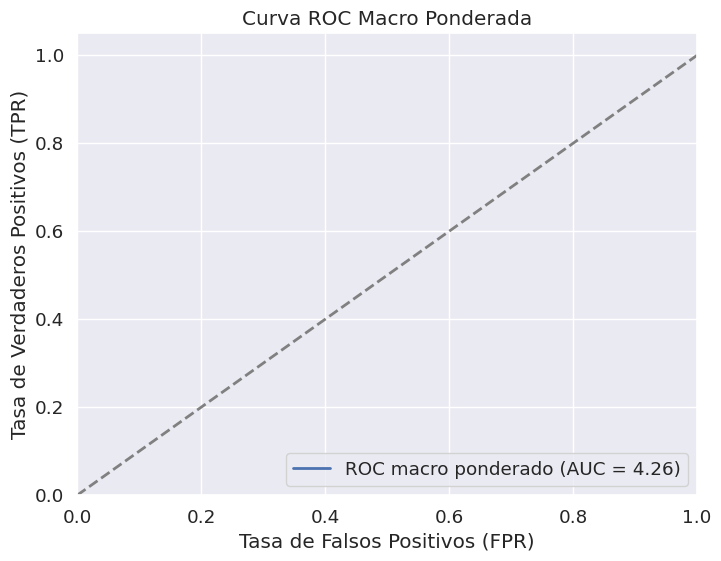

In [45]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define las etiquetas de las clases
etiquetas = ["VT", "LP", "Tor"]

# Calcula las curvas ROC y los valores AUC para cada clase
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(etiquetas)):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], class_final[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcula la curva ROC macro ponderada promediando los valores de todas las clases
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(etiquetas))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(etiquetas)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) * class_weight_dict[i]   # Aplicar pesos
mean_tpr /= len(etiquetas)
roc_auc_macro_ponderado = auc(all_fpr, mean_tpr)

# Crea la gráfica de la curva ROC macro ponderada
plt.figure(figsize=(8, 6))
plt.plot(all_fpr, mean_tpr, color='b', linestyle='-', lw=2,
         label='ROC macro ponderado (AUC = {:.2f})'.format(roc_auc_macro_ponderado))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Macro Ponderada')
plt.legend(loc='lower right')
plt.grid(True)

# Muestra la gráfica
plt.show()

Curva Precision - Recall

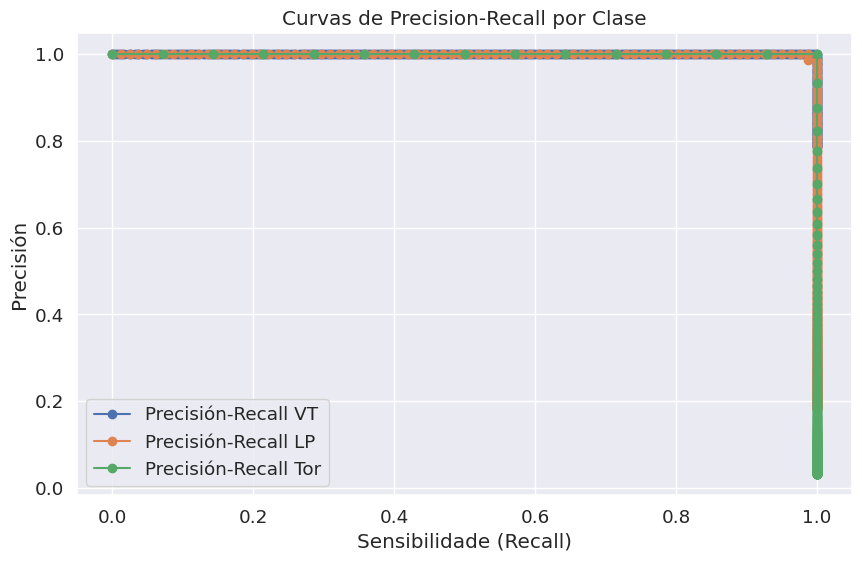

In [46]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Supongamos que tienes tus etiquetas verdaderas y las probabilidades de las predicciones
y_true = np.array(y_val)  # Convierte tus etiquetas verdaderas a un arreglo numpy
y_scores = class_final  # Reemplaza esto con las probabilidades de las predicciones

# Define las etiquetas de las clases
etiquetas = ["VT", "LP", "Tor"]
# Mapeo de etiquetas a valores numéricos
mapeo_etiquetas = {"VT": 0, "LP": 1, "Tor": 2}

# Inicializa un diccionario para almacenar las curvas de precisión-recuperación
precision_dict = {}
recall_dict = {}
thresholds_dict = {}

# Calcula y almacena las curvas de precisión-recuperación para cada clase
for etiqueta in etiquetas:
    y_true_class = (y_true == mapeo_etiquetas[etiqueta]).astype(int)
    y_scores_class = y_scores[:, mapeo_etiquetas[etiqueta]]
    precision, recall, thresholds = precision_recall_curve(y_true_class, y_scores_class)
    precision_dict[etiqueta] = precision
    recall_dict[etiqueta] = recall
    thresholds_dict[etiqueta] = thresholds

# Grafica las curvas de precisión-recuperación para cada clase en una sola figura
plt.figure(figsize=(10, 6))
for etiqueta in etiquetas:
    plt.plot(recall_dict[etiqueta], precision_dict[etiqueta], marker='o', linestyle='-', label=f'Precisión-Recall {etiqueta}')

plt.xlabel('Sensibilidade (Recall)')
plt.ylabel('Precisión')
plt.title('Curvas de Precision-Recall por Clase')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Histograma de Probabilidades

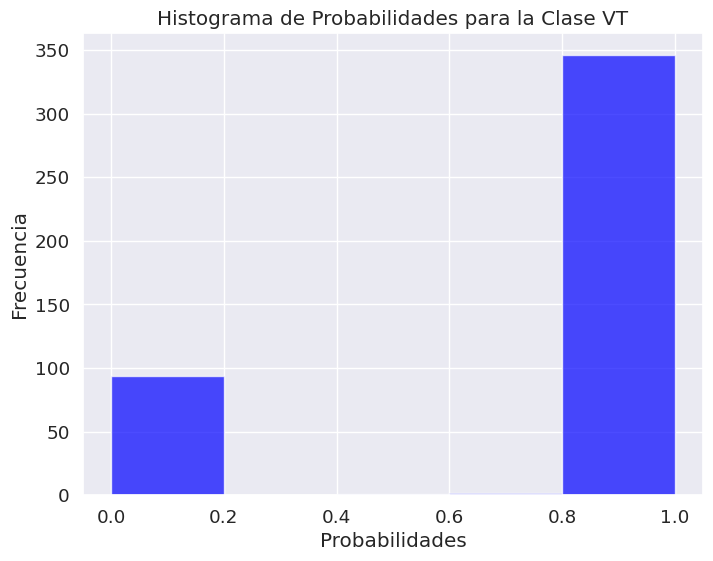

In [47]:
import matplotlib.pyplot as plt

# Clase de interés (cambia a la que necesites)
clase_interes = "VT"

# Obtén las probabilidades de la clase de interés
probabilidades_clase_interes = class_final[:, etiquetas.index(clase_interes)]

# Crea un histograma
plt.figure(figsize=(8, 6))
plt.hist(probabilidades_clase_interes, bins=5, color='blue', alpha=0.7)
plt.title(f'Histograma de Probabilidades para la Clase {clase_interes}')
plt.xlabel('Probabilidades')
plt.ylabel('Frecuencia')
plt.grid(True)

# Muestra el histograma
plt.show()

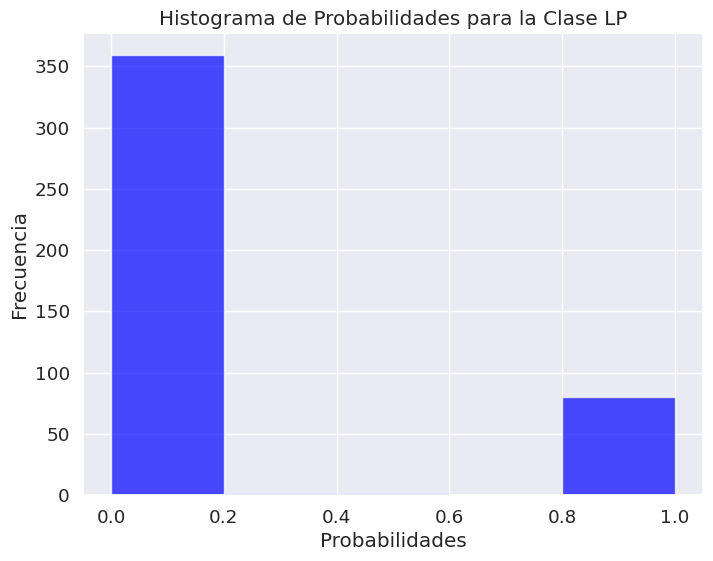

In [48]:
import matplotlib.pyplot as plt

# Clase de interés (cambia a la que necesites)
clase_interes = "LP"

# Obtén las probabilidades de la clase de interés
probabilidades_clase_interes = class_final[:, etiquetas.index(clase_interes)]

# Crea un histograma
plt.figure(figsize=(8, 6))
plt.hist(probabilidades_clase_interes, bins=5, color='blue', alpha=0.7)
plt.title(f'Histograma de Probabilidades para la Clase {clase_interes}')
plt.xlabel('Probabilidades')
plt.ylabel('Frecuencia')
plt.grid(True)

# Muestra el histograma
plt.show()

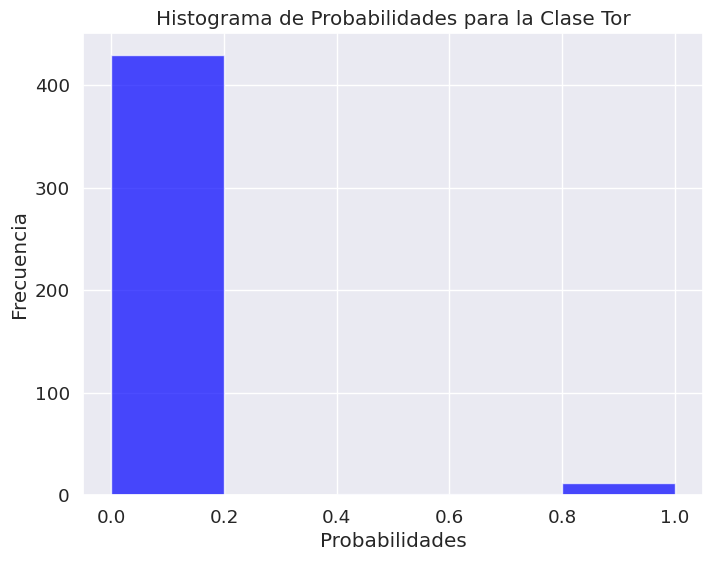

In [49]:
import matplotlib.pyplot as plt

# Clase de interés (cambia a la que necesites)
clase_interes = "Tor"

# Obtén las probabilidades de la clase de interés
probabilidades_clase_interes = class_final[:, etiquetas.index(clase_interes)]

# Crea un histograma
plt.figure(figsize=(8, 6))
plt.hist(probabilidades_clase_interes, bins=5, color='blue', alpha=0.7)
plt.title(f'Histograma de Probabilidades para la Clase {clase_interes}')
plt.xlabel('Probabilidades')
plt.ylabel('Frecuencia')
plt.grid(True)

# Muestra el histograma
plt.show()

In [ ]:
cm = confusion_matrix(y_true0, y_salida0)
print(cm)

cm = confusion_matrix(y_true1, y_salida1)
print(cm)

cm = confusion_matrix(y_true2, y_salida2)
print(cm)


NameError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix

'''y_pred_ = np.rint(y_pred)
y_salida = []
for i in range(len(y_pred)):
  if y_pred_[i,0] > 0:
    y_salida.append('VT')
  if y_pred_[i,1] > 0:
    y_salida.append('LP')
  if y_pred_[i,2] > 0:
    y_salida.append('Tor')
'''

y_true = []
for i in range(len(y_test)):
  if y_test[i,0] > 0:
    y_true.append('VT')
  if y_test[i,1] > 0:
    y_true.append('LP')
  if y_test[i,2] > 0:
    y_true.append('Tor')

c = confusion_matrix ( y_true , y_salida , labels = ["VT", "LP", "Tor"] , sample_weight = None)
disp = ConfusionMatrixDisplay(confusion_matrix=c, display_labels=["VT", "LP", "Tor"])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap = 'PuBuGn', colorbar = True)
plt.xticks(fontsize=16), plt.yticks(fontsize=16)
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap = 'PuBuGn', colorbar = True)
ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel('Predicted', fontsize=16)
ax.set_ylabel('True', fontsize=16)
# ax.set_title('Confusion Matrix', fontsize=18)
plt.tight_layout()
plt.savefig('confusion_LPC.pdf', dpi=400, format='pdf')



plt.rcParams.update({'font.size': 16})
# plt.rc('font', **font)

cm = multilabel_confusion_matrix(y_true, y_salida, labels=["VT", "LP", "Tor"])
print(cm)
cmVT = cm[0]
cmLP = cm[1]
cmTor = cm[2]
print('matriz VT ', cmVT)
print('matriz LP ', cmLP)
print('matriz Tor ', cmTor)

ValueError: ignored

# **Evaluación con Métricas de Desempeño**

In [ ]:
def calcular_sensitividad(clase_sismo):
  if clase_sismo =='VT':
    CM = cmVT
  if clase_sismo =='LP':
    CM = cmLP
  if clase_sismo =='Tor':
    CM = cmTor
  TP = CM[1,1]
  FN = CM[1,0]
  sen = 100*(TP/(TP+FN))
  print('Sensitividad ' + clase_sismo + ': {:.1f}%'.format(sen))
  return sen


def calcular_especificidad(clase_sismo):
  if clase_sismo =='VT':
    CM = cmVT
  if clase_sismo =='LP':
    CM = cmLP
  if clase_sismo =='Tor':
    CM = cmTor
  TN = CM[0,0]
  FP = CM[0,1]
  esp = 100*(TN/(TN+FP))
  print('Especificidad ' + clase_sismo + ': {:.1f}%'.format(esp))
  return esp


def calcular_precision(clase_sismo):
  if clase_sismo =='VT':
    CM = cmVT
  if clase_sismo =='LP':
    CM = cmLP
  if clase_sismo =='Tor':
    CM = cmTor
  TP = CM[1,1]
  FP = CM[0,1]
  pres = 100*(TP/(TP+FP))
  print('Precisión ' + clase_sismo + ': {:.1f}%'.format(pres))
  return pres


def calcular_f1(sencitividad, precision, clase_sismo):
  f1 = 2*(precision*sencitividad)/(precision+sencitividad)
  print('f1 score ' + clase_sismo + ': {:.1f}%'.format(f1))
  return f1

In [ ]:
# Calculo de Especificidad
esp_1 = calcular_especificidad('VT')
esp_2 = calcular_especificidad('LP')
esp_3 = calcular_especificidad('Tor')
# Cálculo de Sensitividad
sen_1 = calcular_sensitividad('VT')
sen_2 = calcular_sensitividad('LP')
sen_3 = calcular_sensitividad('Tor')
# Cálculo de Precisión
pres_1 = calcular_precision('VT')
pres_2 = calcular_precision('LP')
pres_3 = calcular_precision('Tor')
# Cálculo de f1 score
f1_1 = calcular_f1(sen_1,pres_1,'VT')
f1_2 = calcular_f1(sen_2,pres_2,'LP')
f1_3 = calcular_f1(sen_3,pres_3,'Tor')

NameError: ignored

In [ ]:
from sklearn.metrics import classification_report
# y_pred_label, y_test_label
target_names = ['VT', 'LP', 'Tor']
print(classification_report(y_test, y_pred_, target_names=target_names))

NameError: ignored

# **th**

In [ ]:
th_VT = np.array(th_VT)
th_LP = np.array(th_LP)
th_Tor = np.array(th_Tor)

print(th_VT.shape, th_LP.shape, th_Tor.shape)

(1, 74) (1, 69) (1, 3)


In [ ]:
print(th_Tor)

[[1.9321239e+00 9.3212390e-01 1.1181825e-04]]


In [ ]:
print(tprs_mean_0)
print(tpr_0_final)

[array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00578035,
       0.00578035, 0.01156069, 0.01156069, 0.01156069, 0.01156069,
       0.01156069, 0.01156069, 0.01734104, 0.01734104, 0.02312139,
       0.02312139, 0.02312139, 0.02312139, 0.02312139, 0.04624277,
       0.04624277, 0.0982659 , 0.0982659 , 0.10573948, 0.10848368,
       0.23839552, 0.24113972, 0.29479769, 0.29479769, 0.50289017,
       0.50289017, 0.50867052, 0.50867052, 0.55491329, 0.55491329,
       0.55491329, 0.56647399, 0.56647399, 0.66135342, 0.66409762,
       0.68208092, 0.68208092, 0.7283237 , 0.7283237 , 0.74718281,
       0.74992702, 0.75144509, 0.75144509, 0.79768786, 0.79768786,
       0.83815029, 0.83815029, 0.83815029, 0.83815029, 0.84971098,
       0.84971098, 0.84971098, 0.85549133, 0.85549133, 0.86705202,
       0.86705202, 0.86705202, 0.86705202, 0.86705202, 0.86705202,
       0.87283237, 0.87283237, 0.87861272, 0.87861272, 0.9421

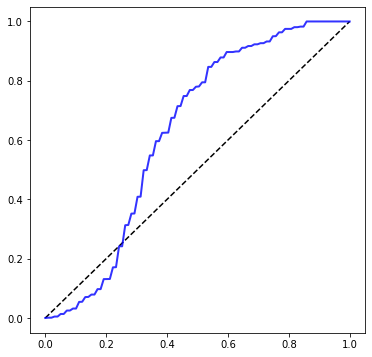

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
#mean_tpr = np.mean(tprs, axis=0)
tpr_0_final[-1] = 1.0
mean_auc = auc(mean_fpr, tpr_0_final)
#std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    tpr_0_final,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

# Aplicando CV Estratrificado en la clasificación junto con la ROC

StratifiedShuffleSplit(n_splits=6, random_state=True, test_size=None,
            train_size=None)
TRAIN: [1760 1519  466 ... 2181 1023 2117] TEST: [1131 2043 1604 2106 1168 1969 1664 1840  822 2129  349 1447  708 1307
  705  245 1320  474  182 1797 1495 1686  232 1353 2107  702  974  611
 1135  367    5 1174  819 1858  661 1304  317  164 1426  650  352 1543
 1945  792 2016  536 1465 1560 1778  971   28  366  311 2061 2133  623
  601 1655 1156 1684 1575 1191 2121 1402 2014  640 1709 1998 1511  675
  197 1931 1163 1347 1770  754  327 1362 1751 1721  610 1213 1820  414
 1793  617  120  927  223 1759 1523  165 1187  565  761 2137   19 1269
 1220 1072 1977  871 1706 1739 1827  418 1715  526 1384 1416   69 1681
 1098 1439  736  533  667 1370  903 1694  176 1446  658 1344 2038 1154
  186 1255  191  194  636 1178 1823 1583 2192 1171 1813  690 1123 1902
 2125 1216 2126  420 1713 2096  430  802  612  826  976  817 1028 1007
 1578 1209 1259  945  185  774  733 1688  808  595   33 1458 1425 1924


<ipython-input-84-21a6336b7d07>:201: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-84-21a6336b7d07>:206: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


8/8 [==============================] - 1s 32ms/step - loss: 0.1224 - categorical_accuracy: 0.8169 - val_loss: 0.1215 - val_categorical_accuracy: 0.8182
Epoch 2/15
8/8 [==============================] - 0s 12ms/step - loss: 0.1224 - categorical_accuracy: 0.8169 - val_loss: 0.1215 - val_categorical_accuracy: 0.8182
Epoch 3/15
8/8 [==============================] - 0s 13ms/step - loss: 0.1224 - categorical_accuracy: 0.8169 - val_loss: 0.1215 - val_categorical_accuracy: 0.8182
Epoch 4/15
8/8 [==============================] - 0s 13ms/step - loss: 0.1224 - categorical_accuracy: 0.8169 - val_loss: 0.1215 - val_categorical_accuracy: 0.8182
Epoch 5/15
8/8 [==============================] - 0s 12ms/step - loss: 0.1223 - categorical_accuracy: 0.8169 - val_loss: 0.1214 - val_categorical_accuracy: 0.8182
Epoch 6/15
8/8 [==============================] - 0s 13ms/step - loss: 0.1223 - categorical_accuracy: 0.8169 - val_loss: 0.1214 - val_categorical_accuracy: 0.8182
Epoch 7/15
8/8 [=================

<ipython-input-84-21a6336b7d07>:201: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-84-21a6336b7d07>:206: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


8/8 [==============================] - 1s 33ms/step - loss: 0.1223 - categorical_accuracy: 0.8169 - val_loss: 0.1214 - val_categorical_accuracy: 0.8182
Epoch 2/15
8/8 [==============================] - 0s 12ms/step - loss: 0.1223 - categorical_accuracy: 0.8169 - val_loss: 0.1214 - val_categorical_accuracy: 0.8182
Epoch 3/15
8/8 [==============================] - 0s 13ms/step - loss: 0.1223 - categorical_accuracy: 0.8169 - val_loss: 0.1214 - val_categorical_accuracy: 0.8182
Epoch 4/15
8/8 [==============================] - 0s 12ms/step - loss: 0.1222 - categorical_accuracy: 0.8169 - val_loss: 0.1214 - val_categorical_accuracy: 0.8182
Epoch 5/15
8/8 [==============================] - 0s 13ms/step - loss: 0.1222 - categorical_accuracy: 0.8169 - val_loss: 0.1214 - val_categorical_accuracy: 0.8182
Epoch 6/15
8/8 [==============================] - 0s 12ms/step - loss: 0.1222 - categorical_accuracy: 0.8169 - val_loss: 0.1213 - val_categorical_accuracy: 0.8182
Epoch 7/15
8/8 [=================

<ipython-input-84-21a6336b7d07>:201: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-84-21a6336b7d07>:206: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


TRAIN: [ 670 1652 1709 ...    8 1069  391] TEST: [1331  765 2166  335 1160  382  980  162  232 1823  744 1332 2136 2143
 1145  646  266  163  937 1393  808 1211  669 1898  967 1982  512  589
  611 1914 2147 1628 1948  889  138 1010   40 1821 2069  361 1612 2041
  436  599 1403  167 1133  401  731 1966 1310 1087  532 1123 1629 1387
  412  866  212 1367 1872  624 1451  362 1649  644 1544  291   44 2155
 1588  555  497 1509  661 1066   38  427 1247  304 1626  918  593 1969
 1660  355  182 1663  346 1177  407 1936  294  818  341 2168 1371  249
 1013  695 2188  380 1723 1718  317  715  767 1319  711 1564   83 1973
 2089  850 1093 1068 1827 1195 1320  329  984  500 2050 1921 1051  322
  147 1254  120 1307 1560 1662  570 1944  853 1250  569  645 1771  734
 1892  471  746  240 1097 1357 2113    1 1960  476  414 1011 1023  323
 1473  113  160  513 1296 1919  894  747 1931 1071  699 1684  951  887
  975  499   78 1659 1116  274  639 2144 1594   10 2071 1533 1661  858
  241 1220   51 1460 1061  9

<ipython-input-84-21a6336b7d07>:201: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-84-21a6336b7d07>:206: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


8/8 [==============================] - 1s 33ms/step - loss: 0.1223 - categorical_accuracy: 0.8169 - val_loss: 0.1214 - val_categorical_accuracy: 0.8182
Epoch 2/15
8/8 [==============================] - 0s 13ms/step - loss: 0.1223 - categorical_accuracy: 0.8169 - val_loss: 0.1214 - val_categorical_accuracy: 0.8182
Epoch 3/15
8/8 [==============================] - 0s 14ms/step - loss: 0.1223 - categorical_accuracy: 0.8169 - val_loss: 0.1214 - val_categorical_accuracy: 0.8182
Epoch 4/15
8/8 [==============================] - 0s 12ms/step - loss: 0.1223 - categorical_accuracy: 0.8169 - val_loss: 0.1214 - val_categorical_accuracy: 0.8182
Epoch 5/15
8/8 [==============================] - 0s 12ms/step - loss: 0.1222 - categorical_accuracy: 0.8169 - val_loss: 0.1213 - val_categorical_accuracy: 0.8182
Epoch 6/15
8/8 [==============================] - 0s 17ms/step - loss: 0.1222 - categorical_accuracy: 0.8169 - val_loss: 0.1213 - val_categorical_accuracy: 0.8182
Epoch 7/15
8/8 [=================

<ipython-input-84-21a6336b7d07>:201: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-84-21a6336b7d07>:206: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


train -  [1555  362   60]   |   test -  [173  40   7]
train -  [1555  362   60]   |   test -  [173  40   7]
train -  [1555  362   60]   |   test -  [173  40   7]
train -  [1555  362   60]   |   test -  [173  40   7]
train -  [1555  362   60]   |   test -  [173  40   7]
train -  [1555  362   60]   |   test -  [173  40   7]


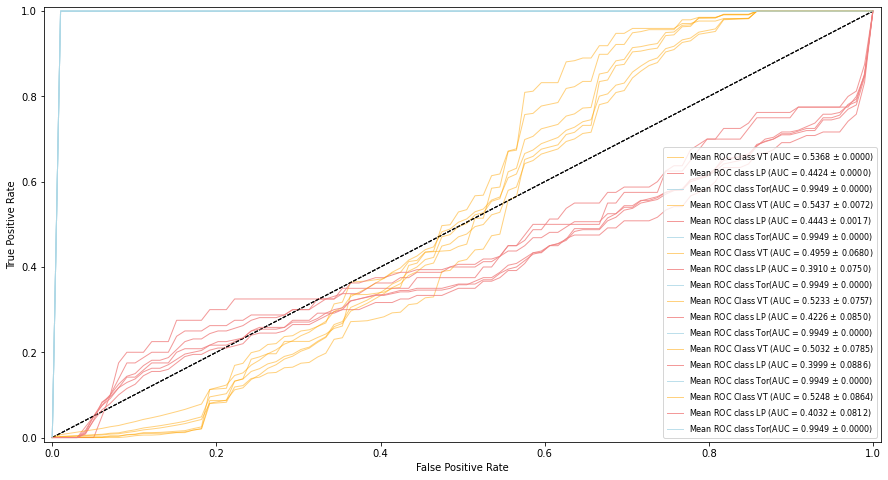

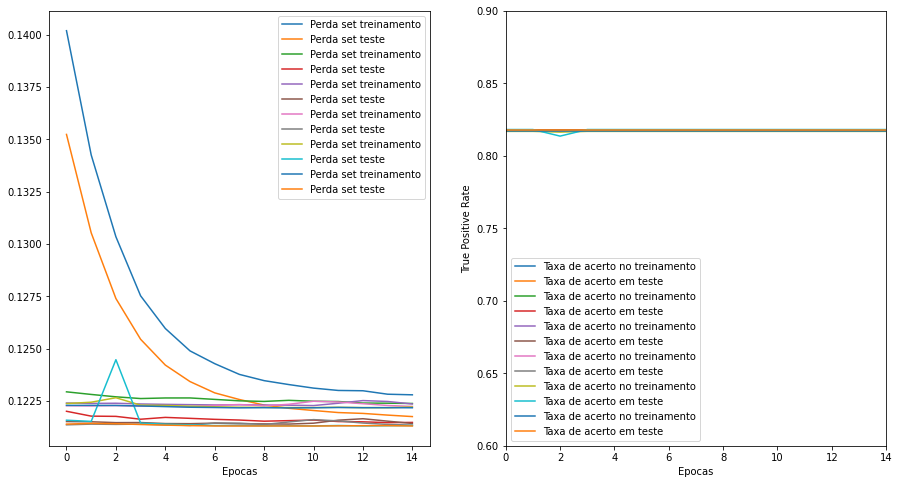

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

#cv.get_n_splits(X, y_label)

print(cv)
StratifiedShuffleSplit(n_splits=6, random_state=True)

fig, ax = plt.subplots(figsize = (15, 8))
tprs0 = []
aucs0 = []
Corte0 = []
tprs1 = []
aucs1 = []
Corte1 = []
tprs2 = []
aucs2 = []
Corte2 = []

for train_index, test_index in cv.split(X, y_label):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  f = 0

  dim_entrada = X.shape[1]
  entrada = Input(shape=(dim_entrada,))
  x = Dense(500, activation='relu', kernel_regularizer=l2(0.005))(entrada)
  x = Dropout(0.25)(x)
  x = Dense(100, activation='relu')(x)
  x = Dropout(0.25)(x)
  saida = Dense(3, activation='softmax')(x)

  clasificador = Model(inputs=entrada, outputs=saida)
  clasificador.compile(optimizer='adam', loss='mae', metrics=['categorical_accuracy'])
  historia = clasificador.fit(X_train, y_train,
                           epochs=15,
                           batch_size=250,
                           validation_data=(X_test, y_test),
                           shuffle=True)
  y_pred = clasificador.predict(X_test)

  #fig, ax2 = plt.subplots()
  #base_fpr = np.linspace(0, 1, 101)
  #mean_fpr = np.linspace(0, 1, 100)


  #Curva ROC para la clase VT
  base_fpr0 = np.linspace(0, 1, 101)
  mean_fpr0 = np.linspace(0, 1, 100) # duda, Solo son cien valores entre 0 y 1?

  for i in range(len(y_pred)):
    fpr0, tpr0, th0 = roc_curve(y_test[:, 0],  y_pred[:,0])
    auc0 = roc_auc_score(y_test[:, 0], y_pred[:, 0])

  interp_tpr0 = np.interp(mean_fpr0, fpr0, tpr0)
  interp_tpr0[0] = 0.0
  tprs0.append(interp_tpr0)
  aucs0.append(auc0)


  Corte0.append(th0[np.argmax(tpr0 - fpr0)])


  ax.plot([0, 1], [0, 1], linestyle="--", lw=1, color="k",
          alpha=0.5)

  #last_tprs0 = tprs0[f][:]
  #last_aucs0 = aucs0[f][:]
  #last_tprs0.ravel().tolist()
  #last_aucs0.tolist()
  mean_tpr0 = np.mean(tprs0, axis=0) # tienen que ser los ultimos 100
  mean_tpr0[-1] = 1.0
  mean_auc0 = auc(mean_fpr0, mean_tpr0)
  #std_auc0 = np.std(last_aucs0) # tienen que ser solo los últimos 100
  std_auc0 = np.std(aucs0)
  ax.plot(
      mean_fpr0,
      mean_tpr0,
      color="orange",
      label=r"Mean ROC Class VT (AUC = %0.4f $\pm$ %0.4f)" % (mean_auc0, std_auc0),
      lw=1,
      alpha=0.5,
  )

  #std_tpr = np.std(tprs, axis=0)
  #tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  #tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  #ax.fill_between(
      #mean_fpr,
      #tprs_lower,
      #tprs_upper,
      #color="wheat",
      #alpha=0.2,
      #label=r"$\pm$ 1 Standard deviation",
  #)

  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')


  #Curva ROC para la clase LP
  base_fpr1 = np.linspace(0, 1, 101)
  mean_fpr1 = np.linspace(0, 1, 100)

  for i in range(len(y_pred)):
    fpr1, tpr1, th1 = roc_curve(y_test[:, 1],  y_pred[:, 1])
    auc1 = roc_auc_score(y_test[:, 1], y_pred[:, 1])

  interp_tpr1 = np.interp(mean_fpr1, fpr1, tpr1)
  interp_tpr1[0] = 0.0
  tprs1.append(interp_tpr1)
  aucs1.append(auc1)

  Corte1.append(th1[np.argmax(tpr1 - fpr1)])

  #last_tprs1 = tprs1[f][:]
  #last_aucs1 = aucs1[f][:]
  #last_tprs1.ravel().tolist()
  #last_aucs1.tolist()
  mean_tpr1 = np.mean(tprs1, axis=0)
  mean_tpr1[-1] = 1.0
  mean_auc1 = auc(mean_fpr1, mean_tpr1)
  #std_auc1 = np.std(last_aucs1)
  std_auc1 = np.std(aucs1)
  ax.plot(
      mean_fpr1,
      mean_tpr1,
      color="lightcoral",
      label="Mean ROC class LP (AUC = %0.4f $\pm$ %0.4f)" % (mean_auc1, std_auc1),
      lw=1,
      alpha=0.8, # alpha es transparencia
  )

  #std_tpr = np.std(tprs, axis=0)
  #tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  #tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  #ax.fill_between(
      #mean_fpr,
      #tprs_lower,
      #tprs_upper,
      #color="gray",
      #alpha=0.2,
      #label="$\pm$ 1 Standard deviation",
  #)

  #Curva ROC para la clase Tor
  base_fpr2 = np.linspace(0, 1, 101)
  mean_fpr2 = np.linspace(0, 1, 100)

  for i in range(len(y_pred)):
    fpr2, tpr2, th2 = roc_curve(y_test[:, 2],  y_pred[:, 2])
    auc2 = roc_auc_score(y_test[:, 2], y_pred[:, 2])

  interp_tpr2 = np.interp(mean_fpr2, fpr2, tpr2)
  interp_tpr2[0] = 0.0
  tprs2.append(interp_tpr2)
  aucs2.append(auc2)

  Corte2.append(th2[np.argmax(tpr2 - fpr2)])

  #last_tprs2 = tprs2[f][:]
  #last_aucs2 = aucs2[f][:]
  #last_tprs2.ravel().tolist()
  #last_aucs2.tolist()
  mean_tpr2 = np.mean(tprs2, axis=0)
  mean_tpr2[-1] = 1.0
  mean_auc2 = auc(mean_fpr2, mean_tpr2)
  #std_auc2 = np.std(last_aucs2)
  std_auc2 = np.std(aucs2)
  ax.plot(
      mean_fpr2,
      mean_tpr2,
      color="lightblue",
      label="Mean ROC class Tor(AUC = %0.4f $\pm$ %0.4f)" % (mean_auc2, std_auc2),
      lw=1,
      alpha=0.8,
  )

  #std_tpr = np.std(tprs, axis=0)
  #tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  #tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  #ax.fill_between(
      #mean_fpr,
      #tprs_lower,
      #tprs_upper,
      #color="gray",
      #alpha=0.2,
      #label="$\pm$ 1 Standard deviation",
  #)
  ax.legend(loc="lower right",fontsize = 8)
  f = f + 1

  import matplotlib.pyplot as plt
  plt.figure(2, figsize=(15,8))
  plt.subplot(1,2,1)
  plt.plot(historia.history["loss"], label="Perda set treinamento")
  plt.plot(historia.history["val_loss"], label="Perda set teste")
  plt.xlabel('Epocas')
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(historia.history["categorical_accuracy"], label="Taxa de acerto no treinamento")
  plt.plot(historia.history["val_categorical_accuracy"], label="Taxa de acerto em teste")
  plt.xlim(0, 14)
  plt.ylim(0.6, 0.9)
  plt.xlabel('Epocas')
  plt.legend()

for train, test in cv.split(X, y_label):
  print('train -  {}   |   test -  {}'.format(
      np.bincount(y_label[train]), np.bincount(y_label[test])))

In [ ]:
aucs0

[0.5948837781330709]

In [ ]:
mean_fpr0

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [ ]:
#print(tprs0)
print(mean_tpr0)
f = 0
#tprs0[f][:]
m = np.mean(tprs0[f][:])

0.5522522917031587


In [ ]:
tprs1

[array([0.   , 0.   , 0.   , 0.   , 0.   , 0.025, 0.05 , 0.05 , 0.05 ,
        0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.1  , 0.125,
        0.125, 0.125, 0.15 , 0.15 , 0.175, 0.2  , 0.2  , 0.225, 0.325,
        0.325, 0.325, 0.325, 0.35 , 0.375, 0.4  , 0.4  , 0.4  , 0.425,
        0.45 , 0.45 , 0.45 , 0.45 , 0.475, 0.5  , 0.5  , 0.5  , 0.5  ,
        0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.525, 0.525, 0.525, 0.55 ,
        0.55 , 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575,
        0.6  , 0.6  , 0.625, 0.65 , 0.65 , 0.7  , 0.7  , 0.7  , 0.7  ,
        0.7  , 0.7  , 0.7  , 0.7  , 0.7  , 0.7  , 0.725, 0.725, 0.725,
        0.725, 0.725, 0.725, 0.725, 0.725, 0.75 , 0.75 , 0.825, 0.825,
        0.825, 0.85 , 0.85 , 0.875, 0.875, 0.875, 0.9  , 0.9  , 0.925,
        1.   ])]

In [ ]:
tprs2

[array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]

In [ ]:
# fazendo ciclo for pasra guardar meus y_pred

y_proba = []
for i in range(50):
  # Rodando o classificador
  clasificador = Model(inputs=entrada, outputs=saida)
  clasificador.compile(optimizer='adam', loss='mae', metrics=['accuracy'])
  historia = clasificador.fit(X_train, y_train,
                           epochs=25,
                           batch_size=150,
                           validation_data=(X_test, y_test),
                           shuffle=True)
  # gerando meu vetor de predição
  clasificador = Model(inputs=entrada, outputs=saida)
  y_pred = clasificador.predict(X_test)
  y_proba.append(y_pred)




In [ ]:
y_proba[49]

In [ ]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle


tprs = []
base_fpr = np.linspace(0, 1, 101)

plt.figure(figsize=(5, 5))
plt.axes().set_aspect('equal', 'datalim')

# Ciclo for para procurar na hipermatriz de y_proba
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
for i in range(len(y_proba)):
  for col in range(n_classes):
    fpr[col], tpr[i], _ = roc_curve(y_test[:, col], y_proba[i][:,col])
    roc_auc[col] = auc(fpr[col], tpr[col])


'''
  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = np.interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)

  tprs = np.array(tprs)
  mean_tprs = tprs.mean(axis=0)
  std = tprs.std(axis=0)

  tprs_upper = np.minimum(mean_tprs + std, 1)
  tprs_lower = mean_tprs - std


plt.plot(base_fpr, mean_tprs, 'c')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
'''

In [ ]:
fpr

In [ ]:
y_proba[0][:,2]

In [ ]:
y_proba

In [ ]:
import matplotlib.pyplot as plt
plt.figure(5, figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(historia.history["loss"], label="Perda set treinamento")
plt.plot(historia.history["val_loss"], label="Perda set teste")
plt.xlabel('Epocas')
plt.legend()
plt.subplot(1,2,2)
plt.plot(historia.history["accuracy"], label="Taxa de acerto no treinamento")
plt.plot(historia.history["val_accuracy"], label="Taxa de acerto no teste")
plt.xlabel('Epocas')
plt.legend()

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix

clasificador = Model(inputs=entrada, outputs=saida)
y_pred = clasificador.predict(X_test)

y_pred_ = np.rint(y_pred)

y_true = []
for i in range(len(y_test)):
  if y_test[i,0] > 0:
    y_true.append('VT')
  if y_test[i,1] > 0:
    y_true.append('LP')
  if y_test[i,2] > 0:
    y_true.append('Tor')

y_salida = []
for i in range(len(y_pred_)):
  if y_pred_[i,0] > 0:
    y_salida.append('VT')
  if y_pred_[i,1] > 0:
    y_salida.append('LP')
  if y_pred_[i,2] > 0:
    y_salida.append('Tor')

# Matriz de confusión multiclase
c = confusion_matrix ( y_true , y_salida , labels = ["VT", "LP", "Tor"] , sample_weight = None )
disp = ConfusionMatrixDisplay(confusion_matrix=c, display_labels=["VT", "LP", "Tor"])
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap = 'PuBuGn', colorbar = True)
plt.show()

plt.show()

print(c)
cm = multilabel_confusion_matrix(y_true, y_salida, labels=["VT", "LP", "Tor"])
print(cm)

cmVT = cm[0]
cmLP = cm[1]
cmTor = cm[2]

**Sensitividad y Especificidad**



*   Verdaderos Positivos (TP): La clase de sismo de interés que ha sido clasificada correctamente,
*   Falsos negativos (FN): La clase de sismo de interés que fue clasificada como otro tipo de sismo,
*   Verdadero negativo (TN): Otros tipo de sismo que fue correctamente clasificado como un tipo de sismo diferente a la clase de interés, y
*   Falsos positivos (FP): cuando un sismo diferente fue clasificado como si fuera el simo de la clase de interés.

La ** sensitividad** mide la proporción de los sismos de interés detectados correctamente, una sensitividad del 100% detectará todos los sismos de interés:

$$Sensitividad = \dfrac{TP}{TP+FN}$$

La **especificidad** mide la proporción de otro tipo de sismos que fueron detectados correctamente diferentes a la clase de interés. Una especificidad del 100% detectará sismos diferentes a la clase de interés:
$$Especificidad = \dfrac{TN}{TN+FP}$$

In [ ]:
def calcular_sensitividad(clase_sismo):
  if clase_sismo =='VT':
    CM = cmVT
  if clase_sismo =='LP':
    CM = cmLP
  if clase_sismo =='Tor':
    CM = cmTor
  TP = CM[1,1]
  FN = CM[1,0]
  sen = 100*(TP/(TP+FN))
  print('Sensitividad ' + clase_sismo + ': {:.1f}%'.format(sen))
  return sen


def calcular_especificidad(clase_sismo):
  if clase_sismo =='VT':
    CM = cmVT
  if clase_sismo =='LP':
    CM = cmLP
  if clase_sismo =='Tor':
    CM = cmTor
  TN = CM[0,0]
  FP = CM[0,1]
  esp = 100*(TN/(TN+FP))
  print('Especificidad ' + clase_sismo + ': {:.1f}%'.format(esp))
  return esp


def calcular_precision(clase_sismo):
  if clase_sismo =='VT':
    CM = cmVT
  if clase_sismo =='LP':
    CM = cmLP
  if clase_sismo =='Tor':
    CM = cmTor
  TP = CM[1,1]
  FP = CM[0,1]
  pres = 100*(TP/(TP+FP))
  print('Precisión ' + clase_sismo + ': {:.1f}%'.format(pres))
  return pres


def calcular_f1(sencitividad, precision, clase_sismo):
  f1 = 2*(precision*sencitividad)/(precision+sencitividad)
  print('f1 score ' + clase_sismo + ': {:.1f}%'.format(f1))
  return f1

In [ ]:
# Calculo de Especificidad
esp_1 = calcular_especificidad('VT')
esp_2 = calcular_especificidad('LP')
esp_3 = calcular_especificidad('Tor')

# Cálculo de Sensitividad
sen_1 = calcular_sensitividad('VT')
sen_2 = calcular_sensitividad('LP')
sen_3 = calcular_sensitividad('Tor')

# Cálculo de Precisión
pres_1 = calcular_precision('VT')
pres_2 = calcular_precision('LP')
pres_3 = calcular_precision('Tor')

# Cálculo de f1 score
f1_1 = calcular_f1(sen_1,pres_1,'VT')
f1_2 = calcular_f1(sen_2,pres_2,'LP')
f1_3 = calcular_f1(sen_3,pres_3,'Tor')

In [ ]:
from sklearn.metrics import classification_report
# y_pred_label, y_test_label
target_names = ['VT', 'LP', 'Tor']
print(classification_report(y_test, y_pred_, target_names=target_names))

In [ ]:
y_pred

In [ ]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


In [ ]:
fpr

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,5))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="darkgreen", #deeppink
    linestyle="--",
    linewidth=2,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="mediumseagreen", #
    linestyle="--",
    linewidth=2,
)

colors = cycle(["tab:orange", "indianred", "tab:blue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

# **Código alternativo para las gráficas ROC**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

'''
Definiendo funciones
'''

def calculate_tpr_fpr(y_test_label, y_pred_label):
  cm = confusion_matrix(df_aux['class'], df_aux['prob'])
  TN = cm[0, 0]
  FP = cm[0, 1]
  FN = cm[1, 0]
  TP = cm[1, 1]

  # Calcula tpr y fpr
  tpr =  TP/(TP + FN) # sensitivity - true positive rate
  fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate

  return tpr, fpr



def get_all_roc_coordinates(etiquetas, y_probab):

    # Calcula todas las coordenadas de la curva ROC (tpr y fpr) considerando cada punto como un umbral para la predicción de la clase.

    # Args:
        # etiquetas: La lista o serie con las etiquetas de las clases reales.
        # y_probab: El arreglo con las probabilidades para cada clase, obtenido usando el método `clasificador.predict(X_test)`.

    # Returns:
        # tpr_list: la lista de TPR que representan cada umbral.
        # fpr_list: la lista de FPR que representa cada umbral.

    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_probab)):
        threshold = y_probab[i]
        y_predict = y_probab >= threshold
        tpr, fpr = calculate_tpr_fpr(etiquetas, y_predict)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list


def plot_roc_curve(tpr, fpr, scatter = True, ax = None):

    # grafica la curva ROC utilizando la lista de coordenadas (tpr y fpr).

    # Args:
        # tpr: La lista de TPR que representan cada coordenada.
        # fpr: La lista de FPR que representan cada coordenada.
        # scatter: Cuando es Verdadero, los puntos utilizados en el cálculo se trazarán con la línea (predeterminado = Verdadero).

    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()

    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [ ]:
from numpy.ma.core import concatenate
y_array = []
for i in range(len(y_train)):
  if y_vector[i,0] > 0:
    y_array.append('VT')
  if y_vector[i,1] > 0:
    y_array.append('LP')
  if y_vector[i,2] > 0:
    y_array.append('Tor')
i = i + 1
df = pd.DataFrame({'class': y_array})


y_clas = []
for i in range(len(y_test)):
  if y_test[i,0] > 0:
    y_clas.append('VT')
  if y_test[i,1] > 0:
    y_clas.append('LP')
  if y_test[i,2] > 0:
    y_clas.append('Tor')

i = i + 1
df_class = pd.DataFrame({'class': y_clas})

y = df['class']
y_class = df_class['class']

X_test = pd.DataFrame(X_test)

print(y_class)
print(y)


0      LP
1      VT
2      VT
3      VT
4      VT
       ..
297    VT
298    VT
299    LP
300    VT
301    VT
Name: class, Length: 302, dtype: object
0        VT
1        VT
2        VT
3        VT
4        VT
       ... 
1890    Tor
1891    Tor
1892    Tor
1893    Tor
1894    Tor
Name: class, Length: 1895, dtype: object


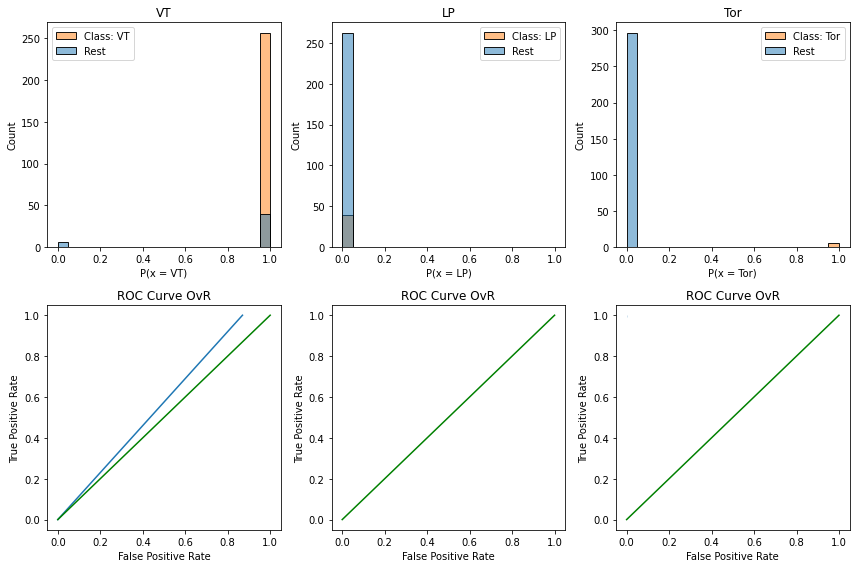

In [ ]:
#classes = model_multiclass.classes_
classes = np.array(['VT', 'LP', 'Tor'], dtype=object)
# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovr = {}

for i in range(len(classes)):
    # Gets the class
    c = classes[i]

    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_class]
    df_aux['prob'] = y_pred_[:, i]
    df_aux = df_aux.reset_index(drop = True)



    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 3, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")

    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 3, i+4)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")

    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

plt.tight_layout()

In [ ]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovr:
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(f"{k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"average ROC AUC OvR: {avg_roc_auc/i:.4f}")
# Compares with sklearn (average only)
# "Macro" average = unweighted mean
roc_auc_score(y_test, y_pred, labels = classes, multi_class = 'ovr', average = 'macro')

VT ROC AUC OvR: 0.5652
LP ROC AUC OvR: 0.5000
Tor ROC AUC OvR: 1.0000
average ROC AUC OvR: 0.6884


0.6725043690881182